In [50]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt
import itertools

The general convex optimization problem is:
\begin{equation}
\begin{aligned}
\text{minimize } & \frac{1}{2} \mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T\mathbf{x} \\
\text{subject to } & \mathbf{G}\mathbf{x} \leq \mathbf{h} \\
& \mathbf{A}\mathbf{x} = \mathbf{b}.
\end{aligned}
\end{equation}

In the general (soft or hard margin) SVDD formulation, the equations given in Tax, 2004 are as follows:
\begin{equation}
\begin{aligned}
\max_\mathbf{a} \text{ } & \mathcal{L}(\mathbf{a}) = \sum_{n=1}^{N}a_n k(\mathbf{x}_n, \mathbf{x}_n) -\sum_{n=1}^{N}\sum_{m=1}^N a_n a_m k(\mathbf{x}_n, \mathbf{x}_m), \\
&\text{such that } 0 \leq a_n \leq C \\
& \text{and } \sum_{n=1}^N a_i = 1  \\
\end{aligned}
\end{equation}

There is also a formulation for SVDD that includes negative samples. The derivation is slightly more involved, but at the end of the derivation it is revealed that if one defines a variable $a^{'}_i$ as $a^{'}_i = y_i a_i$, we can simply reformulate the problem as 
\begin{equation}
\begin{aligned}
\max_\mathbf{a}^{'} \text{ } & \mathcal{L}(\mathbf{a}^{'}) = \sum_{n=1}^{N}a^{'}_n k(\mathbf{x}_n, \mathbf{x}_n) -\sum_{n=1}^{N}\sum_{m=1}^N a^{'}_n a^{'}_m k(\mathbf{x}_n, \mathbf{x}_m), \\
&\text{such that } 0 \leq a^{'}_n \leq C \\
& \text{and } \sum_{n=1}^N a^{'}_i = 1  \\
\end{aligned}
\end{equation}

Note that the variable $y_i \in \{-1, 1\}$, and $y_i=-1$ is given to samples that the radius should not encompass. Finally, we can calculate the centroid $\alpha$ using
\begin{equation}
\boldsymbol\alpha = \sum a^{'}_i \mathbf{x_i}.
\end{equation}

If we test new data, we can do so using the radius formula
\begin{equation}
R^2 = k(\mathbf{x}_k, \mathbf{x}_k) - 2 \sum_i a^{'}_i k(\mathbf{x}_i, \mathbf{x}_k) + \sum_{i}\sum_{j} k(\mathbf{x}_i, \mathbf{x}_j)
\end{equation}

where $\mathbf{x}_k$ is any support vector. This radius is used to test new data using:
\begin{equation}
\Vert \mathbf{z} - \boldsymbol\alpha \Vert_2^2 = k(\mathbf{z}, \mathbf{z}) - 2 \sum_i a^{'}_i k(\mathbf{z}, \mathbf{x}_k) + \sum_{i}\sum_{j} k(\mathbf{x}_i, \mathbf{x}_j) \leq R^2
\end{equation}

we can subtract $R^2 - \Vert \mathbf{z} - \boldsymbol\alpha \Vert_2^2$ to produce a positive value if a test sample is in the decision boundary, or a negative value otherwise.

We can immediately see that we can rewrite this to be suitable to the convex optimisation problem: let us reformulate the convex problem with $\mathbf{x} = \mathbf{a}$ to give the following matrices (let $\otimes$ be the outer product)

\begin{equation}
\mathbf{P} = 2 * \mathbf{K}(X),
\end{equation}
where $\mathbf{K}$ is the gram matrix:
\begin{equation}
K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j),
\end{equation}

Furthermore, $\mathbf{q}$ is simply:
\begin{equation}
\mathbf{q} = -\text{diag}(\mathbf{K}).
\end{equation}

If we solve to hard margin problem ($C = \infty$, $a_n \geq 0$), then $\mathbf{G}$ is simply the negative identify matrix.
\begin{equation}
\mathbf{G}_{hard} = - \mathbf{I}
\end{equation}
and $\mathbf{h}$ is simply a zero vector
\begin{equation}
\mathbf{h} = \mathbf{0}.
\end{equation}

However, if we solve to soft margin problem ($0\leq a_n \leq C$), $\mathbf{G}$ and $\mathbf{h}$ become
\begin{equation}
\mathbf{G}_{soft} = [\mathbf{G_1}, \mathbf{G_2}]^T
\end{equation}
\begin{equation}
\mathbf{G_1} = -\mathbf{I}
\end{equation}
\begin{equation}
\mathbf{G_2} = \mathbf{I}
\end{equation}
\begin{equation}
\mathbf{h} = [\mathbf{h}_1, \mathbf{h}_2]^T
\end{equation}
\begin{equation}
\mathbf{h}_1 = \mathbf{0}
\end{equation}
\begin{equation}
\mathbf{h}_2 = C * \mathbf{1}
\end{equation}

Finally, the final equality constraint is simple, as both $\mathbf{A} = \mathbf{1}$, where $\mathbf{A}$ is the one vector and $\mathbf{b} = 1$.

We can also demonstrate how the convex problem is formulated for $a^{'}_i = y_ia_i$: let us reformulate the convex problem with $\mathbf{x} = \mathbf{a}$ to give the following matrices (let $\otimes$ be the outer product):
\begin{equation}
\mathbf{P} = 2 * \mathbf{t}\otimes \mathbf{t} * \mathbf{K}(X),
\end{equation}
where $\mathbf{K}$ is the gram matrix:
\begin{equation}
K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j),
\end{equation}

Furthermore, $\mathbf{q}$ is simply:
\begin{equation}
\mathbf{q} = -\mathbf{t} * \text{diag}(\mathbf{K}).T.
\end{equation}

If we solve to hard margin problem ($C = \infty$, $a_n \geq 0$), then $\mathbf{G}$ is simply the negative diagonal matrix with $\mathbf{t}$ on the diagonal.
\begin{equation}
\mathbf{G}_{hard} = - \text{diag}(\mathbf{t})
\end{equation}
and $\mathbf{h}$ is simply a zero vector
\begin{equation}
\mathbf{h} = \mathbf{0}.
\end{equation}

However, if we solve to soft margin problem ($0\leq a_n \leq C$), $\mathbf{G}$ and $\mathbf{h}$ become
\begin{equation}
\mathbf{G}_{soft} = [\mathbf{G_1}, \mathbf{G_2}]^T
\end{equation}
\begin{equation}
\mathbf{G_1} = -\text{diag}(\mathbf{t})
\end{equation}
\begin{equation}
\mathbf{G_2} = \text{diag}(\mathbf{t})
\end{equation}
\begin{equation}
\mathbf{h} = [\mathbf{h}_1, \mathbf{h}_2]^T
\end{equation}
\begin{equation}
\mathbf{h}_1 = \mathbf{0}
\end{equation}
\begin{equation}
\mathbf{h}_2 = C * \mathbf{1}
\end{equation}

Finally, the final equality constraint is simple, as both $\mathbf{A} = \mathbf{1}$, where $\mathbf{A}$ is the one vector and $\mathbf{b} = 1$.

In [82]:
class SVDD(object):
    def __init__(self, kernel = 'linear', degree = 3, sigma = 1, C = None, alpha_threshold = 1e-5):
        
        self.kernel = kernel
        self.degree = degree #polynomial kernel degree
        self.sigma = sigma #Gaussian kernel 1/variance
        self.C = C
        self.alpha_threshold = alpha_threshold

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)
    
    def polynomial_kernel(self, x1, x2):
        return (1 + np.dot(x1, x2)) **self.degree
    
    def gaussian_kernel(self, x1, x2):
        return np.exp(-1 * (np.linalg.norm(x1 - x2)**2) / self.sigma**2 )
    
    def apply_kernel_function(self, x1, x2):
        
        if self.kernel == 'linear':
            return self.linear_kernel(x1, x2)
        
        elif self.kernel == 'polynomial':
            return self.polynomial_kernel(x1, x2)
            
        elif self.kernel == 'gaussian':
            return self.gaussian_kernel(x1, x2)
        
        else:
            print("Illegal kernel function chosen.")
            raise SystemExit
    
    def calculate_gram(self, X):
        n, f = X.shape
        
        K = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                K[i, j] = self.apply_kernel_function(X[i, :], X[j, :])
        
        return K
    
    def calculate_max_dist(self, X):
        n, f = X.shape
        
        dist_mat = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                dist_mat[i, j] = np.linalg.norm(X[i, :] - X[j, :])**2
        
        return np.max(np.sqrt(dist_mat))
    
    def fit(self, X, y = None):
        
        #labels can be None, but 
        n = X.shape[0]
        
        if y is None:
            y = np.ones(n)
            
        else:
            assert len(y) == n
        
        #Determine gram matrix
        Gram = self.calculate_gram(X)
        
        #Setup necessary matrices to be used for lagrangian multipliers
        #P and q
        
        P = cvxopt.matrix(2 * np.outer(y, y) *  Gram)
        q = cvxopt.matrix(-1 * y.reshape(-1, 1) * np.diag(Gram).reshape(-1, 1))
        
        #G and h
        if self.C is None:
            print("\nSolving the hard margin problem!")
            G = cvxopt.matrix(-1 * np.diag(y))
            h = cvxopt.matrix(np.zeros((n, 1)))
            
        else:
            print("\nSolving the soft margin problem!")
            G_1 = -1 * np.diag(y)
            h_1 = np.zeros((n, 1))
            
            G_2 = np.diag(y)
            h_2 = self.C * np.ones((n, 1))
            
            G = cvxopt.matrix(np.vstack((G_1, G_2)))
            h = cvxopt.matrix(np.vstack((h_1, h_2)))
        
        #A and b
        A = cvxopt.matrix(y.reshape(1, -1))
        b = cvxopt.matrix(np.ones((1, 1)))
        
        #We are now ready to solve the convex optimisation problem!
        self.solution = cvxopt.solvers.qp(P, q, G, h, A, b)  
        print(self.solution)
        
        #Save alphas
        self.alphas = np.array(self.solution['x'])[:, 0]
        
        #Setup index lists!
        support_alpha_indices = []
        
        for cnt, i in enumerate(self.alphas):
            if i >= self.alpha_threshold:
                #if self.C is not None:
                #     if i != self.C:
                #        support_alpha_indices.append(cnt)
                        
                #else:
                support_alpha_indices.append(cnt)
                        
        
        self.support_alpha_indices = support_alpha_indices
        self.support_alphas = self.alphas[self.support_alpha_indices]
        self.support_vectors = X[self.support_alpha_indices, :]
        self.support_labels = y[self.support_alpha_indices]
        self.sv_weights = self.support_alphas * self.support_labels #alpha_prime for sv's
        self.error = len(self.support_alphas) / n
        
        #Calculate center
        self.center = np.sum(self.sv_weights.reshape(-1, 1) * self.support_vectors, axis = 0)
        
        #Calculate radius
        sv_index = 0 #Use first support vector to compute radius
        actual_index = self.support_alpha_indices[sv_index]
        
        #Compute sv_gram (will simply model evaluation and prediction)
        self.Gram_svs = self.calculate_gram(self.support_vectors)
        
        t1 = Gram[actual_index, actual_index]
        t2 = -2 * np.dot(self.sv_weights, self.Gram_svs[sv_index, :])
        t3 = np.dot(self.sv_weights.reshape(-1, 1).T, np.dot(self.Gram_svs, self.sv_weights.reshape(-1, 1)))
        
        self.square_radius = t1 + t2 + t3
        
        #Compute cost for grid search
        self.cost = np.sqrt(self.error**2 + np.abs(1 - self.square_radius)**2)
    
    def evaluate_model(self, x):
        #X = (N,) array
        
        pred_val = 0
        
        t1_pred = self.apply_kernel_function(x, x)
        
        t2_pred = 0
        
        for cnt, i in enumerate(self.sv_weights):
            t2_pred += i * self.apply_kernel_function(x, self.support_vectors[cnt, :])
        
        t2_pred *= -2
        
        t3_pred = np.dot(self.sv_weights.reshape(-1, 1).T, np.dot(self.Gram_svs, self.sv_weights.reshape(-1, 1)))
        
        return t1_pred + t2_pred + t3_pred
    
    def predict(self, X):

        if len(X.shape) > 1:

            n = X.shape[0]
            prediction = np.zeros(n)

            for i in range(n):
                prediction[i] = self.square_radius - self.evaluate_model(X[i, :])

        else:
            prediction = self.square_radius - self.evaluate_model(X)

        return prediction
    
    def optimise_parameters(self, X, y = None, sigma_low = 1e-4, C_opt = False, N_iter = 50, plot_flag = False):
        
        max_sigma = self.calculate_max_dist(X)
        
        print(max_sigma)
        
        sigma_range = np.linspace(sigma_low, max_sigma, N_iter)
        
        if C_opt:
            N = X.shape[0]
            C_range = np.linspace(1/N, 1, N_iter) #1/N leq C leq 1
            
        else:
            C_range = np.array([self.C])
            
        iter_list = list(itertools.product(C_range, sigma_range))
        
        error_array = np.zeros(len(iter_list))
        
        self.orig_params = self.get_params()
        
        for cnt, i in enumerate(iter_list):
            
            print("\nBeginning optimisation iteration {}...".format(cnt + 1))
            
            self.C = i[0]
            self.sigma = i[1]
            
            self.fit(X, y)
            error_array[cnt] = self.cost
        
        self.opt_errors = error_array
        
        opt_index = np.argmin(error_array)
        
        opt_dict = {"C":iter_list[opt_index][0], "sigma":iter_list[opt_index][1]}
        
        self.opt_params = opt_dict
        
        #Visualise
        if plot_flag:
            if C_opt:
                x_vis, y_vis = np.meshgrid(C_range, sigma_range)
                
                plt.figure()
                plt.contourf(x_vis, y_vis, self.opt_errors.reshape(N_iter, N_iter))
                plt.xlabel("C")
                plt.ylabel(r"$\sigma$")
                plt.show()
                
            else:
                plt.figure()
                plt.plot(sigma_range, self.opt_errors)
                plt.xlabel(r"$\sigma$")
                plt.ylabel("Objective")
                plt.show()
        
        return opt_dict #C, sigma
    
    def get_params(self):
        param_dict = {"C":self.C, "sigma":self.sigma}
        return param_dict
    
    def set_params(self, param_dict):
        self.C = param_dict["C"]
        self.sigma = param_dict["sigma"]
        
        


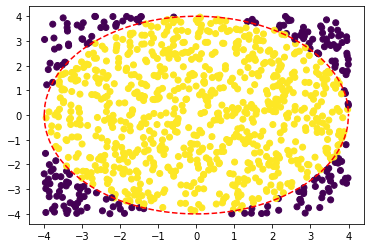

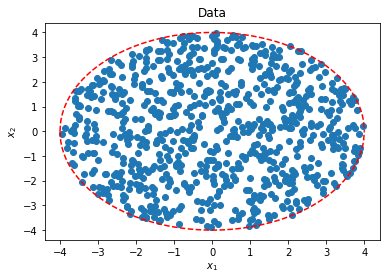

In [3]:
N_sample = 1000
R = 4
x_data = np.random.random(N_sample) * 8 - 4
y_data = np.random.random(N_sample) * 8 - 4

X_data = np.vstack((x_data, y_data)).T

R_data = np.sum(X_data**2, axis = 1)

labels = 2 * (R_data < R**2) - 1

x_plot = np.linspace(-4, 4, 400)

plt.figure()
plt.scatter(X_data[:, 0], X_data[:, 1], c = labels)
plt.plot(x_plot, np.sqrt(16 - x_plot**2), "r--")
plt.plot(x_plot, -np.sqrt(16 - x_plot**2), "r--")
plt.show()

#Get data only in sphere
X = X_data[np.nonzero(R_data < R**2)[0], :]

plt.figure()
plt.title("Data")
plt.scatter(X[:, 0], X[:, 1])
plt.plot(x_plot, np.sqrt(16 - x_plot**2), "r--")
plt.plot(x_plot, -np.sqrt(16 - x_plot**2), "r--")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()


If we test new data, we can do so using the radius formula
\begin{equation}
R^2 = k(\mathbf{x}_k, \mathbf{x}_k) - 2 \sum_i a^{'}_i k(\mathbf{x}_i, \mathbf{x}_k) + \sum_{i}\sum_{j} k(\mathbf{x}_i, \mathbf{x}_j)
\end{equation}

where $\mathbf{x}_k$ is any support vector. This radius is used to test new data using:
\begin{equation}
\Vert \mathbf{z} - \boldsymbol\alpha \Vert_2^2 = k(\mathbf{z}, \mathbf{z}) - 2 \sum_i a^{'}_i k(\mathbf{z}, \mathbf{x}_k) + \sum_{i}\sum_{j} k(\mathbf{x}_i, \mathbf{x}_j) \leq R^2
\end{equation}

we can subtract $R^2 - \Vert \mathbf{z} - \boldsymbol\alpha \Vert_2^2$ to produce a positive value if a test sample is in the decision boundary, or a negative value otherwise.


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.4800e+03 -3.9578e+03  4e+04  7e+00  6e-14
 1: -1.4742e+03 -2.7718e+03  5e+03  6e-01  6e-14
 2: -3.6981e+02 -7.1528e+02  1e+03  1e-01  2e-14
 3: -6.0403e+01 -1.7764e+02  2e+02  3e-02  1e-14
 4: -1.4004e+01 -1.8488e+01  5e+00  2e-04  4e-15
 5: -1.5016e+01 -1.6995e+01  2e+00  6e-05  2e-15
 6: -1.5231e+01 -1.6800e+01  2e+00  3e-05  1e-15
 7: -1.5866e+01 -1.6084e+01  2e-01  3e-06  2e-15
 8: -1.5961e+01 -1.5979e+01  2e-02  2e-07  2e-15
 9: -1.5968e+01 -1.5971e+01  2e-03  2e-08  2e-15
10: -1.5970e+01 -1.5970e+01  8e-05  3e-10  2e-15
11: -1.5970e+01 -1.5970e+01  8e-07  3e-12  2e-15
Optimal solution found.
{'x': <785x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <1570x1 matrix, tc='d'>, 'z': <1570x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.916172861501752e-07, 'relative gap': 4.957032135667139e-08, 'primal objective': -15.969581485144758, 'dual objective': -15.969582261741829, 'primal infeasibili

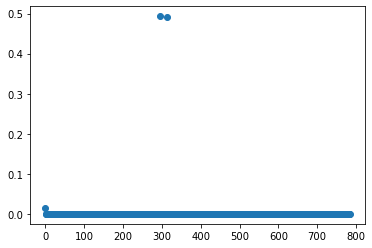

[0.00023207 0.00364936] [[15.96959524]]


In [4]:
svdd_test = SVDD('linear', C = 1)
svdd_test.fit(X)

plt.figure()
plt.scatter(np.arange(len(svdd_test.alphas)), svdd_test.alphas)
plt.show()

print(svdd_test.center, svdd_test.square_radius)

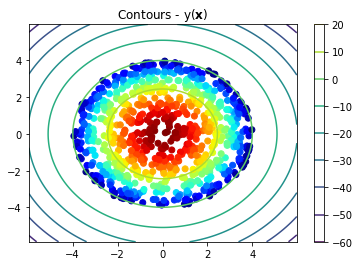

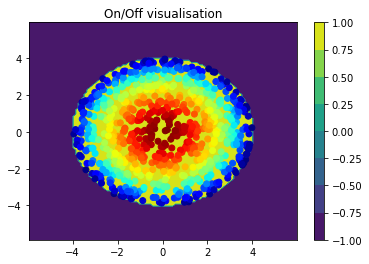

In [5]:
N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N_grid), np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

Z = svdd_test.predict(X_grid)

plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title(r"Contours - y($\mathbf{x}$)")

plt.show()

plt.figure()
plt.contourf(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title("On/Off visualisation")
plt.show()

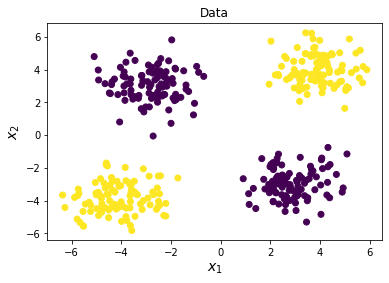

In [86]:
X1 = np.random.randn(100, 2) + np.array([4, 4])
X2 = np.random.randn(100, 2) + np.array([-4, -4])
X3 = np.random.randn(100, 2) + np.array([-3, 3])
X4 = np.random.randn(100, 2) + np.array([3, -3])

l1 = np.ones(100)
l2 = np.ones(100)
X = np.vstack((X1, X2, X3, X4))
labels = np.hstack((l1, l2, -l1, -l2))


plt.figure()
plt.title("Data")
plt.scatter(X[:, 0], X[:, 1], c = labels)
plt.xlabel(r"$x_1$", fontsize = 14)
plt.ylabel(r"$x_2$", fontsize = 14)
plt.show()


15.653067157123235

Beginning optimisation iteration 1...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9750e-01 -1.9975e+00  8e+02  3e+01  1e-16
 1: -9.9750e-01 -1.9926e+00  9e+00  3e-01  0e+00
 2: -9.9750e-01 -1.6385e+00  7e-01  3e-03  1e-16
 3: -9.9750e-01 -1.0049e+00  8e-03  3e-05  1e-16
 4: -9.9750e-01 -9.9757e-01  8e-05  3e-07  4e-16
 5: -9.9750e-01 -9.9750e-01  8e-07  3e-09  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.765108575324189e-07, 'relative gap': 7.784570000325087e-07, 'primal objective': -0.997499999999989, 'dual objective': -0.9975007363650377, 'primal infeasibility': 2.8284271257106923e-09, 'dual infeasibility': 4.440892098500626e-16, 'primal slack': 1.0000002046815763e-10, 'dual slack': 7.36365040690949e-07, 'iterations': 5}

Beginning optimisation iteration 2...

Solving the soft margin problem!


Beginning optimisation iteration 10...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.4258e-01 -1.8407e+00  9e+02  3e+01  8e-16
 1: -8.1245e-01 -1.8141e+00  2e+01  6e-01  7e-16
 2: -7.8291e-01 -1.6033e+00  1e+00  2e-02  7e-16
 3: -7.7942e-01 -8.4664e-01  8e-02  5e-04  1e-15
 4: -7.7947e-01 -7.8018e-01  8e-04  6e-06  8e-16
 5: -7.7947e-01 -7.7948e-01  8e-06  6e-08  8e-16
 6: -7.7947e-01 -7.7947e-01  8e-08  6e-10  8e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.98997796929762e-08, 'relative gap': 1.0250544229847922e-07, 'primal objective': -0.7794686594329401, 'dual objective': -0.7794687307749064, 'primal infeasibility': 5.638177291403846e-10, 'dual infeasibility': 8.045096151262284e-16, 'primal slack': 1.0936984841462715e-11, 'dual slack': 3.71109643171035e-08, 'iterations': 6}

Beginning optimisation iteration 11...



 6: -5.5035e-01 -5.5036e-01  1e-06  2e-08  8e-16
 7: -5.5035e-01 -5.5035e-01  1e-08  2e-10  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.1028906454985565e-08, 'relative gap': 2.003964754902494e-08, 'primal objective': -0.5503543127694475, 'dual objective': -0.5503543214155696, 'primal infeasibility': 1.5001184930686313e-10, 'dual infeasibility': 7.121239116308986e-16, 'primal slack': 3.715120921543314e-12, 'dual slack': 2.81340278460796e-09, 'iterations': 7}

Beginning optimisation iteration 19...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.7028e-01 -1.6614e+00  9e+02  3e+01  7e-16
 1: -6.4389e-01 -1.6114e+00  2e+01  7e-01  8e-16
 2: -5.4116e-01 -1.3885e+00  2e+00  3e-02  9e-16
 3: -5.2446e-01 -7.2696e-01  3e-01  5e-03  2e-15
 4: -5.2142e-01 -5.3190e-01  1e-02  2e-04  1e-15
 5: -5.2141e-01 -5.2152e-01  1e-04  2e-0


Beginning optimisation iteration 27...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.8102e-01 -1.5238e+00  9e+02  3e+01  6e-16
 1: -5.0411e-01 -1.4284e+00  3e+01  9e-01  7e-16
 2: -3.5691e-01 -1.2326e+00  2e+00  3e-02  9e-16
 3: -3.3911e-01 -5.4629e-01  3e-01  5e-03  2e-15
 4: -3.3627e-01 -3.4546e-01  1e-02  2e-04  1e-15
 5: -3.3627e-01 -3.3636e-01  1e-04  2e-06  8e-16
 6: -3.3627e-01 -3.3627e-01  1e-06  2e-08  8e-16
 7: -3.3627e-01 -3.3627e-01  1e-08  2e-10  8e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.1708834248571709e-08, 'relative gap': 3.482006422387576e-08, 'primal objective': -0.33626687685840284, 'dual objective': -0.3362668860598913, 'primal infeasibility': 1.5712915191283037e-10, 'dual infeasibility': 7.739974578648925e-16, 'primal slack': 3.914489858646152e-12, 'dual slack': 2.9802065166523825e-09, 'iter

 2: -2.3733e-01 -1.0856e+00  2e+00  2e-02  9e-16
 3: -2.2609e-01 -3.9860e-01  2e-01  3e-03  2e-15
 4: -2.2469e-01 -2.2913e-01  6e-03  7e-05  1e-15
 5: -2.2469e-01 -2.2473e-01  6e-05  7e-07  8e-16
 6: -2.2469e-01 -2.2469e-01  6e-07  7e-09  8e-16
 7: -2.2469e-01 -2.2469e-01  6e-09  7e-11  8e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.5167462114630954e-09, 'relative gap': 2.455264162111204e-08, 'primal objective': -0.22469053621991614, 'dual objective': -0.22469054065900698, 'primal infeasibility': 6.805269460878561e-11, 'dual infeasibility': 8.121719659239974e-16, 'primal slack': 1.7504419451047777e-12, 'dual slack': 1.1049677093769253e-09, 'iterations': 7}

Beginning optimisation iteration 36...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.8385e-01 -1.3772e+00  9e+02  3e+01  7e-16
 1: -3.2978e-01 -1.2893e+00  2e+01  


Beginning optimisation iteration 44...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.6176e-01 -1.2236e+01  8e+02  3e+01  9e-16
 1: -9.5553e-01 -1.1721e+01  2e+01  3e-01  5e-16
 2: -9.4003e-01 -2.3994e+00  1e+00  1e-15  6e-16
 3: -9.4447e-01 -1.1505e+00  2e-01  1e-15  6e-16
 4: -9.5697e-01 -1.0613e+00  1e-01  4e-16  4e-16
 5: -9.6207e-01 -9.8392e-01  2e-02  9e-17  4e-16
 6: -9.6405e-01 -9.6846e-01  4e-03  2e-16  4e-16
 7: -9.6453e-01 -9.6609e-01  2e-03  1e-16  5e-16
 8: -9.6469e-01 -9.6509e-01  4e-04  2e-16  4e-16
 9: -9.6472e-01 -9.6502e-01  3e-04  1e-16  3e-16
10: -9.6477e-01 -9.6485e-01  8e-05  8e-16  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  1e-15  4e-16
12: -9.6479e-01 -9.6480e-01  6e-06  1e-15  4e-16
13: -9.6479e-01 -9.6480e-01  2e-06  7e-16  4e-16
14: -9.6479e-01 -9.6479e-01  1e-07  5e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'sta

10: -8.3779e-01 -8.3942e-01  2e-03  2e-16  6e-16
11: -8.3820e-01 -8.3880e-01  6e-04  6e-16  6e-16
12: -8.3841e-01 -8.3849e-01  9e-05  1e-15  7e-16
13: -8.3845e-01 -8.3845e-01  2e-06  4e-16  7e-16
14: -8.3845e-01 -8.3845e-01  3e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.605824761957222e-08, 'relative gap': 3.107911197001924e-08, 'primal objective': -0.8384489120766884, 'dual objective': -0.8384489381349359, 'primal infeasibility': 2.1960593089543717e-16, 'dual infeasibility': 7.285418382412844e-16, 'primal slack': 5.309493073533607e-10, 'dual slack': 9.106826431171602e-10, 'iterations': 14}

Beginning optimisation iteration 51...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -1.2140e+01  8e+02  3e+01  7e-16
 1: -7.8679e-01 -1.1617e+01  2e+01  3e-01  7e-16
 2: -7.6887e-01 -2.2623e+00  1e+00  4e-

10: -7.1311e-01 -7.1596e-01  3e-03  6e-16  6e-16
11: -7.1373e-01 -7.1470e-01  1e-03  1e-16  6e-16
12: -7.1401e-01 -7.1418e-01  2e-04  6e-16  7e-16
13: -7.1409e-01 -7.1409e-01  4e-06  3e-16  7e-16
14: -7.1409e-01 -7.1409e-01  4e-08  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.772174399925706e-08, 'relative gap': 5.282486437031685e-08, 'primal objective': -0.7140906928755604, 'dual objective': -0.7140907305973045, 'primal infeasibility': 4.870406094789929e-16, 'dual infeasibility': 7.38989587435158e-16, 'primal slack': 8.066972435935226e-10, 'dual slack': 1.6543065534020185e-09, 'iterations': 14}

Beginning optimisation iteration 57...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.9936e-01 -1.2049e+01  8e+02  3e+01  7e-16
 1: -6.7569e-01 -1.1518e+01  3e+01  5e-01  7e-16
 2: -6.1947e-01 -3.1540e+00  3e+00  9e-1


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.2244e-01 -1.1984e+01  8e+02  3e+01  7e-16
 1: -5.8029e-01 -1.1417e+01  3e+01  6e-01  7e-16
 2: -4.7297e-01 -3.5929e+00  3e+00  2e-16  8e-16
 3: -4.8580e-01 -1.1061e+00  6e-01  7e-16  8e-16
 4: -5.1103e-01 -8.4732e-01  3e-01  1e-15  7e-16
 5: -5.3607e-01 -6.7067e-01  1e-01  1e-16  7e-16
 6: -5.4881e-01 -6.1887e-01  7e-02  4e-16  6e-16
 7: -5.5583e-01 -5.9373e-01  4e-02  3e-16  6e-16
 8: -5.5951e-01 -5.8295e-01  2e-02  1e-15  6e-16
 9: -5.6279e-01 -5.7255e-01  1e-02  5e-16  6e-16
10: -5.6462e-01 -5.6834e-01  4e-03  9e-16  7e-16
11: -5.6570e-01 -5.6690e-01  1e-03  6e-16  6e-16
12: -5.6620e-01 -5.6626e-01  5e-05  9e-16  7e-16
13: -5.6622e-01 -5.6623e-01  7e-06  2e-15  7e-16
14: -5.6623e-01 -5.6623e-01  8e-08  7e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.20713350889424

 6: -4.2577e-01 -5.0924e-01  8e-02  1e-16  5e-16
 7: -4.3510e-01 -4.7517e-01  4e-02  7e-16  6e-16
 8: -4.4121e-01 -4.5660e-01  2e-02  9e-16  7e-16
 9: -4.4414e-01 -4.5035e-01  6e-03  4e-16  7e-16
10: -4.4556e-01 -4.4833e-01  3e-03  1e-16  6e-16
11: -4.4667e-01 -4.4689e-01  2e-04  6e-16  7e-16
12: -4.4677e-01 -4.4678e-01  3e-06  7e-16  7e-16
13: -4.4678e-01 -4.4678e-01  3e-08  3e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.445491972455312e-08, 'relative gap': 7.711894192293408e-08, 'primal objective': -0.44677635436160873, 'dual objective': -0.4467763888165284, 'primal infeasibility': 3.0379542734646357e-16, 'dual infeasibility': 6.69636628554374e-16, 'primal slack': 1.8095854206273538e-10, 'dual slack': 1.2558628121858779e-09, 'iterations': 13}

Beginning optimisation iteration 70...

Solving the soft margin problem!
     pcost       dcost       gap    

 9: -3.4802e-01 -3.6081e-01  1e-02  5e-16  6e-16
10: -3.5045e-01 -3.5460e-01  4e-03  7e-16  7e-16
11: -3.5209e-01 -3.5261e-01  5e-04  2e-16  7e-16
12: -3.5232e-01 -3.5234e-01  2e-05  9e-17  7e-16
13: -3.5233e-01 -3.5233e-01  2e-06  3e-16  7e-16
14: -3.5233e-01 -3.5233e-01  1e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.4915333563716096e-07, 'relative gap': 4.233350818895697e-07, 'primal objective': -0.352329258825917, 'dual objective': -0.35232940797925255, 'primal infeasibility': 1.8967816079327053e-16, 'dual infeasibility': 6.530194474044369e-16, 'primal slack': 8.28255336129668e-10, 'dual slack': 2.688428394310473e-09, 'iterations': 14}

Beginning optimisation iteration 76...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.8385e-01 -1.1946e+01  9e+02  3e+01  7e-16
 1: -3.3535e-01 -1.1366e+01  3e+01  5e-


Beginning optimisation iteration 82...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9098e-01 -2.2547e+01  2e+01  3e-14  4e-16
 1: -9.9100e-01 -1.3073e+00  3e-01  1e-15  3e-16
 2: -9.9132e-01 -1.0043e+00  1e-02  4e-16  3e-16
 3: -9.9145e-01 -9.9302e-01  2e-03  4e-16  3e-16
 4: -9.9150e-01 -9.9161e-01  1e-04  8e-16  3e-16
 5: -9.9152e-01 -9.9154e-01  2e-05  2e-16  3e-16
 6: -9.9152e-01 -9.9152e-01  2e-06  2e-16  3e-16
 7: -9.9152e-01 -9.9152e-01  2e-07  4e-16  3e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.4641484684410655e-07, 'relative gap': 2.485225459255996e-07, 'primal objective': -0.991519083012597, 'dual objective': -0.9915193294274443, 'primal infeasibility': 4.3368086899420177e-16, 'dual infeasibility': 2.5557363324003906e-16, 'primal slack': 1.6587707463591197e-07, 'dual slack': 5.0313078086923904e-09, 'iter


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.6489e-01 -2.2496e+01  9e+02  3e+01  8e-16
 1: -8.4225e-01 -2.0543e+01  3e+01  3e-01  7e-16
 2: -8.1497e-01 -2.7104e+00  2e+00  9e-03  9e-16
 3: -8.1786e-01 -1.1819e+00  4e-01  2e-03  8e-16
 4: -8.3097e-01 -1.1214e+00  3e-01  9e-04  6e-16
 5: -8.3649e-01 -1.0099e+00  2e-01  1e-15  7e-16
 6: -8.4836e-01 -9.3169e-01  8e-02  1e-16  7e-16
 7: -8.5556e-01 -8.9727e-01  4e-02  7e-16  6e-16
 8: -8.6129e-01 -8.7784e-01  2e-02  2e-16  6e-16
 9: -8.6472e-01 -8.6836e-01  4e-03  2e-16  6e-16
10: -8.6588e-01 -8.6637e-01  5e-04  4e-16  6e-16
11: -8.6607e-01 -8.6612e-01  6e-05  2e-16  6e-16
12: -8.6609e-01 -8.6609e-01  1e-06  4e-16  6e-16
13: -8.6609e-01 -8.6609e-01  3e-08  7e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.5201000051156838e-08, 'relative gap': 2.909739379046941e-08, 'p


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.3407e-01 -2.2355e+01  9e+02  3e+01  8e-16
 1: -7.0800e-01 -2.0411e+01  3e+01  4e-01  8e-16
 2: -6.6911e-01 -2.4412e+00  2e+00  1e-03  9e-16
 3: -6.7725e-01 -1.1036e+00  4e-01  3e-04  7e-16
 4: -6.8524e-01 -1.0913e+00  4e-01  3e-04  7e-16
 5: -6.8623e-01 -1.0489e+00  4e-01  1e-04  6e-16
 6: -7.0755e-01 -8.7875e-01  2e-01  4e-05  6e-16
 7: -7.1153e-01 -8.7311e-01  2e-01  3e-05  6e-16
 8: -7.2540e-01 -7.8520e-01  6e-02  8e-06  6e-16
 9: -7.2490e-01 -7.8291e-01  6e-02  6e-06  6e-16
10: -7.3142e-01 -7.5794e-01  3e-02  6e-07  6e-16
11: -7.3510e-01 -7.4813e-01  1e-02  2e-07  6e-16
12: -7.3697e-01 -7.4310e-01  6e-03  6e-08  6e-16
13: -7.3742e-01 -7.4245e-01  5e-03  3e-08  6e-16
14: -7.3890e-01 -7.3970e-01  8e-04  4e-09  7e-16
15: -7.3920e-01 -7.3923e-01  3e-05  6e-11  7e-16
16: -7.3922e-01 -7.3922e-01  4e-07  8e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's':


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.4508e-01 -2.2345e+01  9e+02  3e+01  7e-16
 1: -6.1473e-01 -2.0381e+01  4e+01  6e-01  8e-16
 2: -5.1522e-01 -3.1733e+00  3e+00  6e-16  8e-16
 3: -5.2837e-01 -1.1597e+00  6e-01  7e-16  8e-16
 4: -5.3687e-01 -1.1366e+00  6e-01  1e-15  7e-16
 5: -5.4255e-01 -1.0088e+00  5e-01  2e-15  7e-16
 6: -5.6433e-01 -8.4443e-01  3e-01  2e-16  6e-16
 7: -5.6998e-01 -8.3522e-01  3e-01  3e-16  6e-16
 8: -5.9207e-01 -7.2339e-01  1e-01  5e-16  6e-16
 9: -6.0408e-01 -6.7803e-01  7e-02  2e-16  6e-16
10: -6.1051e-01 -6.5408e-01  4e-02  2e-16  6e-16
11: -6.2112e-01 -6.3179e-01  1e-02  2e-16  7e-16
12: -6.2403e-01 -6.2716e-01  3e-03  5e-16  7e-16
13: -6.2508e-01 -6.2545e-01  4e-04  4e-16  7e-16
14: -6.2526e-01 -6.2527e-01  1e-05  4e-16  7e-16
15: -6.2526e-01 -6.2526e-01  3e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.8102e-01 -2.2475e+01  9e+02  3e+01  6e-16
 1: -5.1017e-01 -2.0485e+01  4e+01  6e-01  7e-16
 2: -3.8618e-01 -3.4438e+00  3e+00  7e-03  8e-16
 3: -3.9578e-01 -1.0428e+00  7e-01  2e-03  7e-16
 4: -4.0580e-01 -1.0250e+00  6e-01  1e-03  7e-16
 5: -4.0395e-01 -9.6976e-01  6e-01  8e-04  6e-16
 6: -4.2929e-01 -7.6351e-01  3e-01  3e-04  6e-16
 7: -4.3496e-01 -7.6197e-01  3e-01  3e-04  6e-16
 8: -4.6180e-01 -6.1975e-01  2e-01  1e-04  6e-16
 9: -4.6827e-01 -5.9763e-01  1e-01  8e-05  6e-16
10: -4.8031e-01 -5.4557e-01  7e-02  2e-06  7e-16
11: -4.8955e-01 -5.2431e-01  3e-02  7e-07  6e-16
12: -4.9720e-01 -5.0903e-01  1e-02  2e-08  7e-16
13: -5.0131e-01 -5.0323e-01  2e-03  2e-16  7e-16
14: -5.0204e-01 -5.0242e-01  4e-04  2e-16  7e-16
15: -5.0222e-01 -5.0223e-01  1e-05  2e-16  7e-16
16: -5.0222e-01 -5.0222e-01  1e-07  6e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's':


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.1803e-01 -2.2541e+01  9e+02  3e+01  6e-16
 1: -3.9427e-01 -2.0544e+01  4e+01  6e-01  7e-16
 2: -2.8656e-01 -3.0519e+00  3e+00  6e-03  8e-16
 3: -2.9527e-01 -8.4383e-01  6e-01  1e-03  8e-16
 4: -3.0499e-01 -8.3459e-01  5e-01  1e-03  7e-16
 5: -3.2369e-01 -7.4422e-01  4e-01  6e-04  7e-16
 6: -3.3062e-01 -6.0514e-01  3e-01  3e-16  7e-16
 7: -3.5943e-01 -4.8982e-01  1e-01  6e-16  7e-16
 8: -3.7244e-01 -4.5531e-01  8e-02  7e-16  6e-16
 9: -3.8336e-01 -4.2581e-01  4e-02  2e-16  6e-16
10: -3.9095e-01 -4.1176e-01  2e-02  6e-16  6e-16
11: -3.9416e-01 -4.0474e-01  1e-02  8e-16  6e-16
12: -3.9686e-01 -4.0097e-01  4e-03  2e-16  7e-16
13: -3.9864e-01 -3.9896e-01  3e-04  2e-16  7e-16
14: -3.9879e-01 -3.9880e-01  3e-06  4e-16  7e-16
15: -3.9880e-01 -3.9880e-01  3e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.4830e-01 -2.2519e+01  9e+02  3e+01  6e-16
 1: -2.9428e-01 -2.0530e+01  3e+01  5e-01  8e-16
 2: -2.1518e-01 -2.4613e+00  2e+00  3e-03  9e-16
 3: -2.2329e-01 -6.5578e-01  4e-01  6e-04  8e-16
 4: -2.3116e-01 -6.5605e-01  4e-01  6e-04  7e-16
 5: -2.3514e-01 -6.4015e-01  4e-01  4e-04  7e-16
 6: -2.4708e-01 -5.8633e-01  3e-01  3e-04  7e-16
 7: -2.6797e-01 -4.8326e-01  2e-01  9e-05  7e-16
 8: -2.7664e-01 -4.4802e-01  2e-01  5e-05  6e-16
 9: -2.8908e-01 -3.9873e-01  1e-01  3e-05  6e-16
10: -3.0097e-01 -3.6195e-01  6e-02  1e-05  6e-16
11: -3.0664e-01 -3.4487e-01  4e-02  7e-06  6e-16
12: -3.1367e-01 -3.2852e-01  1e-02  2e-06  7e-16
13: -3.1741e-01 -3.2153e-01  4e-03  3e-07  7e-16
14: -3.1822e-01 -3.2012e-01  2e-03  7e-08  7e-16
15: -3.1900e-01 -3.1913e-01  1e-04  2e-16  8e-16
16: -3.1906e-01 -3.1906e-01  1e-06  2e-16  7e-16
17: -3.1906e-01 -3.1906e-01  1e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.2539e-01 -3.2796e+01  9e+02  2e+01  1e-15
 1: -9.1632e-01 -2.8597e+01  4e+01  2e-01  7e-16
 2: -8.8528e-01 -2.7305e+00  2e+00  5e-03  8e-16
 3: -8.9012e-01 -1.2220e+00  3e-01  9e-04  8e-16
 4: -9.1306e-01 -1.0961e+00  2e-01  5e-16  6e-16
 5: -9.2183e-01 -9.7295e-01  5e-02  4e-16  6e-16
 6: -9.2829e-01 -9.4205e-01  1e-02  1e-15  6e-16
 7: -9.3024e-01 -9.3414e-01  4e-03  6e-16  6e-16
 8: -9.3100e-01 -9.3165e-01  6e-04  3e-16  7e-16
 9: -9.3104e-01 -9.3164e-01  6e-04  2e-16  6e-16
10: -9.3118e-01 -9.3137e-01  2e-04  3e-16  6e-16
11: -9.3119e-01 -9.3136e-01  2e-04  6e-16  5e-16
12: -9.3125e-01 -9.3128e-01  3e-05  2e-16  6e-16
13: -9.3126e-01 -9.3127e-01  1e-05  5e-16  6e-16
14: -9.3126e-01 -9.3126e-01  5e-06  2e-16  5e-16
15: -9.3126e-01 -9.3126e-01  1e-07  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='

10: -7.9475e-01 -8.1510e-01  2e-02  4e-07  7e-16
11: -7.9676e-01 -8.0804e-01  1e-02  2e-07  6e-16
12: -7.9906e-01 -8.0271e-01  4e-03  4e-08  6e-16
13: -7.9997e-01 -8.0087e-01  9e-04  2e-15  7e-16
14: -8.0031e-01 -8.0045e-01  1e-04  2e-16  6e-16
15: -8.0037e-01 -8.0038e-01  5e-06  2e-16  7e-16
16: -8.0038e-01 -8.0038e-01  6e-08  7e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.9833456438801e-08, 'relative gap': 7.475663140945914e-08, 'primal objective': -0.8003765727628831, 'dual objective': -0.8003766325963391, 'primal infeasibility': 7.113303546400605e-16, 'dual infeasibility': 6.165677492636767e-16, 'primal slack': 1.4394758782506606e-09, 'dual slack': 7.467370473794845e-10, 'iterations': 16}

Beginning optimisation iteration 133...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.7513e-01 -3.2727e+01  9e+02  2e+0

 2: -5.9044e-01 -3.0276e+00  3e+00  6e-03  9e-16
 3: -5.9827e-01 -1.1861e+00  6e-01  1e-03  8e-16
 4: -6.1135e-01 -1.1672e+00  6e-01  1e-03  7e-16
 5: -6.0386e-01 -1.1268e+00  5e-01  7e-04  6e-16
 6: -6.3612e-01 -8.7770e-01  2e-01  2e-04  7e-16
 7: -6.4301e-01 -8.7554e-01  2e-01  1e-04  6e-16
 8: -6.6186e-01 -7.7544e-01  1e-01  5e-05  6e-16
 9: -6.7355e-01 -7.3553e-01  6e-02  2e-05  6e-16
10: -6.7919e-01 -7.0834e-01  3e-02  9e-07  7e-16
11: -6.8632e-01 -6.9333e-01  7e-03  6e-08  7e-16
12: -6.8797e-01 -6.9090e-01  3e-03  2e-08  6e-16
13: -6.8879e-01 -6.8965e-01  9e-04  2e-16  7e-16
14: -6.8917e-01 -6.8920e-01  3e-05  3e-16  7e-16
15: -6.8918e-01 -6.8918e-01  3e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.7521532826424494e-07, 'relative gap': 3.993351647575916e-07, 'primal objective': -0.6891838048655416, 'dual objective': -0.6891840800808698, 'pri


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.1177e-01 -3.2823e+01  9e+02  2e+01  6e-16
 1: -5.6679e-01 -2.8618e+01  5e+01  4e-01  8e-16
 2: -4.4728e-01 -3.7588e+00  4e+00  1e-02  9e-16
 3: -4.5167e-01 -1.1240e+00  7e-01  3e-03  8e-16
 4: -4.6701e-01 -1.1056e+00  7e-01  2e-03  7e-16
 5: -4.5907e-01 -1.0699e+00  6e-01  1e-03  6e-16
 6: -4.9199e-01 -8.1513e-01  3e-01  6e-04  6e-16
 7: -4.9861e-01 -8.1664e-01  3e-01  5e-04  5e-16
 8: -5.2599e-01 -6.8066e-01  2e-01  1e-04  6e-16
 9: -5.2755e-01 -6.8058e-01  2e-01  1e-04  6e-16
10: -5.4251e-01 -6.2999e-01  9e-02  4e-05  6e-16
11: -5.4777e-01 -6.0844e-01  6e-02  1e-05  6e-16
12: -5.5327e-01 -5.9559e-01  4e-02  4e-06  6e-16
13: -5.6384e-01 -5.7725e-01  1e-02  9e-07  6e-16
14: -5.6812e-01 -5.7061e-01  2e-03  6e-08  7e-16
15: -5.6920e-01 -5.6928e-01  8e-05  9e-10  7e-16
16: -5.6923e-01 -5.6923e-01  1e-06  2e-11  7e-16
17: -5.6923e-01 -5.6923e-01  1e-08  2e-13  7e-16
Optimal solution found.
{'x': <400x1


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.5029e-01 -3.3057e+01  9e+02  2e+01  6e-16
 1: -4.5566e-01 -2.8831e+01  5e+01  4e-01  7e-16
 2: -3.3280e-01 -3.7210e+00  4e+00  2e-02  9e-16
 3: -3.3568e-01 -9.1110e-01  6e-01  2e-03  7e-16
 4: -3.5264e-01 -9.0262e-01  6e-01  2e-03  7e-16
 5: -3.7156e-01 -7.9469e-01  4e-01  7e-04  6e-16
 6: -3.8430e-01 -6.7848e-01  3e-01  5e-05  7e-16
 7: -4.0659e-01 -5.8601e-01  2e-01  3e-05  6e-16
 8: -4.3270e-01 -5.0087e-01  7e-02  7e-06  6e-16
 9: -4.3926e-01 -4.8536e-01  5e-02  4e-06  6e-16
10: -4.4496e-01 -4.7007e-01  3e-02  1e-06  6e-16
11: -4.5018e-01 -4.6043e-01  1e-02  2e-07  6e-16
12: -4.5402e-01 -4.5530e-01  1e-03  4e-16  7e-16
13: -4.5452e-01 -4.5475e-01  2e-04  6e-16  7e-16
14: -4.5463e-01 -4.5463e-01  5e-06  4e-16  7e-16
15: -4.5463e-01 -4.5463e-01  6e-08  3e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.8385e-01 -3.3130e+01  9e+02  2e+01  7e-16
 1: -3.4590e-01 -2.8897e+01  4e+01  4e-01  8e-16
 2: -2.4695e-01 -2.9636e+00  3e+00  9e-03  9e-16
 3: -2.5256e-01 -7.5270e-01  5e-01  2e-03  8e-16
 4: -2.6589e-01 -7.5165e-01  5e-01  1e-03  7e-16
 5: -2.6698e-01 -7.1997e-01  5e-01  9e-04  7e-16
 6: -2.8853e-01 -6.2743e-01  3e-01  5e-04  6e-16
 7: -3.0305e-01 -5.3870e-01  2e-01  9e-05  7e-16
 8: -3.1877e-01 -4.8923e-01  2e-01  4e-05  6e-16
 9: -3.3821e-01 -4.2050e-01  8e-02  1e-05  6e-16
10: -3.4871e-01 -3.8940e-01  4e-02  4e-06  7e-16
11: -3.5810e-01 -3.7106e-01  1e-02  7e-07  7e-16
12: -3.6239e-01 -3.6422e-01  2e-03  3e-08  7e-16
13: -3.6312e-01 -3.6330e-01  2e-04  2e-09  7e-16
14: -3.6320e-01 -3.6321e-01  3e-06  3e-11  8e-16
15: -3.6320e-01 -3.6320e-01  3e-08  3e-13  8e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='

 2: -9.9131e-01 -1.0008e+00  9e-03  6e-16  3e-16
 3: -9.9145e-01 -9.9270e-01  1e-03  6e-16  3e-16
 4: -9.9150e-01 -9.9162e-01  1e-04  1e-15  3e-16
 5: -9.9152e-01 -9.9154e-01  2e-05  5e-16  3e-16
 6: -9.9152e-01 -9.9152e-01  2e-06  4e-16  3e-16
 7: -9.9152e-01 -9.9152e-01  3e-07  1e-16  3e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.7531997154505655e-07, 'relative gap': 2.7767491093041905e-07, 'primal objective': -0.9915190775519772, 'dual objective': -0.9915193528719488, 'primal infeasibility': 1.459535302474807e-16, 'dual infeasibility': 2.65278907370715e-16, 'primal slack': 1.8506912282585534e-07, 'dual slack': 2.928937805656088e-09, 'iterations': 7}

Beginning optimisation iteration 163...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.7780e-01 -4.3088e+01  4e+01  1e-14  5e-16
 1: -9.7789e-01 -1.9057e+00  9e-01  2e


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.6489e-01 -4.3153e+01  9e+02  1e+01  8e-16
 1: -8.4384e-01 -3.5948e+01  4e+01  2e-01  7e-16
 2: -8.1418e-01 -2.7975e+00  2e+00  4e-03  9e-16
 3: -8.1715e-01 -1.1806e+00  4e-01  7e-04  8e-16
 4: -8.3123e-01 -1.1250e+00  3e-01  4e-04  6e-16
 5: -8.4607e-01 -9.2841e-01  8e-02  7e-05  6e-16
 6: -8.5469e-01 -9.0618e-01  5e-02  3e-05  6e-16
 7: -8.6185e-01 -8.8000e-01  2e-02  7e-06  6e-16
 8: -8.6522e-01 -8.7125e-01  6e-03  2e-16  6e-16
 9: -8.6713e-01 -8.6769e-01  6e-04  1e-15  6e-16
10: -8.6738e-01 -8.6739e-01  1e-05  1e-15  7e-16
11: -8.6739e-01 -8.6739e-01  1e-07  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.3305723387793538e-07, 'relative gap': 1.5340038135358248e-07, 'primal objective': -0.8673852874670704, 'dual objective': -0.8673854205243052, 'primal infeasibili

10: -7.4047e-01 -7.4638e-01  6e-03  5e-16  7e-16
11: -7.4216e-01 -7.4363e-01  1e-03  2e-16  7e-16
12: -7.4266e-01 -7.4276e-01  1e-04  2e-16  7e-16
13: -7.4269e-01 -7.4270e-01  1e-05  7e-16  6e-16
14: -7.4269e-01 -7.4269e-01  1e-07  4e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2058839041693075e-07, 'relative gap': 1.6236606931215708e-07, 'primal objective': -0.7426945231093413, 'dual objective': -0.7426946436977319, 'primal infeasibility': 3.9446456702530775e-16, 'dual infeasibility': 6.517255161416357e-16, 'primal slack': 2.7749712399131383e-09, 'dual slack': 7.614269425022529e-10, 'iterations': 14}

Beginning optimisation iteration 176...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.1591e-01 -4.2992e+01  9e+02  1e+01  7e-16
 1: -6.9340e-01 -3.5816e+01  5e+01  2e-01  8e-16
 2: -6.4252e-01 -2.8233e+00  2e+00 

 6: -5.6244e-01 -8.5119e-01  3e-01  2e-04  7e-16
 7: -5.7032e-01 -8.5299e-01  3e-01  2e-04  6e-16
 8: -5.9425e-01 -7.4674e-01  2e-01  8e-05  6e-16
 9: -6.0685e-01 -7.0276e-01  1e-01  1e-05  6e-16
10: -6.1057e-01 -6.8469e-01  7e-02  4e-06  6e-16
11: -6.2027e-01 -6.6183e-01  4e-02  2e-06  6e-16
12: -6.2893e-01 -6.4096e-01  1e-02  3e-16  7e-16
13: -6.3206e-01 -6.3625e-01  4e-03  5e-16  6e-16
14: -6.3347e-01 -6.3426e-01  8e-04  2e-16  6e-16
15: -6.3379e-01 -6.3383e-01  4e-05  9e-16  7e-16
16: -6.3381e-01 -6.3381e-01  9e-07  5e-16  7e-16
17: -6.3381e-01 -6.3381e-01  2e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.8760952747669656e-08, 'relative gap': 2.9600345911408683e-08, 'primal objective': -0.6338085643937943, 'dual objective': -0.6338085831547471, 'primal infeasibility': 1.8245298748174205e-16, 'dual infeasibility': 6.665496066318103e-16, 'primal 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.8102e-01 -4.3451e+01  9e+02  1e+01  6e-16
 1: -5.1531e-01 -3.6269e+01  5e+01  3e-01  7e-16
 2: -3.8506e-01 -4.0259e+00  4e+00  1e-02  8e-16
 3: -3.8694e-01 -9.6684e-01  6e-01  2e-03  8e-16
 4: -4.1947e-01 -9.6204e-01  6e-01  1e-03  7e-16
 5: -4.0182e-01 -9.2317e-01  5e-01  1e-03  6e-16
 6: -4.3935e-01 -7.0283e-01  3e-01  3e-04  6e-16
 7: -4.4437e-01 -7.0502e-01  3e-01  3e-04  6e-16
 8: -4.7841e-01 -5.9973e-01  1e-01  8e-05  6e-16
 9: -4.8737e-01 -5.6975e-01  8e-02  2e-05  7e-16
10: -5.0195e-01 -5.3506e-01  3e-02  5e-06  6e-16
11: -5.1123e-01 -5.1771e-01  6e-03  7e-07  6e-16
12: -5.1333e-01 -5.1451e-01  1e-03  6e-08  7e-16
13: -5.1377e-01 -5.1396e-01  2e-04  5e-09  6e-16
14: -5.1386e-01 -5.1387e-01  3e-06  4e-11  7e-16
15: -5.1386e-01 -5.1386e-01  3e-08  4e-13  8e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.1803e-01 -4.3681e+01  9e+02  1e+01  6e-16
 1: -4.0266e-01 -3.6477e+01  5e+01  3e-01  7e-16
 2: -2.8531e-01 -3.5450e+00  4e+00  1e-02  9e-16
 3: -2.8872e-01 -8.3449e-01  6e-01  2e-03  8e-16
 4: -3.0827e-01 -8.3072e-01  5e-01  1e-03  7e-16
 5: -3.0968e-01 -7.6815e-01  5e-01  6e-04  6e-16
 6: -3.3849e-01 -6.5088e-01  3e-01  3e-04  6e-16
 7: -3.4787e-01 -5.6928e-01  2e-01  4e-05  7e-16
 8: -3.5528e-01 -5.5644e-01  2e-01  3e-05  6e-16
 9: -3.8821e-01 -4.5034e-01  6e-02  3e-06  6e-16
10: -4.0061e-01 -4.2545e-01  2e-02  8e-16  7e-16
11: -4.0449e-01 -4.1858e-01  1e-02  4e-16  6e-16
12: -4.0756e-01 -4.1278e-01  5e-03  6e-16  7e-16
13: -4.0929e-01 -4.1069e-01  1e-03  6e-16  7e-16
14: -4.0984e-01 -4.1000e-01  2e-04  2e-16  7e-16
15: -4.0991e-01 -4.0993e-01  1e-05  2e-16  7e-16
16: -4.0992e-01 -4.0992e-01  2e-07  6e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's':


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.4830e-01 -4.3725e+01  9e+02  1e+01  8e-16
 1: -3.0390e-01 -3.6508e+01  5e+01  3e-01  8e-16
 2: -2.1397e-01 -2.8000e+00  3e+00  6e-03  1e-15
 3: -2.1899e-01 -6.6779e-01  5e-01  1e-03  8e-16
 4: -2.3758e-01 -6.7099e-01  4e-01  9e-04  8e-16
 5: -2.2918e-01 -6.5389e-01  4e-01  7e-04  7e-16
 6: -2.4560e-01 -6.2652e-01  4e-01  5e-04  7e-16
 7: -2.4459e-01 -5.8255e-01  3e-01  3e-04  7e-16
 8: -2.8128e-01 -4.5187e-01  2e-01  6e-05  8e-16
 9: -2.9818e-01 -4.0016e-01  1e-01  2e-05  6e-16
10: -3.0738e-01 -3.7811e-01  7e-02  9e-06  7e-16
11: -3.1703e-01 -3.5420e-01  4e-02  3e-06  6e-16
12: -3.1900e-01 -3.4369e-01  2e-02  6e-07  7e-16
13: -3.2620e-01 -3.3320e-01  7e-03  4e-08  7e-16
14: -3.2860e-01 -3.3022e-01  2e-03  5e-09  7e-16
15: -3.2933e-01 -3.2940e-01  7e-05  2e-10  7e-16
16: -3.2936e-01 -3.2936e-01  7e-07  2e-12  7e-16
17: -3.2936e-01 -3.2936e-01  7e-09  2e-14  7e-16
Optimal solution found.
{'x': <400x1


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.2539e-01 -5.3387e+01  9e+02  1e+01  1e-15
 1: -9.1688e-01 -4.2531e+01  5e+01  1e-01  7e-16
 2: -8.8467e-01 -2.7696e+00  2e+00  3e-03  8e-16
 3: -8.8962e-01 -1.2165e+00  3e-01  4e-04  8e-16
 4: -9.1270e-01 -1.1015e+00  2e-01  2e-05  6e-16
 5: -9.2163e-01 -9.7423e-01  5e-02  4e-06  6e-16
 6: -9.2822e-01 -9.4256e-01  1e-02  6e-16  7e-16
 7: -9.3022e-01 -9.3423e-01  4e-03  3e-16  6e-16
 8: -9.3100e-01 -9.3164e-01  6e-04  4e-16  6e-16
 9: -9.3104e-01 -9.3163e-01  6e-04  1e-15  5e-16
10: -9.3118e-01 -9.3137e-01  2e-04  3e-16  6e-16
11: -9.3119e-01 -9.3136e-01  2e-04  7e-16  5e-16
12: -9.3125e-01 -9.3128e-01  3e-05  3e-16  6e-16
13: -9.3126e-01 -9.3127e-01  1e-05  4e-16  6e-16
14: -9.3126e-01 -9.3126e-01  5e-06  2e-16  6e-16
15: -9.3126e-01 -9.3126e-01  1e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.7513e-01 -5.3382e+01  9e+02  1e+01  8e-16
 1: -7.4588e-01 -4.2516e+01  5e+01  1e-01  7e-16
 2: -7.1976e-01 -2.5868e+00  2e+00  3e-03  7e-16
 3: -7.2462e-01 -1.1280e+00  4e-01  5e-04  7e-16
 4: -7.3720e-01 -1.1022e+00  4e-01  4e-04  7e-16
 5: -7.5450e-01 -8.6232e-01  1e-01  6e-05  7e-16
 6: -7.6810e-01 -8.2134e-01  5e-02  1e-15  7e-16
 7: -7.7416e-01 -7.9793e-01  2e-02  2e-16  6e-16
 8: -7.7467e-01 -7.9671e-01  2e-02  3e-16  5e-16
 9: -7.7830e-01 -7.8842e-01  1e-02  2e-16  6e-16
10: -7.7926e-01 -7.8521e-01  6e-03  5e-16  7e-16
11: -7.8089e-01 -7.8246e-01  2e-03  1e-15  6e-16
12: -7.8135e-01 -7.8182e-01  5e-04  4e-16  6e-16
13: -7.8148e-01 -7.8163e-01  2e-04  2e-16  7e-16
14: -7.8155e-01 -7.8155e-01  4e-06  2e-16  7e-16
15: -7.8155e-01 -7.8155e-01  4e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='

 2: -5.6354e-01 -3.3485e+00  3e+00  6e-03  9e-16
 3: -5.6993e-01 -1.1984e+00  6e-01  1e-03  8e-16
 4: -5.8867e-01 -1.1784e+00  6e-01  1e-03  7e-16
 5: -6.1214e-01 -9.6745e-01  4e-01  5e-04  6e-16
 6: -6.2818e-01 -8.5137e-01  2e-01  1e-15  7e-16
 7: -6.4677e-01 -7.5980e-01  1e-01  4e-16  6e-16
 8: -6.6121e-01 -7.0098e-01  4e-02  3e-16  6e-16
 9: -6.6791e-01 -6.8440e-01  2e-02  7e-16  6e-16
10: -6.7335e-01 -6.7517e-01  2e-03  1e-15  7e-16
11: -6.7412e-01 -6.7423e-01  1e-04  3e-16  7e-16
12: -6.7417e-01 -6.7417e-01  1e-06  9e-16  7e-16
13: -6.7417e-01 -6.7417e-01  1e-08  3e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.106882152250811e-08, 'relative gap': 1.6418340450453674e-08, 'primal objective': -0.6741741990252281, 'dual objective': -0.6741742100940495, 'primal infeasibility': 2.9181423564305765e-16, 'dual infeasibility': 6.380455121990062e-16, 'primal s

 2: -4.2359e-01 -4.0342e+00  4e+00  1e-02  9e-16
 3: -4.2635e-01 -1.0554e+00  6e-01  2e-03  8e-16
 4: -4.5278e-01 -1.0439e+00  6e-01  1e-03  7e-16
 5: -4.8584e-01 -8.2830e-01  3e-01  6e-04  6e-16
 6: -5.0507e-01 -6.9670e-01  2e-01  4e-16  7e-16
 7: -5.2369e-01 -6.2596e-01  1e-01  5e-16  6e-16
 8: -5.2524e-01 -6.2328e-01  1e-01  4e-16  6e-16
 9: -5.4374e-01 -5.7961e-01  4e-02  4e-16  6e-16
10: -5.4527e-01 -5.7184e-01  3e-02  6e-16  6e-16
11: -5.5118e-01 -5.6121e-01  1e-02  1e-15  7e-16
12: -5.5487e-01 -5.5666e-01  2e-03  2e-16  7e-16
13: -5.5532e-01 -5.5607e-01  7e-04  1e-15  6e-16
14: -5.5567e-01 -5.5568e-01  1e-05  2e-16  7e-16
15: -5.5567e-01 -5.5567e-01  1e-07  8e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2020476981396017e-07, 'relative gap': 2.1632284263060397e-07, 'primal objective': -0.5556730318084049, 'dual objective': -0.5556731520131748, 'pr


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.3975e-01 -5.4178e+01  9e+02  1e+01  5e-16
 1: -4.4299e-01 -4.3346e+01  6e+01  2e-01  7e-16
 2: -3.1414e-01 -3.8370e+00  4e+00  9e-03  8e-16
 3: -3.1685e-01 -8.8045e-01  6e-01  1e-03  8e-16
 4: -3.4315e-01 -8.7465e-01  5e-01  1e-03  7e-16
 5: -3.3986e-01 -8.0166e-01  5e-01  4e-04  6e-16
 6: -3.6283e-01 -7.4911e-01  4e-01  3e-04  6e-16
 7: -3.6272e-01 -6.7229e-01  3e-01  7e-05  6e-16
 8: -3.6959e-01 -6.7129e-01  3e-01  6e-05  6e-16
 9: -3.9863e-01 -5.6166e-01  2e-01  3e-05  6e-16
10: -4.1767e-01 -5.0034e-01  8e-02  7e-16  7e-16
11: -4.2841e-01 -4.7311e-01  4e-02  8e-16  6e-16
12: -4.3262e-01 -4.6232e-01  3e-02  7e-16  6e-16
13: -4.4164e-01 -4.4901e-01  7e-03  3e-16  6e-16
14: -4.4463e-01 -4.4483e-01  2e-04  9e-16  7e-16
15: -4.4471e-01 -4.4472e-01  2e-06  7e-16  7e-16
16: -4.4472e-01 -4.4472e-01  2e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's':

16: -3.6970e-01 -3.6970e-01  5e-07  2e-16  7e-16
17: -3.6970e-01 -3.6970e-01  5e-09  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.057735212717069e-09, 'relative gap': 1.3680538681792322e-08, 'primal objective': -0.3697029283977319, 'dual objective': -0.36970293345546706, 'primal infeasibility': 2.0341576549740935e-16, 'dual infeasibility': 7.083131380438514e-16, 'primal slack': 2.782957331122915e-11, 'dual slack': 4.882494074992696e-11, 'iterations': 17}

Beginning optimisation iteration 237...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.7211e-01 -5.4323e+01  1e+03  1e+01  8e-16
 1: -3.3798e-01 -4.3462e+01  6e+01  2e-01  8e-16
 2: -2.3416e-01 -3.0276e+00  3e+00  6e-03  9e-16
 3: -2.3898e-01 -7.1623e-01  5e-01  9e-04  9e-16
 4: -2.6309e-01 -7.1899e-01  5e-01  8e-04  7e-16
 5: -2.5081e-01 -6.9414e-01  4e-01  


Beginning optimisation iteration 243...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.7780e-01 -6.3646e+01  6e+01  3e-16  5e-16
 1: -9.7788e-01 -2.3547e+00  1e+00  4e-16  4e-16
 2: -9.7818e-01 -1.0097e+00  3e-02  6e-16  3e-16
 3: -9.7897e-01 -9.8370e-01  5e-03  2e-16  3e-16
 4: -9.7920e-01 -9.8017e-01  1e-03  2e-16  3e-16
 5: -9.7927e-01 -9.7969e-01  4e-04  3e-16  3e-16
 6: -9.7931e-01 -9.7941e-01  1e-04  4e-16  3e-16
 7: -9.7932e-01 -9.7935e-01  3e-05  3e-16  3e-16
 8: -9.7932e-01 -9.7933e-01  9e-06  2e-16  3e-16
 9: -9.7933e-01 -9.7933e-01  3e-06  6e-16  3e-16
10: -9.7933e-01 -9.7933e-01  8e-07  2e-16  3e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.897297541368378e-07, 'relative gap': 8.064016953417904e-07, 'primal objective': -0.9793255132011023, 'dual objective': -0.9793263029308563, 'primal infeasibility': 1.731

10: -8.6738e-01 -8.6739e-01  1e-05  8e-16  6e-16
11: -8.6739e-01 -8.6739e-01  1e-07  7e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.299923988180644e-07, 'relative gap': 1.498669628387812e-07, 'primal objective': -0.8673852886303115, 'dual objective': -0.8673854186227109, 'primal infeasibility': 7.301792464664125e-16, 'dual infeasibility': 6.044317365925136e-16, 'primal slack': 2.4555169841219105e-09, 'dual slack': 6.920983032999069e-10, 'iterations': 11}

Beginning optimisation iteration 250...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.4258e-01 -6.3804e+01  9e+02  9e+00  9e-16
 1: -8.1796e-01 -4.8664e+01  6e+01  1e-01  8e-16
 2: -7.9130e-01 -2.7293e+00  2e+00  2e-03  7e-16
 3: -7.9426e-01 -1.1503e+00  4e-01  4e-04  7e-16
 4: -8.0702e-01 -1.1046e+00  3e-01  2e-04  6e-16
 5: -8.2082e-01 -9.1757e-01  1e-01  5e


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.1591e-01 -6.3646e+01  9e+02  9e+00  8e-16
 1: -6.9445e-01 -4.8567e+01  6e+01  1e-01  7e-16
 2: -6.4197e-01 -2.8906e+00  2e+00  3e-03  8e-16
 3: -6.4865e-01 -1.1567e+00  5e-01  7e-04  8e-16
 4: -6.6483e-01 -1.1390e+00  5e-01  5e-04  7e-16
 5: -6.9344e-01 -8.4180e-01  1e-01  9e-05  6e-16
 6: -7.0956e-01 -7.7887e-01  7e-02  2e-05  6e-16
 7: -7.1628e-01 -7.5686e-01  4e-02  3e-16  7e-16
 8: -7.2126e-01 -7.3743e-01  2e-02  7e-16  6e-16
 9: -7.2330e-01 -7.3346e-01  1e-02  2e-16  6e-16
10: -7.2490e-01 -7.2936e-01  4e-03  3e-16  7e-16
11: -7.2621e-01 -7.2714e-01  9e-04  2e-16  7e-16
12: -7.2644e-01 -7.2682e-01  4e-04  2e-16  6e-16
13: -7.2655e-01 -7.2666e-01  1e-04  2e-16  7e-16
14: -7.2661e-01 -7.2661e-01  1e-06  5e-16  6e-16
15: -7.2661e-01 -7.2661e-01  1e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='

 2: -4.8899e-01 -3.7759e+00  4e+00  7e-03  8e-16
 3: -4.9388e-01 -1.1582e+00  7e-01  1e-03  8e-16
 4: -5.1549e-01 -1.1421e+00  6e-01  1e-03  7e-16
 5: -5.6502e-01 -7.5129e-01  2e-01  1e-04  7e-16
 6: -5.7283e-01 -7.1704e-01  1e-01  2e-05  6e-16
 7: -5.7523e-01 -7.1344e-01  1e-01  2e-05  6e-16
 8: -5.9858e-01 -6.5500e-01  6e-02  7e-06  6e-16
 9: -6.1301e-01 -6.2409e-01  1e-02  5e-07  7e-16
10: -6.1737e-01 -6.1794e-01  6e-04  2e-08  7e-16
11: -6.1762e-01 -6.1764e-01  1e-05  5e-10  7e-16
12: -6.1763e-01 -6.1763e-01  3e-07  6e-12  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.112928181443316e-07, 'relative gap': 5.040129637955335e-07, 'primal objective': -0.617628593915723, 'dual objective': -0.6176289051822411, 'primal infeasibility': 6.293104452901632e-12, 'dual infeasibility': 6.446136526438067e-16, 'primal slack': 1.1599598069889097e-09, 'dual slack': 7.57770

14: -5.0015e-01 -5.0015e-01  2e-08  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.183826094549e-08, 'relative gap': 4.3663302939638605e-08, 'primal objective': -0.5001513736988664, 'dual objective': -0.5001513955371274, 'primal infeasibility': 9.852917215215924e-16, 'dual infeasibility': 6.817366155480116e-16, 'primal slack': 1.0231304744967109e-10, 'dual slack': 1.6337394326736326e-10, 'iterations': 14}

Beginning optimisation iteration 269...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.6065e-01 -6.4596e+01  1e+03  9e+00  6e-16
 1: -4.8273e-01 -4.9549e+01  7e+01  2e-01  7e-16
 2: -3.4615e-01 -3.9923e+00  4e+00  8e-03  9e-16
 3: -3.4885e-01 -9.2585e-01  6e-01  1e-03  8e-16
 4: -3.8452e-01 -9.1784e-01  5e-01  8e-04  7e-16
 5: -3.7641e-01 -8.3191e-01  5e-01  3e-04  7e-16
 6: -3.9053e-01 -8.2027e-01  4e-01  2e-

 6: -3.0998e-01 -7.3084e-01  4e-01  2e-04  6e-16
 7: -3.2176e-01 -6.0334e-01  3e-01  7e-05  7e-16
 8: -3.4732e-01 -5.4847e-01  2e-01  1e-05  6e-16
 9: -3.8223e-01 -4.4025e-01  6e-02  3e-06  6e-16
10: -3.8257e-01 -4.2253e-01  4e-02  1e-15  7e-16
11: -3.8635e-01 -4.1678e-01  3e-02  2e-16  6e-16
12: -3.9497e-01 -4.0660e-01  1e-02  5e-16  6e-16
13: -3.9792e-01 -4.0302e-01  5e-03  4e-16  6e-16
14: -3.9978e-01 -4.0084e-01  1e-03  2e-16  6e-16
15: -4.0026e-01 -4.0031e-01  5e-05  3e-16  7e-16
16: -4.0028e-01 -4.0028e-01  5e-07  7e-16  7e-16
17: -4.0028e-01 -4.0028e-01  5e-09  7e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.136386662715384e-09, 'relative gap': 1.2831862287339645e-08, 'primal objective': -0.4002838050859632, 'dual objective': -0.40028381022235, 'primal infeasibility': 6.817907096754226e-16, 'dual infeasibility': 6.868132936467764e-16, 'primal slac


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.3631e-01 -6.4929e+01  1e+03  9e+00  5e-16
 1: -2.9739e-01 -4.9801e+01  6e+01  2e-01  8e-16
 2: -2.0379e-01 -2.8396e+00  3e+00  4e-03  9e-16
 3: -2.0841e-01 -6.3703e-01  4e-01  6e-04  9e-16
 4: -2.3830e-01 -6.4435e-01  4e-01  5e-04  7e-16
 5: -2.2422e-01 -6.2268e-01  4e-01  4e-04  7e-16
 6: -2.4600e-01 -5.8061e-01  3e-01  2e-04  7e-16
 7: -2.4370e-01 -5.2131e-01  3e-01  7e-05  7e-16
 8: -2.4715e-01 -5.1992e-01  3e-01  6e-05  8e-16
 9: -2.6474e-01 -4.8716e-01  2e-01  3e-06  7e-16
10: -2.9657e-01 -3.6637e-01  7e-02  2e-16  7e-16
11: -3.0951e-01 -3.4469e-01  4e-02  5e-16  7e-16
12: -3.1363e-01 -3.3507e-01  2e-02  1e-15  6e-16
13: -3.1874e-01 -3.2649e-01  8e-03  1e-15  7e-16
14: -3.2208e-01 -3.2261e-01  5e-04  2e-16  7e-16
15: -3.2234e-01 -3.2235e-01  6e-06  4e-16  7e-16
16: -3.2235e-01 -3.2235e-01  6e-08  4e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's':


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.0628e-01 -7.4036e+01  9e+02  8e+00  1e-15
 1: -8.9612e-01 -5.4119e+01  6e+01  9e-02  7e-16
 2: -8.5988e-01 -2.8571e+00  2e+00  2e-03  8e-16
 3: -8.6424e-01 -1.2085e+00  3e-01  3e-04  8e-16
 4: -8.8323e-01 -1.1314e+00  2e-01  1e-04  6e-16
 5: -8.9646e-01 -9.6259e-01  7e-02  2e-05  6e-16
 6: -9.0661e-01 -9.2705e-01  2e-02  2e-16  7e-16
 7: -9.0976e-01 -9.1588e-01  6e-03  1e-15  6e-16
 8: -9.1112e-01 -9.1254e-01  1e-03  1e-15  6e-16
 9: -9.1152e-01 -9.1186e-01  3e-04  2e-16  6e-16
10: -9.1165e-01 -9.1166e-01  1e-05  2e-16  7e-16
11: -9.1166e-01 -9.1166e-01  2e-07  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.8766497975145297e-07, 'relative gap': 2.0585041034701393e-07, 'primal objective': -0.9116570592941509, 'dual objective': -0.9116572469591305, 'primal infeasibili


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.5388e-01 -7.4006e+01  1e+03  8e+00  8e-16
 1: -7.2826e-01 -5.4085e+01  6e+01  9e-02  7e-16
 2: -6.9429e-01 -2.6900e+00  2e+00  2e-03  8e-16
 3: -6.9997e-01 -1.1283e+00  4e-01  4e-04  8e-16
 4: -7.1386e-01 -1.1073e+00  4e-01  3e-04  7e-16
 5: -7.3481e-01 -8.5070e-01  1e-01  4e-05  6e-16
 6: -7.4695e-01 -8.0336e-01  6e-02  1e-05  7e-16
 7: -7.5222e-01 -7.8938e-01  4e-02  3e-06  6e-16
 8: -7.5705e-01 -7.7310e-01  2e-02  9e-07  6e-16
 9: -7.5728e-01 -7.7281e-01  2e-02  8e-07  5e-16
10: -7.6043e-01 -7.6697e-01  7e-03  2e-07  6e-16
11: -7.6230e-01 -7.6302e-01  7e-04  1e-08  6e-16
12: -7.6256e-01 -7.6259e-01  3e-05  2e-10  7e-16
13: -7.6257e-01 -7.6257e-01  3e-07  2e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.9711946321050094e-07, 'relative gap': 3.8962711959579896e-07, '

 2: -5.3700e-01 -3.4999e+00  3e+00  4e-03  8e-16
 3: -5.4324e-01 -1.1786e+00  6e-01  9e-04  8e-16
 4: -5.6338e-01 -1.1628e+00  6e-01  7e-04  7e-16
 5: -6.0903e-01 -7.7414e-01  2e-01  7e-05  8e-16
 6: -6.3251e-01 -7.1881e-01  9e-02  2e-05  6e-16
 7: -6.3853e-01 -6.9564e-01  6e-02  8e-06  6e-16
 8: -6.3999e-01 -6.9358e-01  5e-02  6e-06  6e-16
 9: -6.5061e-01 -6.6921e-01  2e-02  2e-06  6e-16
10: -6.5557e-01 -6.6062e-01  5e-03  4e-07  6e-16
11: -6.5706e-01 -6.5831e-01  1e-03  5e-08  6e-16
12: -6.5753e-01 -6.5768e-01  2e-04  1e-09  7e-16
13: -6.5760e-01 -6.5760e-01  2e-06  1e-11  7e-16
14: -6.5760e-01 -6.5760e-01  2e-08  1e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.559112122595941e-08, 'relative gap': 2.3709186975967102e-08, 'primal objective': -0.6575983074309297, 'dual objective': -0.6575983230216286, 'primal infeasibility': 1.1295877398613455e-13, 'dual

10: -5.3369e-01 -5.4702e-01  1e-02  3e-16  6e-16
11: -5.3919e-01 -5.4031e-01  1e-03  2e-16  6e-16
12: -5.3970e-01 -5.3972e-01  1e-05  7e-16  7e-16
13: -5.3971e-01 -5.3971e-01  1e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.4645998988508568e-07, 'relative gap': 2.7136764226216564e-07, 'primal objective': -0.5397105884259853, 'dual objective': -0.5397107348859752, 'primal infeasibility': 2.085841396624172e-16, 'dual infeasibility': 6.613228377001097e-16, 'primal slack': 7.314513671787681e-10, 'dual slack': 8.269198063400442e-10, 'iterations': 13}

Beginning optimisation iteration 307...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.8102e-01 -7.4914e+01  1e+03  8e+00  6e-16
 1: -5.2081e-01 -5.5122e+01  7e+01  2e-01  7e-16
 2: -3.8162e-01 -4.0190e+00  4e+00  7e-03  9e-16
 3: -3.8489e-01 -9.6785e-01  6e-01  1


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.1803e-01 -7.5392e+01  1e+03  8e+00  9e-16
 1: -4.1177e-01 -5.5535e+01  7e+01  2e-01  7e-16
 2: -2.8295e-01 -3.5714e+00  4e+00  5e-03  9e-16
 3: -2.8695e-01 -8.2232e-01  5e-01  8e-04  8e-16
 4: -3.2285e-01 -8.2027e-01  5e-01  6e-04  7e-16
 5: -3.0855e-01 -7.7326e-01  5e-01  3e-04  7e-16
 6: -3.3285e-01 -7.4048e-01  4e-01  1e-04  6e-16
 7: -3.3263e-01 -6.5127e-01  3e-01  3e-05  6e-16
 8: -3.6915e-01 -5.1960e-01  2e-01  4e-07  7e-16
 9: -4.0768e-01 -4.3391e-01  3e-02  1e-08  6e-16
10: -4.0912e-01 -4.2540e-01  2e-02  2e-16  7e-16
11: -4.1640e-01 -4.1767e-01  1e-03  9e-16  6e-16
12: -4.1700e-01 -4.1704e-01  4e-05  3e-16  7e-16
13: -4.1702e-01 -4.1702e-01  4e-07  7e-16  6e-16
14: -4.1702e-01 -4.1702e-01  4e-09  5e-16  8e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.37363893605455

 6: -2.6634e-01 -5.6861e-01  3e-01  5e-05  7e-16
 7: -2.7111e-01 -4.9318e-01  2e-01  5e-06  8e-16
 8: -2.9923e-01 -4.0090e-01  1e-01  1e-06  7e-16
 9: -3.2002e-01 -3.6541e-01  5e-02  3e-07  6e-16
10: -3.3312e-01 -3.3734e-01  4e-03  7e-09  6e-16
11: -3.3485e-01 -3.3524e-01  4e-04  6e-10  6e-16
12: -3.3502e-01 -3.3503e-01  1e-05  1e-11  7e-16
13: -3.3502e-01 -3.3502e-01  1e-07  1e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.461730101417182e-07, 'relative gap': 4.36308269990349e-07, 'primal objective': -0.33502232296662976, 'dual objective': -0.3350224691388748, 'primal infeasibility': 1.2415900066679343e-13, 'dual infeasibility': 6.479396836763904e-16, 'primal slack': 4.445753645649628e-10, 'dual slack': 3.914670990398626e-10, 'iterations': 13}

Beginning optimisation iteration 320...

Solving the soft margin problem!
     pcost       dcost       gap    p

 6: -9.2824e-01 -9.4247e-01  1e-02  2e-16  6e-16
 7: -9.3022e-01 -9.3422e-01  4e-03  6e-16  6e-16
 8: -9.3100e-01 -9.3164e-01  6e-04  5e-16  6e-16
 9: -9.3104e-01 -9.3163e-01  6e-04  2e-16  6e-16
10: -9.3118e-01 -9.3137e-01  2e-04  2e-16  5e-16
11: -9.3119e-01 -9.3136e-01  2e-04  2e-16  5e-16
12: -9.3125e-01 -9.3128e-01  3e-05  5e-16  6e-16
13: -9.3126e-01 -9.3127e-01  1e-05  1e-15  5e-16
14: -9.3126e-01 -9.3126e-01  5e-06  2e-15  6e-16
15: -9.3126e-01 -9.3126e-01  1e-07  7e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 9.819505395193183e-08, 'relative gap': 1.054432499825863e-07, 'primal objective': -0.9312597436834363, 'dual objective': -0.9312598418784898, 'primal infeasibility': 6.515668597855697e-16, 'dual infeasibility': 6.088433935705703e-16, 'primal slack': 6.92356846682521e-09, 'dual slack': 5.903735333219412e-10, 'iterations': 15}

Beginning optim


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.7513e-01 -8.4366e+01  1e+03  7e+00  8e-16
 1: -7.4769e-01 -5.9127e+01  7e+01  8e-02  8e-16
 2: -7.1972e-01 -2.6510e+00  2e+00  1e-03  8e-16
 3: -7.2461e-01 -1.1194e+00  4e-01  3e-04  8e-16
 4: -7.3745e-01 -1.0943e+00  4e-01  2e-04  7e-16
 5: -7.5499e-01 -8.5846e-01  1e-01  3e-05  7e-16
 6: -7.6787e-01 -8.2175e-01  5e-02  2e-06  6e-16
 7: -7.7407e-01 -7.9820e-01  2e-02  6e-07  6e-16
 8: -7.7461e-01 -7.9706e-01  2e-02  5e-07  6e-16
 9: -7.7958e-01 -7.8613e-01  7e-03  5e-08  6e-16
10: -7.8153e-01 -7.8208e-01  5e-04  2e-09  6e-16
11: -7.8177e-01 -7.8178e-01  2e-05  4e-11  7e-16
12: -7.8177e-01 -7.8177e-01  5e-07  1e-12  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.780577519910395e-07, 'relative gap': 6.11504517616103e-07, 'primal objective': -0.7817730502706766, 'dual object

10: -6.7481e-01 -6.7951e-01  5e-03  9e-16  7e-16
11: -6.7653e-01 -6.7710e-01  6e-04  3e-16  7e-16
12: -6.7678e-01 -6.7681e-01  3e-05  2e-16  7e-16
13: -6.7680e-01 -6.7680e-01  3e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.872857547490145e-07, 'relative gap': 4.244796974464799e-07, 'primal objective': -0.6767950422063157, 'dual objective': -0.6767953294920704, 'primal infeasibility': 1.6168160772754856e-16, 'dual infeasibility': 7.103195968108833e-16, 'primal slack': 3.3786395227397497e-09, 'dual slack': 7.816072750981857e-10, 'iterations': 13}

Beginning optimisation iteration 340...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.5729e-01 -8.4493e+01  1e+03  7e+00  7e-16
 1: -6.3472e-01 -5.9456e+01  7e+01  1e-01  8e-16
 2: -5.3651e-01 -3.4792e+00  3e+00  4e-03  9e-16
 3: -5.4295e-01 -1.1665e+00  6e-01  7


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.9116e-01 -8.5264e+01  1e+03  7e+00  8e-16
 1: -5.3956e-01 -6.0234e+01  8e+01  2e-01  8e-16
 2: -4.0037e-01 -3.9599e+00  4e+00  5e-03  8e-16
 3: -4.0431e-01 -9.9549e-01  6e-01  8e-04  8e-16
 4: -4.3688e-01 -9.9264e-01  6e-01  6e-04  7e-16
 5: -4.8692e-01 -6.8321e-01  2e-01  1e-04  7e-16
 6: -4.9495e-01 -6.5602e-01  2e-01  9e-05  6e-16
 7: -5.1853e-01 -5.9341e-01  8e-02  4e-05  6e-16
 8: -5.3112e-01 -5.6087e-01  3e-02  7e-06  6e-16
 9: -5.3077e-01 -5.5635e-01  3e-02  3e-06  6e-16
10: -5.3877e-01 -5.4455e-01  6e-03  5e-07  6e-16
11: -5.4064e-01 -5.4207e-01  1e-03  8e-08  6e-16
12: -5.4125e-01 -5.4131e-01  6e-05  2e-09  6e-16
13: -5.4128e-01 -5.4128e-01  6e-07  2e-11  7e-16
14: -5.4128e-01 -5.4128e-01  7e-09  2e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.50950648679106

 2: -2.9670e-01 -3.6400e+00  4e+00  5e-03  9e-16
 3: -3.0077e-01 -8.4172e-01  6e-01  7e-04  8e-16
 4: -3.3885e-01 -8.3839e-01  5e-01  5e-04  7e-16
 5: -3.6974e-01 -6.0747e-01  2e-01  1e-04  6e-16
 6: -3.9840e-01 -5.3238e-01  1e-01  5e-05  6e-16
 7: -3.9473e-01 -5.2008e-01  1e-01  3e-05  6e-16
 8: -4.2017e-01 -4.5253e-01  3e-02  1e-06  7e-16
 9: -4.3158e-01 -4.3577e-01  4e-03  1e-07  6e-16
10: -4.3284e-01 -4.3415e-01  1e-03  4e-08  6e-16
11: -4.3340e-01 -4.3343e-01  3e-05  7e-10  7e-16
12: -4.3341e-01 -4.3341e-01  3e-07  8e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.4965784941850215e-07, 'relative gap': 8.067565586210505e-07, 'primal objective': -0.43341184609165767, 'dual objective': -0.4334121956897995, 'primal infeasibility': 7.541173620382376e-12, 'dual infeasibility': 6.737610872976185e-16, 'primal slack': 1.4630617475775599e-09, 'dual slack': 9.06

10: -3.3543e-01 -3.6322e-01  3e-02  5e-07  6e-16
11: -3.4473e-01 -3.5092e-01  6e-03  1e-07  6e-16
12: -3.4730e-01 -3.4757e-01  3e-04  5e-09  6e-16
13: -3.4742e-01 -3.4742e-01  3e-06  5e-11  7e-16
14: -3.4742e-01 -3.4742e-01  3e-08  5e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.7407125107177258e-08, 'relative gap': 7.888721237471194e-08, 'primal objective': -0.347421645183686, 'dual objective': -0.34742167258737183, 'primal infeasibility': 4.788382659513968e-13, 'dual infeasibility': 6.572302226052435e-16, 'primal slack': 1.2587529410417936e-10, 'dual slack': 3.244196071135338e-11, 'iterations': 14}

Beginning optimisation iteration 359...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.4830e-01 -8.6137e+01  1e+03  7e+00  5e-16
 1: -3.1715e-01 -6.0933e+01  8e+01  1e-01  7e-16
 2: -2.1265e-01 -2.9077e+00  3e+00  3

 6: -9.4692e-01 -9.5907e-01  1e-02  6e-16  6e-16
 7: -9.4819e-01 -9.5094e-01  3e-03  3e-16  6e-16
 8: -9.4853e-01 -9.4958e-01  1e-03  2e-16  5e-16
 9: -9.4857e-01 -9.4953e-01  1e-03  4e-16  5e-16
10: -9.4880e-01 -9.4903e-01  2e-04  7e-16  6e-16
11: -9.4885e-01 -9.4893e-01  8e-05  1e-15  5e-16
12: -9.4887e-01 -9.4888e-01  1e-05  5e-16  6e-16
13: -9.4888e-01 -9.4888e-01  7e-07  2e-15  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.616849086197122e-07, 'relative gap': 6.973344144388787e-07, 'primal objective': -0.9488774609699244, 'dual objective': -0.9488781226548316, 'primal infeasibility': 1.5472740259582464e-15, 'dual infeasibility': 5.743868608669033e-16, 'primal slack': 7.108619743708751e-08, 'dual slack': 3.4720554403193964e-09, 'iterations': 13}

Beginning optimisation iteration 366...

Solving the soft margin problem!
     pcost       dcost       gap    


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.9734e-01 -9.4750e+01  1e+03  6e+00  9e-16
 1: -7.6952e-01 -6.3751e+01  7e+01  6e-02  7e-16
 2: -7.4443e-01 -2.6540e+00  2e+00  1e-03  8e-16
 3: -7.4847e-01 -1.1162e+00  4e-01  2e-04  8e-16
 4: -7.6056e-01 -1.0858e+00  3e-01  1e-04  6e-16
 5: -7.7509e-01 -8.8210e-01  1e-01  3e-05  6e-16
 6: -7.8581e-01 -8.5286e-01  7e-02  8e-06  6e-16
 7: -7.9352e-01 -8.2096e-01  3e-02  2e-06  6e-16
 8: -7.9652e-01 -8.1303e-01  2e-02  7e-07  6e-16
 9: -7.9989e-01 -8.0544e-01  6e-03  2e-07  5e-16
10: -8.0136e-01 -8.0248e-01  1e-03  3e-16  7e-16
11: -8.0183e-01 -8.0187e-01  4e-05  9e-16  7e-16
12: -8.0185e-01 -8.0185e-01  1e-06  9e-16  7e-16
13: -8.0185e-01 -8.0185e-01  2e-08  3e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.2080150917147074e-08, 'relative gap': 2.7536618770828736e-08, '

10: -6.9352e-01 -6.9594e-01  2e-03  9e-16  7e-16
11: -6.9443e-01 -6.9482e-01  4e-04  2e-16  6e-16
12: -6.9460e-01 -6.9461e-01  1e-05  3e-16  7e-16
13: -6.9461e-01 -6.9461e-01  1e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 9.690195288624471e-08, 'relative gap': 1.3950632639814206e-07, 'primal objective': -0.6946061543452358, 'dual objective': -0.6946062512471887, 'primal infeasibility': 1.6367557554900542e-16, 'dual infeasibility': 7.056385857121502e-16, 'primal slack': 1.6381944083774491e-09, 'dual slack': 5.296468745563337e-10, 'iterations': 13}

Beginning optimisation iteration 379...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.7028e-01 -9.4773e+01  1e+03  6e+00  7e-16
 1: -6.5000e-01 -6.4018e+01  8e+01  1e-01  8e-16
 2: -5.6174e-01 -3.3260e+00  3e+00  3e-03  8e-16
 3: -5.6864e-01 -1.1585e+00  6e-01  


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.0138e-01 -9.5559e+01  1e+03  6e+00  6e-16
 1: -5.5740e-01 -6.4854e+01  8e+01  1e-01  7e-16
 2: -4.2016e-01 -3.8764e+00  4e+00  4e-03  9e-16
 3: -4.2478e-01 -1.0255e+00  6e-01  7e-04  8e-16
 4: -4.5362e-01 -1.0203e+00  6e-01  5e-04  7e-16
 5: -5.0649e-01 -6.9810e-01  2e-01  1e-04  7e-16
 6: -5.1558e-01 -6.7080e-01  2e-01  7e-05  6e-16
 7: -5.5129e-01 -5.7830e-01  3e-02  3e-06  7e-16
 8: -5.5390e-01 -5.7235e-01  2e-02  1e-06  6e-16
 9: -5.6055e-01 -5.6356e-01  3e-03  1e-07  7e-16
10: -5.6124e-01 -5.6261e-01  1e-03  3e-08  6e-16
11: -5.6182e-01 -5.6194e-01  1e-04  4e-10  7e-16
12: -5.6188e-01 -5.6188e-01  1e-06  4e-12  7e-16
13: -5.6188e-01 -5.6188e-01  1e-08  4e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2399797062661573e-08, 'relative gap': 2.2068555505802033e-08, '

 6: -4.0587e-01 -5.6186e-01  2e-01  6e-05  6e-16
 7: -4.2554e-01 -5.0146e-01  8e-02  2e-05  6e-16
 8: -4.3608e-01 -4.7781e-01  4e-02  7e-06  6e-16
 9: -4.3499e-01 -4.7546e-01  4e-02  5e-06  6e-16
10: -4.4863e-01 -4.5248e-01  4e-03  4e-07  6e-16
11: -4.4963e-01 -4.5110e-01  1e-03  2e-07  6e-16
12: -4.5011e-01 -4.5037e-01  3e-04  5e-09  7e-16
13: -4.5023e-01 -4.5024e-01  3e-06  5e-11  7e-16
14: -4.5023e-01 -4.5023e-01  3e-08  5e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.6572506550806137e-08, 'relative gap': 5.901921643860129e-08, 'primal objective': -0.4502348244228212, 'dual objective': -0.450234850990574, 'primal infeasibility': 5.309420073713151e-13, 'dual infeasibility': 7.243237081226917e-16, 'primal slack': 1.2065064070601607e-10, 'dual slack': 1.3899916815718592e-10, 'iterations': 14}

Beginning optimisation iteration 392...

Solving the soft mar

13: -3.6041e-01 -3.6041e-01  3e-06  2e-11  6e-16
14: -3.6041e-01 -3.6041e-01  3e-08  2e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.231613848718484e-08, 'relative gap': 8.96654237768573e-08, 'primal objective': -0.3604080271522193, 'dual objective': -0.3604080594664184, 'primal infeasibility': 2.354917758471616e-13, 'dual infeasibility': 7.036780520089144e-16, 'primal slack': 1.5470104534435283e-10, 'dual slack': 1.6900945714225052e-10, 'iterations': 14}

Beginning optimisation iteration 398...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.6024e-01 -9.6730e+01  1e+03  6e+00  5e-16
 1: -3.3412e-01 -6.5809e+01  8e+01  1e-01  8e-16
 2: -2.2229e-01 -2.9524e+00  3e+00  3e-03  9e-16
 3: -2.2711e-01 -6.5937e-01  4e-01  4e-04  9e-16
 4: -2.7438e-01 -6.7180e-01  4e-01  2e-04  7e-16
 5: -2.5852e-01 -6.3876e-01  4e-01  2e

10: -9.6477e-01 -9.6485e-01  8e-05  2e-16  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  2e-16  4e-16
12: -9.6480e-01 -9.6480e-01  6e-06  7e-16  4e-16
13: -9.6480e-01 -9.6480e-01  2e-06  4e-16  4e-16
14: -9.6480e-01 -9.6480e-01  2e-07  2e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.0961427702127208e-07, 'relative gap': 2.172623871732006e-07, 'primal objective': -0.9647978177380907, 'dual objective': -0.9647980273523676, 'primal infeasibility': 1.8325575286649254e-16, 'dual infeasibility': 4.463044330466896e-16, 'primal slack': 3.782923182148077e-08, 'dual slack': 1.012955942701928e-09, 'iterations': 14}

Beginning optimisation iteration 405...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.4419e-01 -1.0487e+02  1e+03  5e+00  1e-15
 1: -9.3733e-01 -6.7782e+01  7e+01  6e-02  7e-16
 2: -9.1067e-01 -2.7524e+00  2e+00  8


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -1.0511e+02  1e+03  6e+00  1e-15
 1: -7.9393e-01 -6.7981e+01  8e+01  6e-02  8e-16
 2: -7.6821e-01 -2.7165e+00  2e+00  9e-04  8e-16
 3: -7.7149e-01 -1.1201e+00  4e-01  2e-04  8e-16
 4: -7.8354e-01 -1.0841e+00  3e-01  1e-04  6e-16
 5: -7.9694e-01 -9.0243e-01  1e-01  2e-05  6e-16
 6: -8.1092e-01 -8.5714e-01  5e-02  3e-16  7e-16
 7: -8.1896e-01 -8.2953e-01  1e-02  2e-15  6e-16
 8: -8.2092e-01 -8.2632e-01  5e-03  9e-16  6e-16
 9: -8.2270e-01 -8.2342e-01  7e-04  4e-16  7e-16
10: -8.2297e-01 -8.2303e-01  6e-05  7e-16  7e-16
11: -8.2299e-01 -8.2299e-01  7e-07  4e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.078585461272101e-07, 'relative gap': 8.60102121238817e-07, 'primal objective': -0.8229936058147044, 'dual objective': -0.8229943136732503, 'primal infeasibility'

10: -7.1070e-01 -7.1118e-01  5e-04  1e-15  6e-16
11: -7.1091e-01 -7.1093e-01  1e-05  1e-15  7e-16
12: -7.1092e-01 -7.1092e-01  1e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2584731083556114e-07, 'relative gap': 1.770203781685016e-07, 'primal objective': -0.7109199072875667, 'dual objective': -0.7109200331348775, 'primal infeasibility': 2.0899526500796132e-16, 'dual infeasibility': 6.926508330976797e-16, 'primal slack': 2.8736553598199333e-09, 'dual slack': 6.237449370540584e-10, 'iterations': 12}

Beginning optimisation iteration 418...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.8423e-01 -1.0502e+02  1e+03  6e+00  8e-16
 1: -6.6521e-01 -6.8135e+01  8e+01  1e-01  7e-16
 2: -5.8773e-01 -3.1805e+00  3e+00  2e-03  8e-16
 3: -5.9487e-01 -1.1466e+00  6e-01  4e-04  8e-16
 4: -6.1418e-01 -1.1342e+00  5e-01  

 2: -4.4101e-01 -3.7780e+00  4e+00  3e-03  9e-16
 3: -4.4628e-01 -1.0493e+00  6e-01  6e-04  8e-16
 4: -4.7300e-01 -1.0432e+00  6e-01  5e-04  7e-16
 5: -5.2759e-01 -7.0541e-01  2e-01  6e-05  6e-16
 6: -5.3811e-01 -6.7851e-01  1e-01  4e-05  6e-16
 7: -5.7393e-01 -5.9154e-01  2e-02  1e-07  7e-16
 8: -5.7918e-01 -5.8537e-01  6e-03  4e-08  6e-16
 9: -5.8021e-01 -5.8397e-01  4e-03  9e-09  6e-16
10: -5.8197e-01 -5.8204e-01  7e-05  2e-10  7e-16
11: -5.8200e-01 -5.8200e-01  4e-06  9e-12  7e-16
12: -5.8200e-01 -5.8200e-01  4e-08  9e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.344724022161137e-08, 'relative gap': 7.465148053955204e-08, 'primal objective': -0.5820010521906801, 'dual objective': -0.582001095637109, 'primal infeasibility': 9.279697846199258e-14, 'dual infeasibility': 7.459714858022466e-16, 'primal slack': 2.264869065292686e-10, 'dual slack': 1.457701


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.3975e-01 -1.0692e+02  1e+03  6e+00  6e-16
 1: -4.5334e-01 -7.0023e+01  9e+01  1e-01  7e-16
 2: -3.1081e-01 -3.6217e+00  4e+00  3e-03  9e-16
 3: -3.1529e-01 -8.4864e-01  5e-01  5e-04  9e-16
 4: -3.5609e-01 -8.4506e-01  5e-01  3e-04  7e-16
 5: -3.9530e-01 -5.8281e-01  2e-01  1e-04  6e-16
 6: -3.9791e-01 -5.7511e-01  2e-01  8e-05  6e-16
 7: -4.2851e-01 -4.9876e-01  7e-02  1e-05  7e-16
 8: -4.3804e-01 -4.7544e-01  4e-02  5e-06  6e-16
 9: -4.4722e-01 -4.5438e-01  7e-03  1e-07  7e-16
10: -4.4958e-01 -4.5152e-01  2e-03  3e-08  6e-16
11: -4.5001e-01 -4.5094e-01  9e-04  6e-09  6e-16
12: -4.5045e-01 -4.5046e-01  1e-05  7e-11  7e-16
13: -4.5045e-01 -4.5045e-01  1e-07  7e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.039171618559502e-07, 'relative gap': 2.306943914229076e-07, 'pr

 9: -3.4980e-01 -3.8109e-01  3e-02  2e-07  6e-16
10: -3.4912e-01 -3.7788e-01  3e-02  1e-07  6e-16
11: -3.5946e-01 -3.6206e-01  3e-03  8e-09  6e-16
12: -3.6013e-01 -3.6124e-01  1e-03  3e-09  6e-16
13: -3.6055e-01 -3.6070e-01  2e-04  6e-11  6e-16
14: -3.6062e-01 -3.6063e-01  2e-06  6e-13  7e-16
15: -3.6062e-01 -3.6062e-01  2e-08  6e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.5108415515417767e-08, 'relative gap': 4.1895120896915456e-08, 'primal objective': -0.3606247026376317, 'dual objective': -0.3606247177459879, 'primal infeasibility': 6.4897363686630475e-15, 'dual infeasibility': 7.11592945469332e-16, 'primal slack': 7.606232542739563e-11, 'dual slack': 7.123845143504651e-11, 'iterations': 15}

Beginning optimisation iteration 438...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.6024e-01 -1.0733e+02  1e+03  6

 6: -9.6410e-01 -9.6872e-01  5e-03  7e-16  4e-16
 7: -9.6455e-01 -9.6612e-01  2e-03  4e-16  5e-16
 8: -9.6470e-01 -9.6510e-01  4e-04  2e-16  4e-16
 9: -9.6473e-01 -9.6503e-01  3e-04  4e-16  4e-16
10: -9.6477e-01 -9.6485e-01  8e-05  9e-16  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  6e-16  4e-16
12: -9.6480e-01 -9.6480e-01  6e-06  7e-16  4e-16
13: -9.6480e-01 -9.6480e-01  2e-06  4e-16  4e-16
14: -9.6480e-01 -9.6480e-01  2e-07  7e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.096206247142345e-07, 'relative gap': 2.172689664723744e-07, 'primal objective': -0.9647978177356848, 'dual objective': -0.9647980273563103, 'primal infeasibility': 6.907393807390025e-16, 'dual infeasibility': 3.946431162923178e-16, 'primal slack': 3.783028188296232e-08, 'dual slack': 9.217055504122985e-10, 'iterations': 14}

Beginning optimisation iteration 445...

Solving the soft margi


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -1.1545e+02  1e+03  5e+00  9e-16
 1: -7.9431e-01 -7.1809e+01  8e+01  5e-02  8e-16
 2: -7.6822e-01 -2.7342e+00  2e+00  8e-04  7e-16
 3: -7.7146e-01 -1.1170e+00  3e-01  1e-04  8e-16
 4: -7.8363e-01 -1.0812e+00  3e-01  8e-05  7e-16
 5: -7.9700e-01 -9.0173e-01  1e-01  2e-05  6e-16
 6: -8.1098e-01 -8.5683e-01  5e-02  2e-16  7e-16
 7: -8.1899e-01 -8.2950e-01  1e-02  3e-16  6e-16
 8: -8.2093e-01 -8.2632e-01  5e-03  1e-15  6e-16
 9: -8.2270e-01 -8.2342e-01  7e-04  2e-16  7e-16
10: -8.2297e-01 -8.2303e-01  6e-05  6e-16  7e-16
11: -8.2299e-01 -8.2299e-01  7e-07  3e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.157989317095991e-07, 'relative gap': 8.697502990197597e-07, 'primal objective': -0.8229936023204942, 'dual objective': -0.8229943181194261, 'primal infeasibility

10: -7.1070e-01 -7.1118e-01  5e-04  3e-16  7e-16
11: -7.1091e-01 -7.1093e-01  1e-05  7e-16  7e-16
12: -7.1092e-01 -7.1092e-01  1e-07  9e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2557298588122476e-07, 'relative gap': 1.7663450486934207e-07, 'primal objective': -0.7109199076030591, 'dual objective': -0.7109200331760447, 'primal infeasibility': 9.042116416609059e-16, 'dual infeasibility': 6.138916606371083e-16, 'primal slack': 2.8661718482944264e-09, 'dual slack': 5.661231680694929e-10, 'iterations': 12}

Beginning optimisation iteration 458...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.8423e-01 -1.1536e+02  1e+03  5e+00  7e-16
 1: -6.6547e-01 -7.2008e+01  8e+01  9e-02  8e-16
 2: -5.8749e-01 -3.1730e+00  3e+00  2e-03  9e-16
 3: -5.9467e-01 -1.1370e+00  5e-01  3e-04  8e-16
 4: -6.1432e-01 -1.1255e+00  5e-01  

 6: -5.3788e-01 -6.7924e-01  1e-01  4e-05  6e-16
 7: -5.7380e-01 -5.9179e-01  2e-02  5e-08  7e-16
 8: -5.8054e-01 -5.8382e-01  3e-03  5e-09  7e-16
 9: -5.8201e-01 -5.8219e-01  2e-04  2e-10  7e-16
10: -5.8209e-01 -5.8209e-01  2e-06  3e-12  7e-16
11: -5.8209e-01 -5.8209e-01  2e-08  3e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.0448209620391633e-08, 'relative gap': 3.512898363494573e-08, 'primal objective': -0.5820894174703675, 'dual objective': -0.5820894379183166, 'primal infeasibility': 2.6867482133476895e-14, 'dual infeasibility': 6.94746319242727e-16, 'primal slack': 1.0192552982782424e-10, 'dual slack': 1.197830807298283e-11, 'iterations': 11}

Beginning optimisation iteration 465...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.0138e-01 -1.1645e+02  1e+03  5e+00  6e-16
 1: -5.5885e-01 -7.3219e+01  9e+01  1


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.3975e-01 -1.1747e+02  1e+03  5e+00  5e-16
 1: -4.5465e-01 -7.4102e+01  9e+01  1e-01  7e-16
 2: -3.1041e-01 -3.5646e+00  4e+00  3e-03  9e-16
 3: -3.1511e-01 -8.3735e-01  5e-01  4e-04  8e-16
 4: -3.5735e-01 -8.3479e-01  5e-01  3e-04  7e-16
 5: -3.9592e-01 -5.8021e-01  2e-01  8e-05  6e-16
 6: -3.9869e-01 -5.7229e-01  2e-01  7e-05  6e-16
 7: -4.2950e-01 -4.9697e-01  7e-02  9e-06  7e-16
 8: -4.4305e-01 -4.6657e-01  2e-02  3e-06  6e-16
 9: -4.4559e-01 -4.5649e-01  1e-02  2e-16  6e-16
10: -4.5026e-01 -4.5112e-01  9e-04  3e-16  6e-16
11: -4.5042e-01 -4.5093e-01  5e-04  5e-16  6e-16
12: -4.5066e-01 -4.5067e-01  6e-06  4e-16  6e-16
13: -4.5067e-01 -4.5067e-01  6e-08  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.9491754596979387e-08, 'relative gap': 1.320087896686151e-07, 'p

10: -3.5968e-01 -3.6227e-01  3e-03  8e-08  6e-16
11: -3.6043e-01 -3.6136e-01  9e-04  3e-08  6e-16
12: -3.6065e-01 -3.6103e-01  4e-04  3e-09  6e-16
13: -3.6084e-01 -3.6084e-01  4e-06  3e-11  7e-16
14: -3.6084e-01 -3.6084e-01  4e-08  3e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.038113648233533e-08, 'relative gap': 1.1190959050853834e-07, 'primal objective': -0.36083713914809096, 'dual objective': -0.36083717952593825, 'primal infeasibility': 3.277292103573503e-13, 'dual infeasibility': 6.845072387048997e-16, 'primal slack': 1.9957283977097602e-10, 'dual slack': 1.685106765895712e-10, 'iterations': 14}

Beginning optimisation iteration 478...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.6024e-01 -1.1793e+02  1e+03  5e+00  5e-16
 1: -3.3792e-01 -7.4379e+01  9e+01  1e-01  7e-16
 2: -2.2204e-01 -2.9485e+00  3e+00 

 5: -9.6248e-01 -9.8311e-01  2e-02  2e-16  4e-16
 6: -9.6410e-01 -9.6872e-01  5e-03  3e-16  4e-16
 7: -9.6455e-01 -9.6612e-01  2e-03  4e-16  4e-16
 8: -9.6470e-01 -9.6510e-01  4e-04  2e-16  4e-16
 9: -9.6473e-01 -9.6503e-01  3e-04  2e-16  4e-16
10: -9.6477e-01 -9.6485e-01  8e-05  2e-16  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  9e-16  4e-16
12: -9.6480e-01 -9.6480e-01  6e-06  1e-15  4e-16
13: -9.6480e-01 -9.6480e-01  2e-06  4e-16  4e-16
14: -9.6480e-01 -9.6480e-01  2e-07  4e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.096245418797959e-07, 'relative gap': 2.1727302656229624e-07, 'primal objective': -0.964797817734143, 'dual objective': -0.9647980273586853, 'primal infeasibility': 4.220444362439406e-16, 'dual infeasibility': 4.093452813068212e-16, 'primal slack': 3.783096571634688e-08, 'dual slack': 8.455324728513615e-10, 'iterations': 14}

Beginning opti


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -1.2578e+02  1e+03  5e+00  9e-16
 1: -7.9463e-01 -7.5307e+01  8e+01  5e-02  7e-16
 2: -7.6821e-01 -2.7523e+00  2e+00  7e-04  8e-16
 3: -7.7142e-01 -1.1142e+00  3e-01  1e-04  8e-16
 4: -7.8372e-01 -1.0785e+00  3e-01  7e-05  7e-16
 5: -7.9706e-01 -9.0108e-01  1e-01  2e-05  6e-16
 6: -8.1104e-01 -8.5654e-01  5e-02  7e-16  7e-16
 7: -8.1902e-01 -8.2948e-01  1e-02  4e-16  6e-16
 8: -8.2093e-01 -8.2631e-01  5e-03  6e-16  6e-16
 9: -8.2270e-01 -8.2342e-01  7e-04  8e-16  6e-16
10: -8.2297e-01 -8.2303e-01  6e-05  8e-16  6e-16
11: -8.2299e-01 -8.2299e-01  7e-07  1e-15  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.225956630226857e-07, 'relative gap': 8.780088491617324e-07, 'primal objective': -0.8229935993385198, 'dual objective': -0.8229943219341818, 'primal infeasibility

10: -7.1071e-01 -7.1118e-01  5e-04  2e-16  6e-16
11: -7.1092e-01 -7.1093e-01  1e-05  3e-16  7e-16
12: -7.1092e-01 -7.1092e-01  1e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0831161869397996e-07, 'relative gap': 1.5235417705203127e-07, 'primal objective': -0.7109199156186568, 'dual objective': -0.7109200239302754, 'primal infeasibility': 1.771703456926157e-16, 'dual infeasibility': 6.682776285676563e-16, 'primal slack': 2.4704782265409785e-09, 'dual slack': 4.4350100421157414e-10, 'iterations': 12}

Beginning optimisation iteration 498...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.8423e-01 -1.2570e+02  1e+03  5e+00  8e-16
 1: -6.6568e-01 -7.5551e+01  9e+01  8e-02  8e-16
 2: -5.8725e-01 -3.1669e+00  3e+00  1e-03  8e-16
 3: -5.9447e-01 -1.1279e+00  5e-01  3e-04  8e-16
 4: -6.1446e-01 -1.1172e+00  5e-01 

 6: -5.3777e-01 -6.7954e-01  1e-01  3e-05  6e-16
 7: -5.7371e-01 -5.9197e-01  2e-02  4e-16  6e-16
 8: -5.8061e-01 -5.8375e-01  3e-03  8e-16  7e-16
 9: -5.8202e-01 -5.8216e-01  1e-04  5e-16  7e-16
10: -5.8209e-01 -5.8209e-01  1e-06  3e-16  8e-16
11: -5.8209e-01 -5.8209e-01  1e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.4123560933839402e-08, 'relative gap': 2.4263558895893953e-08, 'primal objective': -0.5820894203706237, 'dual objective': -0.5820894344941847, 'primal infeasibility': 2.4367820855534914e-16, 'dual infeasibility': 7.442428271253419e-16, 'primal slack': 7.055816020430426e-11, 'dual slack': 5.976532641069646e-12, 'iterations': 11}

Beginning optimisation iteration 505...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.0138e-01 -1.2690e+02  1e+03  5e+00  7e-16
 1: -5.5942e-01 -7.6890e+01  9e+01  

 2: -3.1005e-01 -3.5111e+00  3e+00  2e-03  8e-16
 3: -3.1493e-01 -8.2586e-01  5e-01  4e-04  9e-16
 4: -3.5872e-01 -8.2440e-01  5e-01  2e-04  7e-16
 5: -3.9654e-01 -5.7768e-01  2e-01  7e-05  6e-16
 6: -3.9937e-01 -5.6977e-01  2e-01  6e-05  6e-16
 7: -4.3001e-01 -4.9570e-01  7e-02  7e-06  6e-16
 8: -4.4873e-01 -4.5388e-01  5e-03  4e-07  7e-16
 9: -4.5055e-01 -4.5122e-01  7e-04  3e-08  7e-16
10: -4.5082e-01 -4.5088e-01  7e-05  3e-09  6e-16
11: -4.5085e-01 -4.5085e-01  8e-07  3e-11  7e-16
12: -4.5085e-01 -4.5085e-01  8e-09  3e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.641975441123744e-09, 'relative gap': 1.6950302416928205e-08, 'primal objective': -0.45084596446442937, 'dual objective': -0.45084597210325283, 'primal infeasibility': 2.6231676304982614e-13, 'dual infeasibility': 6.728285119420405e-16, 'primal slack': 3.2552251456338374e-11, 'dual slack': 2.


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.6024e-01 -1.2853e+02  1e+03  5e+00  5e-16
 1: -3.3943e-01 -7.8146e+01  9e+01  1e-01  8e-16
 2: -2.2193e-01 -2.9459e+00  3e+00  2e-03  9e-16
 3: -2.2665e-01 -6.3765e-01  4e-01  2e-04  9e-16
 4: -2.8075e-01 -6.5357e-01  4e-01  1e-04  7e-16
 5: -3.0708e-01 -4.4938e-01  1e-01  5e-05  6e-16
 6: -3.2204e-01 -4.0000e-01  8e-02  1e-06  6e-16
 7: -3.3841e-01 -3.6112e-01  2e-02  2e-08  6e-16
 8: -3.4687e-01 -3.4996e-01  3e-03  2e-09  6e-16
 9: -3.4789e-01 -3.4875e-01  9e-04  6e-10  6e-16
10: -3.4805e-01 -3.4851e-01  5e-04  1e-10  6e-16
11: -3.4827e-01 -3.4827e-01  5e-06  2e-12  7e-16
12: -3.4827e-01 -3.4827e-01  5e-08  2e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.17949200280203e-08, 'relative gap': 1.4872057914655648e-07, 'primal objective': -0.34827002641631105, 'dual obje


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.4419e-01 -1.3576e+02  1e+03  4e+00  1e-15
 1: -9.3758e-01 -7.8215e+01  9e+01  5e-02  7e-16
 2: -9.1050e-01 -2.8212e+00  2e+00  6e-04  8e-16
 3: -9.1516e-01 -1.1816e+00  3e-01  8e-05  7e-16
 4: -9.3724e-01 -1.0759e+00  1e-01  2e-16  6e-16
 5: -9.4359e-01 -9.7949e-01  4e-02  1e-15  5e-16
 6: -9.4694e-01 -9.5895e-01  1e-02  3e-16  6e-16
 7: -9.4819e-01 -9.5093e-01  3e-03  7e-16  6e-16
 8: -9.4854e-01 -9.4957e-01  1e-03  2e-16  5e-16
 9: -9.4857e-01 -9.4953e-01  1e-03  3e-16  5e-16
10: -9.4880e-01 -9.4902e-01  2e-04  4e-16  6e-16
11: -9.4885e-01 -9.4892e-01  7e-05  8e-16  5e-16
12: -9.4887e-01 -9.4888e-01  1e-05  1e-15  5e-16
13: -9.4888e-01 -9.4888e-01  6e-07  1e-15  5e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.489219375708516e-07, 'relative gap': 6.838838107641375e-07, 'pr


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.9734e-01 -1.3608e+02  1e+03  4e+00  9e-16
 1: -7.7093e-01 -7.8454e+01  9e+01  4e-02  7e-16
 2: -7.4437e-01 -2.7332e+00  2e+00  6e-04  8e-16
 3: -7.4828e-01 -1.1055e+00  4e-01  1e-04  8e-16
 4: -7.6091e-01 -1.0754e+00  3e-01  7e-05  6e-16
 5: -7.7535e-01 -8.7940e-01  1e-01  1e-05  6e-16
 6: -7.8584e-01 -8.5208e-01  7e-02  5e-06  6e-16
 7: -7.9356e-01 -8.2064e-01  3e-02  1e-06  6e-16
 8: -7.9661e-01 -8.1275e-01  2e-02  4e-07  6e-16
 9: -7.9991e-01 -8.0537e-01  5e-03  1e-07  6e-16
10: -8.0139e-01 -8.0245e-01  1e-03  2e-16  7e-16
11: -8.0183e-01 -8.0187e-01  4e-05  1e-15  7e-16
12: -8.0185e-01 -8.0185e-01  1e-06  4e-16  7e-16
13: -8.0185e-01 -8.0185e-01  2e-08  9e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.7631884583827423e-08, 'relative gap': 2.1989092586665943e-08, '

 9: -6.9401e-01 -6.9553e-01  2e-03  3e-16  6e-16
10: -6.9455e-01 -6.9476e-01  2e-04  1e-15  7e-16
11: -6.9464e-01 -6.9465e-01  3e-06  3e-16  6e-16
12: -6.9464e-01 -6.9464e-01  3e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.105864133061003e-08, 'relative gap': 4.4711596794381135e-08, 'primal objective': -0.6946439751065464, 'dual objective': -0.6946440061651876, 'primal infeasibility': 2.1371534420658197e-16, 'dual infeasibility': 6.904515645047869e-16, 'primal slack': 5.185135245964513e-10, 'dual slack': 1.1906920706058216e-10, 'iterations': 12}

Beginning optimisation iteration 539...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.7028e-01 -1.3617e+02  1e+03  4e+00  8e-16
 1: -6.5103e-01 -7.8986e+01  9e+01  8e-02  8e-16
 2: -5.6056e-01 -3.2707e+00  3e+00  1e-03  8e-16
 3: -5.6776e-01 -1.1149e+00  6e-01  

 6: -5.1559e-01 -6.6922e-01  2e-01  4e-05  6e-16
 7: -5.5246e-01 -5.7514e-01  2e-02  1e-15  7e-16
 8: -5.6097e-01 -5.6357e-01  3e-03  4e-16  7e-16
 9: -5.6211e-01 -5.6227e-01  2e-04  7e-16  7e-16
10: -5.6218e-01 -5.6218e-01  2e-06  4e-16  7e-16
11: -5.6218e-01 -5.6218e-01  2e-08  4e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.6445732341743537e-08, 'relative gap': 2.925341222328958e-08, 'primal objective': -0.5621816770028134, 'dual objective': -0.5621816934485457, 'primal infeasibility': 4.378968679556804e-16, 'dual infeasibility': 7.139786889624462e-16, 'primal slack': 7.773226297602831e-11, 'dual slack': 2.584556559425081e-11, 'iterations': 11}

Beginning optimisation iteration 546...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.9116e-01 -1.3761e+02  1e+03  4e+00  6e-16
 1: -5.4347e-01 -8.0492e+01  1e+02  1e

 2: -2.9478e-01 -3.3864e+00  3e+00  2e-03  8e-16
 3: -2.9982e-01 -7.8741e-01  5e-01  3e-04  1e-15
 4: -3.4645e-01 -7.8951e-01  4e-01  2e-04  7e-16
 5: -3.8203e-01 -5.5046e-01  2e-01  5e-05  6e-16
 6: -3.8456e-01 -5.4419e-01  2e-01  5e-05  6e-16
 7: -4.1323e-01 -4.7936e-01  7e-02  7e-06  6e-16
 8: -4.3215e-01 -4.3741e-01  5e-03  4e-07  6e-16
 9: -4.3398e-01 -4.3472e-01  7e-04  3e-08  6e-16
10: -4.3430e-01 -4.3431e-01  1e-05  5e-10  7e-16
11: -4.3431e-01 -4.3431e-01  1e-07  5e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2063128162591815e-07, 'relative gap': 2.7775691486700656e-07, 'primal objective': -0.4343052329900694, 'dual objective': -0.4343053535563792, 'primal infeasibility': 5.018205285215242e-12, 'dual infeasibility': 6.694191375807929e-16, 'primal slack': 5.020300450238664e-10, 'dual slack': 3.7073157568324685e-10, 'iterations': 11}

Beginning o


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.4830e-01 -1.3915e+02  1e+03  4e+00  6e-16
 1: -3.2618e-01 -8.1598e+01  1e+02  9e-02  7e-16
 2: -2.1212e-01 -2.9052e+00  3e+00  1e-03  9e-16
 3: -2.1662e-01 -6.1030e-01  4e-01  2e-04  9e-16
 4: -2.7406e-01 -6.2872e-01  4e-01  1e-04  7e-16
 5: -2.9897e-01 -4.2779e-01  1e-01  3e-05  6e-16
 6: -3.1315e-01 -3.8125e-01  7e-02  6e-16  7e-16
 7: -3.3049e-01 -3.4640e-01  2e-02  2e-16  6e-16
 8: -3.3373e-01 -3.3920e-01  5e-03  3e-16  6e-16
 9: -3.3589e-01 -3.3673e-01  8e-04  2e-16  6e-16
10: -3.3597e-01 -3.3661e-01  6e-04  4e-16  6e-16
11: -3.3627e-01 -3.3628e-01  8e-06  4e-16  6e-16
12: -3.3628e-01 -3.3628e-01  8e-08  7e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.597554812653282e-08, 'relative gap': 2.2593087488542202e-07, 'primal objective': -0.336277846775315, 'dual objec


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.2539e-01 -1.4605e+02  1e+03  4e+00  1e-15
 1: -9.1810e-01 -8.1165e+01  9e+01  5e-02  8e-16
 2: -8.8389e-01 -2.9113e+00  2e+00  6e-04  7e-16
 3: -8.8860e-01 -1.1918e+00  3e-01  9e-05  8e-16
 4: -9.1311e-01 -1.0926e+00  2e-01  5e-06  7e-16
 5: -9.2188e-01 -9.7294e-01  5e-02  1e-06  6e-16
 6: -9.2830e-01 -9.4220e-01  1e-02  5e-16  7e-16
 7: -9.3024e-01 -9.3418e-01  4e-03  2e-16  6e-16
 8: -9.3100e-01 -9.3165e-01  6e-04  2e-16  7e-16
 9: -9.3104e-01 -9.3164e-01  6e-04  4e-16  6e-16
10: -9.3118e-01 -9.3137e-01  2e-04  7e-16  6e-16
11: -9.3119e-01 -9.3136e-01  2e-04  4e-16  5e-16
12: -9.3125e-01 -9.3128e-01  3e-05  2e-16  6e-16
13: -9.3126e-01 -9.3127e-01  1e-05  4e-16  5e-16
14: -9.3126e-01 -9.3126e-01  5e-06  3e-16  5e-16
15: -9.3126e-01 -9.3126e-01  1e-07  3e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.7513e-01 -1.4633e+02  1e+03  4e+00  9e-16
 1: -7.4968e-01 -8.1328e+01  9e+01  4e-02  7e-16
 2: -7.1958e-01 -2.7589e+00  2e+00  6e-04  8e-16
 3: -7.2431e-01 -1.1019e+00  4e-01  1e-04  8e-16
 4: -7.3804e-01 -1.0772e+00  3e-01  7e-05  7e-16
 5: -7.5542e-01 -8.5497e-01  1e-01  1e-05  6e-16
 6: -7.6814e-01 -8.2024e-01  5e-02  1e-06  6e-16
 7: -7.7427e-01 -7.9767e-01  2e-02  3e-07  5e-16
 8: -7.7491e-01 -7.9628e-01  2e-02  2e-07  5e-16
 9: -7.7992e-01 -7.8532e-01  5e-03  2e-08  7e-16
10: -7.8157e-01 -7.8205e-01  5e-04  1e-09  6e-16
11: -7.8177e-01 -7.8178e-01  1e-05  2e-11  7e-16
12: -7.8177e-01 -7.8177e-01  3e-07  4e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.498928825905677e-07, 'relative gap': 4.475632097056666e-07, 'primal objective': -0.7817731104857114, 'dual objec

10: -6.7772e-01 -6.7773e-01  1e-06  5e-16  7e-16
11: -6.7772e-01 -6.7772e-01  1e-08  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 9.870554707444425e-09, 'relative gap': 1.456424985753889e-08, 'primal objective': -0.6777248951366439, 'dual objective': -0.6777249050071984, 'primal infeasibility': 4.960891944479921e-16, 'dual infeasibility': 7.098503734851796e-16, 'primal slack': 1.2131335338425167e-10, 'dual slack': 2.991685869529735e-11, 'iterations': 11}

Beginning optimisation iteration 580...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.5729e-01 -1.4665e+02  1e+03  4e+00  7e-16
 1: -6.3649e-01 -8.2167e+01  1e+02  8e-02  8e-16
 2: -5.3443e-01 -3.3546e+00  3e+00  1e-03  9e-16
 3: -5.4150e-01 -1.0940e+00  6e-01  3e-04  9e-16
 4: -5.6457e-01 -1.0874e+00  5e-01  2e-04  8e-16
 5: -6.1115e-01 -7.6561e-01  2e-01  2e

 9: -5.4240e-01 -5.4258e-01  2e-04  7e-16  6e-16
10: -5.4248e-01 -5.4248e-01  2e-06  1e-15  7e-16
11: -5.4248e-01 -5.4248e-01  2e-08  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.8965052278938896e-08, 'relative gap': 3.4959751342544505e-08, 'primal objective': -0.5424824705735034, 'dual objective': -0.5424824895385558, 'primal infeasibility': 1.3518710722225882e-15, 'dual infeasibility': 7.192633859587687e-16, 'primal slack': 8.651237746161243e-11, 'dual slack': 6.025133852804934e-11, 'iterations': 11}

Beginning optimisation iteration 587...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.8102e-01 -1.4833e+02  1e+03  4e+00  6e-16
 1: -5.2716e-01 -8.3826e+01  1e+02  1e-01  8e-16
 2: -3.7792e-01 -3.6133e+00  3e+00  2e-03  9e-16
 3: -3.8337e-01 -9.0223e-01  5e-01  3e-04  9e-16
 4: -4.2981e-01 -9.0191e-01  5e-01  

 6: -3.7862e-01 -5.0929e-01  1e-01  2e-05  6e-16
 7: -4.1160e-01 -4.2691e-01  2e-02  3e-07  7e-16
 8: -4.1718e-01 -4.1988e-01  3e-03  3e-08  6e-16
 9: -4.1837e-01 -4.1847e-01  1e-04  9e-10  7e-16
10: -4.1842e-01 -4.1842e-01  1e-06  9e-12  7e-16
11: -4.1842e-01 -4.1842e-01  1e-08  9e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.010280769177144e-08, 'relative gap': 2.4145283880634595e-08, 'primal objective': -0.4184174326429959, 'dual objective': -0.4184174427445218, 'primal infeasibility': 9.293553656064317e-14, 'dual infeasibility': 6.971859477610342e-16, 'primal slack': 4.387963268007766e-11, 'dual slack': 3.250350322129947e-12, 'iterations': 11}

Beginning optimisation iteration 594...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.0684e-01 -1.4949e+02  1e+03  4e+00  6e-16
 1: -4.0554e-01 -8.4698e+01  1e+02  9e

 6: -3.0333e-01 -3.6500e-01  6e-02  7e-16  6e-16
 7: -3.2189e-01 -3.2915e-01  7e-03  8e-16  6e-16
 8: -3.2241e-01 -3.2771e-01  5e-03  4e-16  6e-16
 9: -3.2471e-01 -3.2499e-01  3e-04  2e-16  6e-16
10: -3.2483e-01 -3.2484e-01  9e-06  9e-16  6e-16
11: -3.2484e-01 -3.2484e-01  9e-08  1e-15  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.826229192797577e-08, 'relative gap': 2.717127345836589e-07, 'primal objective': -0.32483678787900266, 'dual objective': -0.3248368761412942, 'primal infeasibility': 1.1710126006335724e-15, 'dual infeasibility': 6.093630201026643e-16, 'primal slack': 4.4710245386377924e-10, 'dual slack': 7.977844345229474e-11, 'iterations': 11}

Beginning optimisation iteration 601...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9750e-01 -1.5584e+02  2e+02  6e-14  1e-16
 1: -9.9750e-01 -2.5459e+00  2e+00  

 2: -8.5938e-01 -2.9595e+00  2e+00  6e-04  7e-16
 3: -8.6347e-01 -1.1807e+00  3e-01  9e-05  9e-16
 4: -8.8355e-01 -1.1146e+00  2e-01  3e-05  6e-16
 5: -8.9674e-01 -9.5940e-01  6e-02  6e-06  6e-16
 6: -9.0674e-01 -9.2654e-01  2e-02  1e-15  7e-16
 7: -9.0980e-01 -9.1579e-01  6e-03  4e-16  6e-16
 8: -9.1114e-01 -9.1252e-01  1e-03  2e-16  7e-16
 9: -9.1153e-01 -9.1185e-01  3e-04  2e-16  6e-16
10: -9.1165e-01 -9.1166e-01  1e-05  2e-16  6e-16
11: -9.1166e-01 -9.1166e-01  2e-07  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.6471163673158122e-07, 'relative gap': 1.8067280061291432e-07, 'primal objective': -0.9116570738529184, 'dual objective': -0.9116572385645553, 'primal infeasibility': 1.8038145615480075e-16, 'dual infeasibility': 6.266428686880015e-16, 'primal slack': 4.174775335041698e-09, 'dual slack': 3.5719608678669006e-10, 'iterations': 11}

Beginning 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.5388e-01 -1.5661e+02  1e+03  4e+00  8e-16
 1: -7.3063e-01 -8.4019e+01  9e+01  4e-02  7e-16
 2: -6.9382e-01 -2.8227e+00  2e+00  6e-04  7e-16
 3: -6.9932e-01 -1.1011e+00  4e-01  1e-04  9e-16
 4: -7.1461e-01 -1.0814e+00  4e-01  8e-05  7e-16
 5: -7.3543e-01 -8.4501e-01  1e-01  1e-05  7e-16
 6: -7.4712e-01 -8.0166e-01  5e-02  4e-06  6e-16
 7: -7.5258e-01 -7.8786e-01  4e-02  8e-07  6e-16
 8: -7.5718e-01 -7.7284e-01  2e-02  3e-07  6e-16
 9: -7.5742e-01 -7.7248e-01  2e-02  2e-07  6e-16
10: -7.6063e-01 -7.6651e-01  6e-03  4e-08  6e-16
11: -7.6231e-01 -7.6300e-01  7e-04  4e-09  6e-16
12: -7.6256e-01 -7.6259e-01  3e-05  5e-11  7e-16
13: -7.6257e-01 -7.6257e-01  3e-07  5e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.7607014203364515e-07, 'relative gap': 3.620241224591825e-07, 'p

10: -6.5989e-01 -6.5989e-01  4e-06  4e-16  7e-16
11: -6.5989e-01 -6.5989e-01  4e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.637649498077994e-08, 'relative gap': 5.51248939765399e-08, 'primal objective': -0.6598923346004272, 'dual objective': -0.659892370976922, 'primal infeasibility': 2.4997371641572895e-16, 'dual infeasibility': 7.109789457192482e-16, 'primal slack': 3.356505605787988e-10, 'dual slack': 1.1811362570129038e-10, 'iterations': 11}

Beginning optimisation iteration 621...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.4508e-01 -1.5719e+02  1e+03  4e+00  8e-16
 1: -6.2193e-01 -8.5150e+01  1e+02  8e-02  8e-16
 2: -5.0900e-01 -3.4180e+00  3e+00  1e-03  9e-16
 3: -5.1591e-01 -1.0660e+00  6e-01  3e-04  9e-16
 4: -5.4070e-01 -1.0615e+00  5e-01  2e-04  7e-16
 5: -5.9051e-01 -7.4751e-01  2e-01  2e-

10: -5.2313e-01 -5.2313e-01  2e-06  2e-16  6e-16
11: -5.2313e-01 -5.2313e-01  2e-08  6e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.078982443515723e-08, 'relative gap': 3.974150867989475e-08, 'primal objective': -0.5231262004322149, 'dual objective': -0.5231262212220393, 'primal infeasibility': 5.930262356614528e-16, 'dual infeasibility': 6.531157205795601e-16, 'primal slack': 9.216141701689663e-11, 'dual slack': 6.220466790085773e-11, 'iterations': 11}

Beginning optimisation iteration 628...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.7088e-01 -1.5907e+02  1e+03  4e+00  6e-16
 1: -5.1052e-01 -8.6907e+01  1e+02  9e-02  7e-16
 2: -3.5905e-01 -3.5402e+00  3e+00  2e-03  9e-16
 3: -3.6451e-01 -8.6888e-01  5e-01  3e-04  1e-15
 4: -4.1158e-01 -8.6719e-01  5e-01  2e-04  8e-16
 5: -4.5078e-01 -6.3574e-01  2e-01  6e-

 6: -3.7098e-01 -4.8136e-01  1e-01  1e-05  6e-16
 7: -3.9781e-01 -4.1018e-01  1e-02  8e-07  7e-16
 8: -4.0225e-01 -4.0433e-01  2e-03  8e-08  6e-16
 9: -4.0315e-01 -4.0322e-01  7e-05  3e-09  7e-16
10: -4.0318e-01 -4.0319e-01  7e-07  3e-11  7e-16
11: -4.0318e-01 -4.0318e-01  7e-09  3e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.932676485311238e-09, 'relative gap': 1.7194791977490218e-08, 'primal objective': -0.4031846674497043, 'dual objective': -0.4031846743785149, 'primal infeasibility': 2.6521535080116557e-13, 'dual infeasibility': 6.813631915936577e-16, 'primal slack': 2.9001825026136597e-11, 'dual slack': 2.9441692014566545e-12, 'iterations': 11}

Beginning optimisation iteration 635...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.9544e-01 -1.6016e+02  1e+03  4e+00  7e-16
 1: -3.8970e-01 -8.7668e+01  1e+02 


Beginning optimisation iteration 642...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9098e-01 -1.6645e+02  2e+02  1e-14  5e-16
 1: -9.9099e-01 -3.2808e+00  2e+00  3e-16  4e-16
 2: -9.9120e-01 -1.0199e+00  3e-02  8e-16  3e-16
 3: -9.9141e-01 -9.9467e-01  3e-03  9e-16  3e-16
 4: -9.9149e-01 -9.9188e-01  4e-04  3e-16  3e-16
 5: -9.9151e-01 -9.9158e-01  7e-05  2e-16  3e-16
 6: -9.9152e-01 -9.9153e-01  1e-05  3e-16  3e-16
 7: -9.9152e-01 -9.9152e-01  1e-06  3e-16  3e-16
 8: -9.9152e-01 -9.9152e-01  2e-07  2e-16  3e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.5869970310076361e-07, 'relative gap': 1.600571307647632e-07, 'primal objective': -0.9915191053499854, 'dual objective': -0.9915192640496886, 'primal infeasibility': 1.7692479332567347e-16, 'dual infeasibility': 2.569992767654777e-16, 'primal slack': 1.077480021606115


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.6489e-01 -1.6709e+02  1e+03  3e+00  1e-15
 1: -8.4776e-01 -8.6606e+01  9e+01  4e-02  8e-16
 2: -8.1390e-01 -2.9162e+00  2e+00  5e-04  8e-16
 3: -8.1668e-01 -1.1294e+00  3e-01  8e-05  9e-16
 4: -8.3178e-01 -1.0870e+00  3e-01  4e-05  7e-16
 5: -8.4677e-01 -9.2152e-01  7e-02  8e-06  6e-16
 6: -8.5534e-01 -9.0203e-01  5e-02  3e-06  6e-16
 7: -8.6207e-01 -8.7905e-01  2e-02  8e-07  5e-16
 8: -8.6544e-01 -8.7077e-01  5e-03  8e-16  7e-16
 9: -8.6716e-01 -8.6765e-01  5e-04  6e-16  7e-16
10: -8.6738e-01 -8.6739e-01  8e-06  2e-16  7e-16
11: -8.6739e-01 -8.6739e-01  1e-07  3e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0502490510087727e-07, 'relative gap': 1.2108218187514326e-07, 'primal objective': -0.8673853037202135, 'dual objective': -0.8673854087451184, 'primal infeasibili


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.1591e-01 -1.6691e+02  1e+03  3e+00  8e-16
 1: -6.9690e-01 -8.6608e+01  1e+02  5e-02  8e-16
 2: -6.4063e-01 -2.9630e+00  2e+00  7e-04  8e-16
 3: -6.4741e-01 -1.0996e+00  5e-01  1e-04  9e-16
 4: -6.6587e-01 -1.0872e+00  4e-01  1e-04  8e-16
 5: -6.9487e-01 -8.2856e-01  1e-01  2e-05  7e-16
 6: -7.1470e-01 -7.5960e-01  4e-02  2e-15  7e-16
 7: -7.2104e-01 -7.4201e-01  2e-02  5e-16  7e-16
 8: -7.2500e-01 -7.3182e-01  7e-03  3e-16  7e-16
 9: -7.2666e-01 -7.2835e-01  2e-03  2e-16  6e-16
10: -7.2705e-01 -7.2761e-01  6e-04  4e-16  7e-16
11: -7.2724e-01 -7.2738e-01  1e-04  1e-15  7e-16
12: -7.2731e-01 -7.2731e-01  3e-06  2e-16  7e-16
13: -7.2731e-01 -7.2731e-01  3e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.8528452340446723e-08, 'relative gap': 3.922479027091782e-08, 'p


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.2244e-01 -1.6797e+02  1e+03  3e+00  7e-16
 1: -5.9212e-01 -8.8153e+01  1e+02  8e-02  8e-16
 2: -4.6102e-01 -3.5029e+00  3e+00  1e-03  9e-16
 3: -4.6751e-01 -1.0036e+00  5e-01  3e-04  1e-15
 4: -4.9620e-01 -1.0027e+00  5e-01  2e-04  8e-16
 5: -5.4973e-01 -7.1356e-01  2e-01  3e-05  7e-16
 6: -5.6000e-01 -6.9036e-01  1e-01  2e-05  6e-16
 7: -5.9409e-01 -6.1105e-01  2e-02  2e-07  7e-16
 8: -6.0098e-01 -6.0319e-01  2e-03  3e-09  7e-16
 9: -6.0202e-01 -6.0205e-01  3e-05  4e-11  7e-16
10: -6.0204e-01 -6.0204e-01  3e-07  4e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.993373206609365e-07, 'relative gap': 4.972076932565027e-07, 'primal objective': -0.6020367840658339, 'dual objective': -0.6020370833974003, 'primal infeasibility': 4.373716599380725e-13, 'dual infeasibility': 6


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.5029e-01 -1.7003e+02  1e+03  4e+00  5e-16
 1: -4.7618e-01 -8.9912e+01  1e+02  8e-02  7e-16
 2: -3.2454e-01 -3.4054e+00  3e+00  2e-03  9e-16
 3: -3.2993e-01 -8.0926e-01  5e-01  2e-04  1e-15
 4: -3.7954e-01 -8.1039e-01  4e-01  1e-04  7e-16
 5: -4.1548e-01 -5.9165e-01  2e-01  4e-05  6e-16
 6: -4.1888e-01 -5.8182e-01  2e-01  4e-05  6e-16
 7: -4.5060e-01 -5.0302e-01  5e-02  3e-06  7e-16
 8: -4.6614e-01 -4.7078e-01  5e-03  2e-07  7e-16
 9: -4.6775e-01 -4.6840e-01  6e-04  1e-08  6e-16
10: -4.6803e-01 -4.6803e-01  7e-06  1e-10  7e-16
11: -4.6803e-01 -4.6803e-01  7e-08  1e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.852153020946436e-08, 'relative gap': 1.4640410774541928e-07, 'primal objective': -0.46803010697360903, 'dual objective': -0.46803017547111636, 'primal infeasibil


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.7211e-01 -1.7089e+02  1e+03  4e+00  6e-16
 1: -3.5857e-01 -9.0403e+01  1e+02  8e-02  8e-16
 2: -2.3185e-01 -2.9767e+00  3e+00  1e-03  1e-15
 3: -2.3657e-01 -6.3328e-01  4e-01  2e-04  1e-15
 4: -2.9655e-01 -6.5155e-01  4e-01  8e-05  7e-16
 5: -3.2059e-01 -4.5949e-01  1e-01  3e-05  5e-16
 6: -3.4101e-01 -4.0438e-01  6e-02  1e-15  6e-16
 7: -3.5908e-01 -3.6402e-01  5e-03  3e-16  6e-16
 8: -3.6098e-01 -3.6175e-01  8e-04  4e-16  6e-16
 9: -3.6133e-01 -3.6134e-01  9e-06  4e-16  7e-16
10: -3.6133e-01 -3.6133e-01  9e-08  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 9.485015691398193e-08, 'relative gap': 2.6250099186679737e-07, 'primal objective': -0.36133256579126516, 'dual objective': -0.36133266064142233, 'primal infeasibility': 1.0220044968465069e-15, 'dual infeasibility

 9: -9.6473e-01 -9.6503e-01  3e-04  7e-16  4e-16
10: -9.6477e-01 -9.6485e-01  8e-05  6e-16  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  6e-16  4e-16
12: -9.6480e-01 -9.6480e-01  6e-06  1e-15  4e-16
13: -9.6480e-01 -9.6480e-01  2e-06  2e-15  4e-16
14: -9.6480e-01 -9.6480e-01  2e-07  4e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.0965023904707806e-07, 'relative gap': 2.1729966133395858e-07, 'primal objective': -0.9647978177235884, 'dual objective': -0.9647980273738271, 'primal infeasibility': 3.5845597882766577e-16, 'dual infeasibility': 3.9450444367105217e-16, 'primal slack': 3.7835838855129706e-08, 'dual slack': 5.983447277950865e-10, 'iterations': 14}

Beginning optimisation iteration 685...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.4419e-01 -1.7693e+02  1e+03  3e+00  1e-15
 1: -9.3775e-01 -8.8378e+01  1e+02


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -1.7744e+02  1e+03  3e+00  1e-15
 1: -7.9558e-01 -8.8772e+01  1e+02  4e-02  9e-16
 2: -7.6812e-01 -2.8453e+00  2e+00  4e-04  7e-16
 3: -7.7114e-01 -1.1026e+00  3e-01  7e-05  8e-16
 4: -7.8414e-01 -1.0672e+00  3e-01  4e-05  7e-16
 5: -7.9729e-01 -8.9835e-01  1e-01  1e-05  6e-16
 6: -8.1126e-01 -8.5538e-01  4e-02  7e-16  7e-16
 7: -8.1912e-01 -8.2941e-01  1e-02  1e-15  7e-16
 8: -8.2097e-01 -8.2624e-01  5e-03  9e-16  6e-16
 9: -8.2270e-01 -8.2341e-01  7e-04  9e-16  6e-16
10: -8.2297e-01 -8.2303e-01  6e-05  3e-16  6e-16
11: -8.2299e-01 -8.2299e-01  7e-07  7e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.416869213774135e-07, 'relative gap': 9.012061932442016e-07, 'primal objective': -0.8229935911863371, 'dual objective': -0.822994332873258, 'primal infeasibility'

10: -7.1078e-01 -7.1109e-01  3e-04  2e-15  7e-16
11: -7.1092e-01 -7.1092e-01  7e-06  3e-16  7e-16
12: -7.1092e-01 -7.1092e-01  7e-08  4e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.057553307052863e-08, 'relative gap': 9.927353235662676e-08, 'primal objective': -0.710919933996058, 'dual objective': -0.710920004571591, 'primal infeasibility': 3.5219137608933217e-16, 'dual infeasibility': 6.65985840562133e-16, 'primal slack': 1.4800586250485798e-09, 'dual slack': 1.2663724400059436e-10, 'iterations': 12}

Beginning optimisation iteration 698...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.8423e-01 -1.7738e+02  1e+03  3e+00  7e-16
 1: -6.6630e-01 -8.9259e+01  1e+02  6e-02  8e-16
 2: -5.8612e-01 -3.1613e+00  3e+00  9e-04  9e-16
 3: -5.9333e-01 -1.0891e+00  5e-01  2e-04  9e-16
 4: -6.1513e-01 -1.0818e+00  5e-01  1e-

 6: -5.3780e-01 -6.7790e-01  1e-01  2e-05  6e-16
 7: -5.7351e-01 -5.9241e-01  2e-02  3e-16  7e-16
 8: -5.8099e-01 -5.8329e-01  2e-03  2e-16  6e-16
 9: -5.8207e-01 -5.8211e-01  4e-05  2e-16  7e-16
10: -5.8209e-01 -5.8209e-01  4e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.8665838803527514e-07, 'relative gap': 6.642596369050857e-07, 'primal objective': -0.5820892412442693, 'dual objective': -0.5820896279026574, 'primal infeasibility': 1.6553065507351339e-16, 'dual infeasibility': 7.039653937537778e-16, 'primal slack': 1.9620358340749996e-09, 'dual slack': 1.6332812847002853e-10, 'iterations': 10}

Beginning optimisation iteration 705...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.0138e-01 -1.7914e+02  1e+03  3e+00  6e-16
 1: -5.6101e-01 -9.1214e+01  1e+02  8e-02  7e-16
 2: -4.1682e-01 -3.5202e+00  3e+00 

 2: -3.0855e-01 -3.3142e+00  3e+00  1e-03  9e-16
 3: -3.1394e-01 -7.7402e-01  5e-01  2e-04  1e-15
 4: -3.6679e-01 -7.7869e-01  4e-01  1e-04  7e-16
 5: -4.0013e-01 -5.6631e-01  2e-01  4e-05  6e-16
 6: -4.0317e-01 -5.5833e-01  2e-01  3e-05  6e-16
 7: -4.3254e-01 -4.8893e-01  6e-02  3e-06  6e-16
 8: -4.4886e-01 -4.5378e-01  5e-03  2e-07  7e-16
 9: -4.5053e-01 -4.5126e-01  7e-04  2e-08  7e-16
10: -4.5084e-01 -4.5085e-01  7e-06  2e-10  7e-16
11: -4.5085e-01 -4.5085e-01  7e-08  2e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.406364925905743e-08, 'relative gap': 1.6427685328584438e-07, 'primal objective': -0.4508465299745271, 'dual objective': -0.4508466040072044, 'primal infeasibility': 1.8198146093872522e-12, 'dual infeasibility': 6.557468568748892e-16, 'primal slack': 3.042835773251811e-10, 'dual slack': 1.8352257177375872e-10, 'iterations': 11}

Beginning o

 2: -2.2149e-01 -2.9435e+00  3e+00  1e-03  1e-15
 3: -2.2598e-01 -6.0748e-01  4e-01  1e-04  1e-15
 4: -2.8951e-01 -6.2841e-01  3e-01  7e-05  7e-16
 5: -3.1179e-01 -4.3932e-01  1e-01  2e-05  6e-16
 6: -3.2853e-01 -3.8920e-01  6e-02  1e-15  7e-16
 7: -3.4617e-01 -3.5174e-01  6e-03  2e-16  6e-16
 8: -3.4828e-01 -3.4901e-01  7e-04  9e-16  6e-16
 9: -3.4861e-01 -3.4862e-01  1e-05  6e-16  6e-16
10: -3.4861e-01 -3.4861e-01  1e-07  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.1847551222937193e-07, 'relative gap': 3.3984825190466176e-07, 'primal objective': -0.3486129811331443, 'dual objective': -0.3486130996086565, 'primal infeasibility': 1.8788242934713003e-16, 'dual infeasibility': 6.439846768812187e-16, 'primal slack': 5.57059267800371e-10, 'dual slack': 4.042293683187232e-11, 'iterations': 10}

Beginning optimisation iteration 719...

Solving the soft mar

 6: -9.4695e-01 -9.5885e-01  1e-02  2e-16  5e-16
 7: -9.4819e-01 -9.5093e-01  3e-03  2e-16  5e-16
 8: -9.4854e-01 -9.4957e-01  1e-03  9e-16  5e-16
 9: -9.4857e-01 -9.4953e-01  1e-03  7e-16  5e-16
10: -9.4880e-01 -9.4902e-01  2e-04  2e-16  6e-16
11: -9.4885e-01 -9.4892e-01  7e-05  5e-16  5e-16
12: -9.4887e-01 -9.4888e-01  1e-05  8e-16  6e-16
13: -9.4888e-01 -9.4888e-01  6e-07  1e-15  5e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.423722365504321e-07, 'relative gap': 6.769812305220409e-07, 'primal objective': -0.9488774689588946, 'dual objective': -0.9488781113311322, 'primal infeasibility': 1.1988917040931576e-15, 'dual infeasibility': 5.380263211375276e-16, 'primal slack': 6.899733788070696e-08, 'dual slack': 1.701409454217902e-09, 'iterations': 13}

Beginning optimisation iteration 726...

Solving the soft margin problem!
     pcost       dcost       gap    p


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.9734e-01 -1.8773e+02  1e+03  3e+00  9e-16
 1: -7.7174e-01 -9.0749e+01  1e+02  3e-02  8e-16
 2: -7.4417e-01 -2.8315e+00  2e+00  4e-04  7e-16
 3: -7.4787e-01 -1.0950e+00  3e-01  6e-05  8e-16
 4: -7.6129e-01 -1.0649e+00  3e-01  4e-05  7e-16
 5: -7.7555e-01 -8.7671e-01  1e-01  9e-06  6e-16
 6: -7.8584e-01 -8.5129e-01  7e-02  3e-06  6e-16
 7: -7.9359e-01 -8.2036e-01  3e-02  9e-07  6e-16
 8: -7.9667e-01 -8.1255e-01  2e-02  3e-07  6e-16
 9: -7.9993e-01 -8.0533e-01  5e-03  7e-08  6e-16
10: -8.0140e-01 -8.0243e-01  1e-03  2e-16  7e-16
11: -8.0183e-01 -8.0187e-01  4e-05  1e-15  6e-16
12: -8.0185e-01 -8.0185e-01  8e-07  2e-15  7e-16
13: -8.0185e-01 -8.0185e-01  1e-08  1e-15  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.4887793962811159e-08, 'relative gap': 1.8566879667551726e-08, '

10: -6.9456e-01 -6.9475e-01  2e-04  8e-16  7e-16
11: -6.9464e-01 -6.9465e-01  3e-06  2e-16  7e-16
12: -6.9464e-01 -6.9464e-01  3e-08  9e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.635079090755711e-08, 'relative gap': 3.793423935559184e-08, 'primal objective': -0.6946439774512777, 'dual objective': -0.6946440038020689, 'primal infeasibility': 9.435508560513804e-16, 'dual infeasibility': 6.909203453696058e-16, 'primal slack': 4.323858812074315e-10, 'dual slack': 7.329487732318318e-11, 'iterations': 12}

Beginning optimisation iteration 739...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.7028e-01 -1.8791e+02  1e+03  3e+00  7e-16
 1: -6.5155e-01 -9.1638e+01  1e+02  6e-02  8e-16
 2: -5.5929e-01 -3.2447e+00  3e+00  9e-04  9e-16
 3: -5.6650e-01 -1.0721e+00  5e-01  2e-04  1e-15
 4: -5.9009e-01 -1.0671e+00  5e-01  1e-

10: -5.6218e-01 -5.6218e-01  6e-07  1e-15  7e-16
11: -5.6218e-01 -5.6218e-01  6e-09  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.176819145104285e-09, 'relative gap': 1.098722947771885e-08, 'primal objective': -0.562181681708782, 'dual objective': -0.5621816878856013, 'primal infeasibility': 1.2514482455857148e-15, 'dual infeasibility': 6.887285995343636e-16, 'primal slack': 2.974574663880162e-11, 'dual slack': 6.378265688006155e-12, 'iterations': 11}

Beginning optimisation iteration 746...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.9116e-01 -1.8995e+02  1e+03  3e+00  6e-16
 1: -5.4493e-01 -9.3734e+01  1e+02  7e-02  7e-16
 2: -3.9605e-01 -3.4888e+00  3e+00  1e-03  9e-16
 3: -4.0206e-01 -8.8466e-01  5e-01  2e-04  1e-15
 4: -4.5174e-01 -8.9215e-01  4e-01  1e-04  8e-16
 5: -4.9262e-01 -6.6075e-01  2e-01  4e-

 6: -3.8846e-01 -5.3475e-01  1e-01  2e-05  6e-16
 7: -4.1577e-01 -4.7326e-01  6e-02  3e-06  6e-16
 8: -4.3227e-01 -4.3732e-01  5e-03  2e-07  6e-16
 9: -4.3397e-01 -4.3474e-01  8e-04  2e-08  7e-16
10: -4.3430e-01 -4.3431e-01  8e-06  2e-10  7e-16
11: -4.3431e-01 -4.3431e-01  8e-08  2e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.857113406395324e-08, 'relative gap': 1.809122357108507e-07, 'primal objective': -0.4343052516886271, 'dual objective': -0.43430533022559514, 'primal infeasibility': 1.909803802024501e-12, 'dual infeasibility': 6.910310795467325e-16, 'primal slack': 3.23859210222799e-10, 'dual slack': 1.8506109769191235e-10, 'iterations': 11}

Beginning optimisation iteration 753...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.1803e-01 -1.9167e+02  1e+03  3e+00  6e-16
 1: -4.2482e-01 -9.4994e+01  1e+02  7e

 6: -3.1722e-01 -3.7380e-01  6e-02  2e-16  6e-16
 7: -3.3405e-01 -3.3967e-01  6e-03  2e-16  6e-16
 8: -3.3615e-01 -3.3687e-01  7e-04  6e-16  6e-16
 9: -3.3647e-01 -3.3648e-01  1e-05  3e-16  6e-16
10: -3.3648e-01 -3.3648e-01  1e-07  3e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.150719548362963e-07, 'relative gap': 3.419914352790066e-07, 'primal objective': -0.3364761305861863, 'dual objective': -0.33647624565814127, 'primal infeasibility': 3.1973108831707725e-16, 'dual infeasibility': 6.179165707002166e-16, 'primal slack': 5.573850556829796e-10, 'dual slack': 4.027105147068879e-11, 'iterations': 10}

Beginning optimisation iteration 760...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.3631e-01 -1.9219e+02  1e+03  3e+00  7e-16
 1: -3.1616e-01 -9.5111e+01  1e+02  6e-02  8e-16
 2: -2.0265e-01 -2.8772e+00  3e+00  9

 9: -9.3104e-01 -9.3164e-01  6e-04  2e-16  5e-16
10: -9.3118e-01 -9.3137e-01  2e-04  1e-15  5e-16
11: -9.3119e-01 -9.3136e-01  2e-04  2e-16  5e-16
12: -9.3125e-01 -9.3128e-01  3e-05  2e-16  6e-16
13: -9.3126e-01 -9.3127e-01  1e-05  5e-16  6e-16
14: -9.3126e-01 -9.3126e-01  5e-06  2e-16  6e-16
15: -9.3126e-01 -9.3126e-01  1e-07  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0158419271235423e-07, 'relative gap': 1.0908255571082864e-07, 'primal objective': -0.9312597422235676, 'dual objective': -0.9312598438077602, 'primal infeasibility': 1.9307261187946633e-16, 'dual infeasibility': 5.820811474539914e-16, 'primal slack': 7.159393640065174e-09, 'dual slack': 2.5985037747811307e-10, 'iterations': 15}

Beginning optimisation iteration 767...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.0628e-01 -1.9772e+02  1e+03 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.7513e-01 -1.9797e+02  1e+03  3e+00  1e-15
 1: -7.5028e-01 -9.2561e+01  1e+02  3e-02  8e-16
 2: -7.1928e-01 -2.8516e+00  2e+00  4e-04  7e-16
 3: -7.2378e-01 -1.0907e+00  4e-01  7e-05  1e-15
 4: -7.3844e-01 -1.0661e+00  3e-01  4e-05  7e-16
 5: -7.5559e-01 -8.5277e-01  1e-01  7e-06  7e-16
 6: -7.6819e-01 -8.1970e-01  5e-02  7e-07  6e-16
 7: -7.7433e-01 -7.9746e-01  2e-02  2e-07  6e-16
 8: -7.7501e-01 -7.9598e-01  2e-02  2e-07  6e-16
 9: -7.8002e-01 -7.8507e-01  5e-03  1e-08  6e-16
10: -7.8158e-01 -7.8203e-01  4e-04  7e-10  7e-16
11: -7.8177e-01 -7.8178e-01  1e-05  1e-11  7e-16
12: -7.8177e-01 -7.8177e-01  3e-07  3e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.176552748023155e-07, 'relative gap': 4.063266752298293e-07, 'primal objective': -0.7817731253372453, 'dual objec

 9: -6.7768e-01 -6.7778e-01  1e-04  1e-10  7e-16
10: -6.7772e-01 -6.7773e-01  1e-06  1e-12  7e-16
11: -6.7772e-01 -6.7772e-01  1e-08  1e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 9.916800538312759e-09, 'relative gap': 1.4632486737227212e-08, 'primal objective': -0.677724895050337, 'dual objective': -0.6777249049670107, 'primal infeasibility': 1.4812633452312662e-14, 'dual infeasibility': 6.957751235337944e-16, 'primal slack': 1.2228224379312533e-10, 'dual slack': 2.069869107850519e-11, 'iterations': 11}

Beginning optimisation iteration 780...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.5729e-01 -1.9845e+02  1e+03  3e+00  8e-16
 1: -6.3692e-01 -9.3851e+01  1e+02  6e-02  8e-16
 2: -5.3304e-01 -3.3116e+00  3e+00  9e-04  9e-16
 3: -5.4017e-01 -1.0487e+00  5e-01  2e-04  9e-16
 4: -5.6563e-01 -1.0459e+00  5e-01  1

10: -5.4248e-01 -5.4248e-01  4e-07  7e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.065880485303865e-07, 'relative gap': 7.494955253386775e-07, 'primal objective': -0.5424822894661846, 'dual objective': -0.542482696054233, 'primal infeasibility': 6.861632323019019e-16, 'dual infeasibility': 6.781939102846604e-16, 'primal slack': 1.8726994055153245e-09, 'dual slack': 1.8144788378207735e-10, 'iterations': 10}

Beginning optimisation iteration 787...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.8102e-01 -2.0077e+02  1e+03  3e+00  6e-16
 1: -5.2844e-01 -9.6067e+01  1e+02  7e-02  8e-16
 2: -3.7629e-01 -3.4439e+00  3e+00  1e-03  1e-15
 3: -3.8219e-01 -8.5465e-01  5e-01  2e-04  1e-15
 4: -4.3553e-01 -8.5791e-01  4e-01  1e-04  7e-16
 5: -4.7320e-01 -6.4117e-01  2e-01  3e-05  6e-16
 6: -4.7925e-01 -6.2335e-01  1e-01  2e

 9: -4.1807e-01 -4.1886e-01  8e-04  2e-08  7e-16
10: -4.1841e-01 -4.1842e-01  8e-06  2e-10  6e-16
11: -4.1842e-01 -4.1842e-01  8e-08  2e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.098365340334326e-08, 'relative gap': 1.935475271133103e-07, 'primal objective': -0.4184174017161803, 'dual objective': -0.4184174826647397, 'primal infeasibility': 1.8783255058377395e-12, 'dual infeasibility': 6.817508969561081e-16, 'primal slack': 3.3909485738451963e-10, 'dual slack': 1.8261754699651198e-10, 'iterations': 11}

Beginning optimisation iteration 794...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.0684e-01 -2.0238e+02  1e+03  3e+00  1e-15
 1: -4.0817e-01 -9.7162e+01  1e+02  7e-02  8e-16
 2: -2.6626e-01 -3.0808e+00  3e+00  1e-03  1e-15
 3: -2.7141e-01 -6.8065e-01  4e-01  1e-04  1e-15
 4: -3.3185e-01 -6.9600e-01  4e-01  


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9750e-01 -2.0712e+02  2e+02  2e-14  0e+00
 1: -9.9750e-01 -3.0587e+00  2e+00  1e-14  1e-16
 2: -9.9750e-01 -1.0181e+00  2e-02  1e-14  9e-17
 3: -9.9750e-01 -9.9771e-01  2e-04  1e-14  7e-17
 4: -9.9750e-01 -9.9750e-01  2e-06  1e-14  6e-17
 5: -9.9750e-01 -9.9750e-01  2e-08  1e-14  1e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.0612442307692756e-08, 'relative gap': 2.0664102564103242e-08, 'primal objective': -0.9974999999999891, 'dual objective': -0.9975000206124438, 'primal infeasibility': 1.2468324983583301e-14, 'dual infeasibility': 1.0156976725349611e-16, 'primal slack': 0.002499999999999982, 'dual slack': 1.0000000000000265e-10, 'iterations': 5}

Beginning optimisation iteration 802...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0:


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.8629e-01 -2.0828e+02  1e+03  3e+00  1e-15
 1: -8.7369e-01 -9.4415e+01  1e+02  3e-02  9e-16
 2: -8.3615e-01 -3.0262e+00  2e+00  4e-04  8e-16
 3: -8.3928e-01 -1.1435e+00  3e-01  5e-05  1e-15
 4: -8.5640e-01 -1.0982e+00  2e-01  3e-05  7e-16
 5: -8.7164e-01 -9.3993e-01  7e-02  5e-06  6e-16
 6: -8.8302e-01 -9.0878e-01  3e-02  4e-07  7e-16
 7: -8.8805e-01 -8.9284e-01  5e-03  8e-09  7e-16
 8: -8.8935e-01 -8.9070e-01  1e-03  8e-10  7e-16
 9: -8.8985e-01 -8.8994e-01  9e-05  3e-11  6e-16
10: -8.8989e-01 -8.8990e-01  1e-05  4e-12  6e-16
11: -8.8990e-01 -8.8990e-01  1e-07  3e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.3844488469950662e-07, 'relative gap': 1.5557433307140385e-07, 'primal objective': -0.8898954086209366, 'dual objective': -0.8898955470657127, 'primal infeasibili


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.3407e-01 -2.0821e+02  1e+03  3e+00  9e-16
 1: -7.1348e-01 -9.4399e+01  1e+02  4e-02  8e-16
 2: -6.6692e-01 -2.9551e+00  2e+00  4e-04  8e-16
 3: -6.7290e-01 -1.0862e+00  4e-01  8e-05  9e-16
 4: -6.9095e-01 -1.0714e+00  4e-01  6e-05  8e-16
 5: -7.1544e-01 -8.3518e-01  1e-01  1e-05  7e-16
 6: -7.2943e-01 -7.8406e-01  5e-02  2e-06  6e-16
 7: -7.3755e-01 -7.6008e-01  2e-02  3e-16  7e-16
 8: -7.4140e-01 -7.4915e-01  8e-03  4e-16  6e-16
 9: -7.4149e-01 -7.4912e-01  8e-03  2e-16  6e-16
10: -7.4315e-01 -7.4660e-01  3e-03  3e-16  6e-16
11: -7.4428e-01 -7.4445e-01  2e-04  2e-16  7e-16
12: -7.4435e-01 -7.4436e-01  3e-06  5e-16  7e-16
13: -7.4435e-01 -7.4435e-01  3e-08  7e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.443605843154107e-08, 'relative gap': 4.626298418693108e-08, 'pr


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.3350e-01 -2.0930e+02  1e+03  3e+00  7e-16
 1: -6.0745e-01 -9.6241e+01  1e+02  6e-02  8e-16
 2: -4.8318e-01 -3.4022e+00  3e+00  1e-03  8e-16
 3: -4.9001e-01 -9.9372e-01  5e-01  2e-04  9e-16
 4: -5.1936e-01 -9.9450e-01  5e-01  1e-04  8e-16
 5: -5.7092e-01 -7.2671e-01  2e-01  2e-05  7e-16
 6: -5.8184e-01 -7.0392e-01  1e-01  1e-05  6e-16
 7: -6.1435e-01 -6.2976e-01  2e-02  1e-07  7e-16
 8: -6.2093e-01 -6.2276e-01  2e-03  4e-16  7e-16
 9: -6.2180e-01 -6.2183e-01  3e-05  7e-16  6e-16
10: -6.2182e-01 -6.2182e-01  3e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.773292651530472e-07, 'relative gap': 4.4599788666113574e-07, 'primal objective': -0.6218174422959966, 'dual objective': -0.6218177196252617, 'primal infeasibility': 1.869641899561003e-16, 'dual infeasibility': 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.6065e-01 -2.1190e+02  1e+03  3e+00  7e-16
 1: -4.9442e-01 -9.8444e+01  1e+02  7e-02  8e-16
 2: -3.4002e-01 -3.3492e+00  3e+00  1e-03  9e-16
 3: -3.4570e-01 -7.9967e-01  5e-01  2e-04  1e-15
 4: -4.0170e-01 -8.0354e-01  4e-01  9e-05  7e-16
 5: -4.3592e-01 -6.0356e-01  2e-01  3e-05  6e-16
 6: -4.4010e-01 -5.9123e-01  2e-01  2e-05  5e-16
 7: -4.7283e-01 -5.0855e-01  4e-02  4e-07  6e-16
 8: -4.8430e-01 -4.8796e-01  4e-03  3e-08  7e-16
 9: -4.8569e-01 -4.8600e-01  3e-04  1e-09  6e-16
10: -4.8583e-01 -4.8583e-01  3e-06  1e-11  7e-16
11: -4.8583e-01 -4.8583e-01  3e-08  1e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.142081185098105e-08, 'relative gap': 6.467411109687e-08, 'primal objective': -0.48583291394478406, 'dual objective': -0.48583294536327243, 'primal infeasibility'


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.8385e-01 -2.1319e+02  1e+03  3e+00  5e-16
 1: -3.7574e-01 -9.9172e+01  1e+02  6e-02  8e-16
 2: -2.4230e-01 -3.0163e+00  3e+00  9e-04  1e-15
 3: -2.4704e-01 -6.3323e-01  4e-01  1e-04  1e-15
 4: -3.1264e-01 -6.5367e-01  3e-01  5e-05  8e-16
 5: -3.3476e-01 -4.7031e-01  1e-01  2e-05  6e-16
 6: -3.5383e-01 -4.2460e-01  7e-02  2e-06  6e-16
 7: -3.7196e-01 -3.7841e-01  6e-03  1e-07  7e-16
 8: -3.7405e-01 -3.7534e-01  1e-03  2e-08  7e-16
 9: -3.7464e-01 -3.7467e-01  2e-05  2e-10  8e-16
10: -3.7466e-01 -3.7466e-01  2e-07  2e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.461481924236881e-07, 'relative gap': 6.569984710087948e-07, 'primal objective': -0.374655654899375, 'dual objective': -0.37465590101388235, 'primal infeasibility': 1.7944672949867267e-12, 'dual infeasibility': 

 9: -9.7932e-01 -9.7933e-01  6e-06  6e-16  4e-16
10: -9.7933e-01 -9.7933e-01  2e-06  4e-16  3e-16
11: -9.7933e-01 -9.7933e-01  6e-07  2e-16  3e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.976354764188846e-07, 'relative gap': 6.102520908116984e-07, 'primal objective': -0.9793255695756284, 'dual objective': -0.9793261672111048, 'primal infeasibility': 1.7198834587409118e-16, 'dual infeasibility': 3.174160629906034e-16, 'primal slack': 1.3912244022431571e-07, 'dual slack': 1.3958245083090723e-09, 'iterations': 11}

Beginning optimisation iteration 844...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.6176e-01 -2.1790e+02  1e+03  3e+00  1e-15
 1: -9.5728e-01 -9.5203e+01  1e+02  3e-02  7e-16
 2: -9.3811e-01 -2.9483e+00  2e+00  3e-04  5e-16
 3: -9.4128e-01 -1.1469e+00  2e-01  3e-05  7e-16
 4: -9.5860e-01 -1.0525e+00  9e-02  


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.4258e-01 -2.1878e+02  1e+03  3e+00  1e-15
 1: -8.2152e-01 -9.5987e+01  1e+02  3e-02  9e-16
 2: -7.9120e-01 -2.9591e+00  2e+00  3e-04  8e-16
 3: -7.9372e-01 -1.1051e+00  3e-01  5e-05  1e-15
 4: -8.0832e-01 -1.0639e+00  3e-01  3e-05  7e-16
 5: -8.2187e-01 -9.0737e-01  9e-02  6e-06  6e-16
 6: -8.3715e-01 -8.6473e-01  3e-02  1e-15  7e-16
 7: -8.4209e-01 -8.4991e-01  8e-03  6e-16  6e-16
 8: -8.4366e-01 -8.4678e-01  3e-03  1e-15  6e-16
 9: -8.4472e-01 -8.4519e-01  5e-04  2e-15  7e-16
10: -8.4491e-01 -8.4493e-01  1e-05  2e-16  7e-16
11: -8.4492e-01 -8.4492e-01  3e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.3686883926108244e-07, 'relative gap': 3.9869988779696123e-07, 'primal objective': -0.8449183196977312, 'dual objective': -0.8449186565665704, 'primal infeasibili

13: -7.2731e-01 -7.2731e-01  2e-08  8e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.6791347193638206e-08, 'relative gap': 2.3087024108954117e-08, 'primal objective': -0.7273066946348368, 'dual objective': -0.7273067114261843, 'primal infeasibility': 7.572929762488145e-16, 'dual infeasibility': 6.223757869129069e-16, 'primal slack': 4.615134703024973e-10, 'dual slack': 3.877711061090041e-11, 'iterations': 13}

Beginning optimisation iteration 857...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.9936e-01 -2.1859e+02  1e+03  3e+00  9e-16
 1: -6.8150e-01 -9.6333e+01  1e+02  4e-02  8e-16
 2: -6.1246e-01 -3.1036e+00  3e+00  6e-04  9e-16
 3: -6.1933e-01 -1.0741e+00  5e-01  1e-04  1e-15
 4: -6.4108e-01 -1.0662e+00  4e-01  7e-05  9e-16
 5: -6.7465e-01 -8.0990e-01  1e-01  1e-05  7e-16
 6: -6.9806e-01 -7.4193e-01  4e-02  1

 6: -5.6026e-01 -6.8822e-01  1e-01  1e-05  6e-16
 7: -5.9415e-01 -6.1091e-01  2e-02  1e-07  7e-16
 8: -6.0111e-01 -6.0304e-01  2e-03  2e-16  7e-16
 9: -6.0202e-01 -6.0205e-01  3e-05  5e-16  6e-16
10: -6.0204e-01 -6.0204e-01  3e-07  6e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.520006438316077e-07, 'relative gap': 4.1858012804656243e-07, 'primal objective': -0.602036807164375, 'dual objective': -0.6020370591650189, 'primal infeasibility': 6.083913670025315e-16, 'dual infeasibility': 6.636295176878487e-16, 'primal slack': 1.3972399159113096e-09, 'dual slack': 1.449453249383591e-10, 'iterations': 10}

Beginning optimisation iteration 864...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.1177e-01 -2.2047e+02  1e+03  3e+00  8e-16
 1: -5.7699e-01 -9.8650e+01  1e+02  6e-02  8e-16
 2: -4.3703e-01 -3.4341e+00  3e+00  1e

 9: -4.6781e-01 -4.6831e-01  5e-04  5e-09  7e-16
10: -4.6803e-01 -4.6803e-01  5e-06  5e-11  7e-16
11: -4.6803e-01 -4.6803e-01  5e-08  5e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.038118843086926e-08, 'relative gap': 1.0764518532530636e-07, 'primal objective': -0.46803011466435857, 'dual objective': -0.4680301650350696, 'primal infeasibility': 4.974636414743348e-13, 'dual infeasibility': 7.244282635869436e-16, 'primal slack': 2.1115278312170456e-10, 'dual slack': 1.0647537141576529e-10, 'iterations': 11}

Beginning optimisation iteration 871...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.3975e-01 -2.2296e+02  1e+03  3e+00  6e-16
 1: -4.5975e-01 -1.0056e+02  1e+02  6e-02  7e-16
 2: -3.0760e-01 -3.2306e+00  3e+00  9e-04  9e-16
 3: -3.1308e-01 -7.4263e-01  4e-01  1e-04  1e-15
 4: -3.7257e-01 -7.5203e-01  4e-01 

 9: -3.6132e-01 -3.6134e-01  2e-05  7e-12  7e-16
10: -3.6133e-01 -3.6133e-01  2e-07  7e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.1261452568719105e-07, 'relative gap': 5.884179327098053e-07, 'primal objective': -0.36133250512616144, 'dual objective': -0.3613327177393871, 'primal infeasibility': 6.726742320006853e-14, 'dual infeasibility': 6.533187841878884e-16, 'primal slack': 9.900090773193734e-10, 'dual slack': 4.463365564452888e-10, 'iterations': 10}

Beginning optimisation iteration 878...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.6024e-01 -2.2393e+02  1e+03  3e+00  5e-16
 1: -3.4525e-01 -1.0095e+02  1e+02  6e-02  7e-16
 2: -2.2112e-01 -2.9588e+00  3e+00  8e-04  1e-15
 3: -2.2543e-01 -5.8899e-01  4e-01  1e-04  1e-15
 4: -2.9648e-01 -6.1390e-01  3e-01  4e-05  7e-16
 5: -3.1549e-01 -4.3383e-01  1e-01  1


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.4419e-01 -2.2841e+02  1e+03  3e+00  1e-15
 1: -9.3779e-01 -9.6843e+01  1e+02  3e-02  8e-16
 2: -9.0990e-01 -3.0204e+00  2e+00  3e-04  8e-16
 3: -9.1410e-01 -1.1743e+00  3e-01  4e-05  1e-15
 4: -9.3723e-01 -1.0739e+00  1e-01  1e-15  6e-16
 5: -9.4359e-01 -9.7932e-01  4e-02  2e-16  5e-16
 6: -9.4696e-01 -9.5878e-01  1e-02  5e-16  5e-16
 7: -9.4819e-01 -9.5092e-01  3e-03  2e-16  6e-16
 8: -9.4854e-01 -9.4957e-01  1e-03  2e-16  5e-16
 9: -9.4858e-01 -9.4953e-01  1e-03  2e-16  5e-16
10: -9.4880e-01 -9.4902e-01  2e-04  3e-16  6e-16
11: -9.4885e-01 -9.4892e-01  7e-05  9e-16  5e-16
12: -9.4887e-01 -9.4888e-01  1e-05  3e-16  6e-16
13: -9.4888e-01 -9.4888e-01  6e-07  7e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.375183966033283e-07, 'relative gap': 6.718658795347328e-07, 'pr


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.9734e-01 -2.2906e+02  1e+03  3e+00  1e-15
 1: -7.7188e-01 -9.7270e+01  1e+02  3e-02  9e-16
 2: -7.4396e-01 -2.9050e+00  2e+00  3e-04  8e-16
 3: -7.4749e-01 -1.0878e+00  3e-01  5e-05  9e-16
 4: -7.6162e-01 -1.0575e+00  3e-01  3e-05  8e-16
 5: -7.7570e-01 -8.7468e-01  1e-01  6e-06  6e-16
 6: -7.8579e-01 -8.5092e-01  7e-02  2e-06  6e-16
 7: -7.9355e-01 -8.2029e-01  3e-02  7e-07  6e-16
 8: -7.9662e-01 -8.1263e-01  2e-02  2e-07  6e-16
 9: -7.9991e-01 -8.0535e-01  5e-03  6e-08  6e-16
10: -8.0139e-01 -8.0245e-01  1e-03  1e-15  7e-16
11: -8.0183e-01 -8.0187e-01  4e-05  3e-16  7e-16
12: -8.0185e-01 -8.0185e-01  1e-06  3e-16  6e-16
13: -8.0185e-01 -8.0185e-01  2e-08  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.6980989181383127e-08, 'relative gap': 2.117734728917166e-08, 'p

10: -6.9462e-01 -6.9467e-01  5e-05  2e-16  6e-16
11: -6.9464e-01 -6.9464e-01  5e-07  3e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.824841937056358e-07, 'relative gap': 6.945778735466591e-07, 'primal objective': -0.6946437715356109, 'dual objective': -0.6946442540198045, 'primal infeasibility': 3.363871706616654e-16, 'dual infeasibility': 6.337444139731753e-16, 'primal slack': 7.844597418743624e-09, 'dual slack': 1.0500318870959753e-09, 'iterations': 11}

Beginning optimisation iteration 899...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.7028e-01 -2.2931e+02  1e+03  3e+00  8e-16
 1: -6.5156e-01 -9.8464e+01  1e+02  5e-02  8e-16
 2: -5.5831e-01 -3.2524e+00  3e+00  7e-04  9e-16
 3: -5.6540e-01 -1.0461e+00  5e-01  1e-04  1e-15
 4: -5.9082e-01 -1.0432e+00  5e-01  9e-05  9e-16
 5: -6.3314e-01 -7.7699e-01  1e-01  1e

10: -5.6218e-01 -5.6218e-01  3e-07  3e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.9568195948057253e-07, 'relative gap': 5.259545838704661e-07, 'primal objective': -0.5621815429474307, 'dual objective': -0.5621818386293902, 'primal infeasibility': 2.8047127003051804e-16, 'dual infeasibility': 6.708065609104972e-16, 'primal slack': 1.4370753533334524e-09, 'dual slack': 1.2132528053484263e-10, 'iterations': 10}

Beginning optimisation iteration 906...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.9116e-01 -2.3182e+02  1e+03  3e+00  7e-16
 1: -5.4498e-01 -1.0098e+02  1e+02  6e-02  7e-16
 2: -3.9485e-01 -3.4112e+00  3e+00  1e-03  9e-16
 3: -4.0100e-01 -8.5460e-01  5e-01  1e-04  9e-16
 4: -4.5927e-01 -8.6414e-01  4e-01  8e-05  8e-16
 5: -4.9602e-01 -6.5048e-01  2e-01  2e-05  7e-16
 6: -5.0325e-01 -6.3008e-01  1e-01 

10: -4.3430e-01 -4.3431e-01  8e-06  1e-10  7e-16
11: -4.3431e-01 -4.3431e-01  8e-08  1e-12  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.50873541354818e-08, 'relative gap': 1.7289073430694483e-07, 'primal objective': -0.4343052531790052, 'dual objective': -0.43430532824053103, 'primal infeasibility': 1.1823946314013575e-12, 'dual infeasibility': 6.293450296348826e-16, 'primal slack': 3.0970503019026177e-10, 'dual slack': 1.4943280332359336e-10, 'iterations': 11}

Beginning optimisation iteration 913...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.1803e-01 -2.3395e+02  1e+03  3e+00  6e-16
 1: -4.2528e-01 -1.0242e+02  1e+02  6e-02  8e-16
 2: -2.7881e-01 -3.1087e+00  3e+00  8e-04  9e-16
 3: -2.8405e-01 -6.8658e-01  4e-01  1e-04  1e-15
 4: -3.4805e-01 -7.0275e-01  4e-01  5e-05  8e-16
 5: -3.7449e-01 -5.1361e-01  1e-01 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.3631e-01 -2.3461e+02  1e+03  3e+00  8e-16
 1: -3.1695e-01 -1.0251e+02  1e+02  5e-02  8e-16
 2: -2.0236e-01 -2.9016e+00  3e+00  7e-04  1e-15
 3: -2.0627e-01 -5.4742e-01  3e-01  8e-05  1e-15
 4: -2.8123e-01 -5.7513e-01  3e-01  3e-05  7e-16
 5: -2.9813e-01 -3.9749e-01  1e-01  8e-06  5e-16
 6: -3.0834e-01 -3.5584e-01  5e-02  2e-16  7e-16
 7: -3.2291e-01 -3.2738e-01  4e-03  2e-16  6e-16
 8: -3.2464e-01 -3.2522e-01  6e-04  7e-16  6e-16
 9: -3.2490e-01 -3.2490e-01  6e-06  3e-16  6e-16
10: -3.2490e-01 -3.2490e-01  6e-08  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.9377956810685966e-08, 'relative gap': 1.8275777607922893e-07, 'primal objective': -0.3248997557561901, 'dual objective': -0.3248998151341468, 'primal infeasibility': 5.156691650433307e-16, 'dual infeasibility':


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.0628e-01 -2.3894e+02  1e+03  2e+00  1e-15
 1: -8.9731e-01 -9.8482e+01  1e+02  3e-02  8e-16
 2: -8.5887e-01 -3.0974e+00  2e+00  3e-04  8e-16
 3: -8.6256e-01 -1.1651e+00  3e-01  4e-05  1e-15
 4: -8.8380e-01 -1.1040e+00  2e-01  2e-05  7e-16
 5: -8.9688e-01 -9.5743e-01  6e-02  3e-06  6e-16
 6: -9.0680e-01 -9.2631e-01  2e-02  2e-16  6e-16
 7: -9.0981e-01 -9.1577e-01  6e-03  9e-16  6e-16
 8: -9.1115e-01 -9.1249e-01  1e-03  9e-16  7e-16
 9: -9.1153e-01 -9.1184e-01  3e-04  8e-16  6e-16
10: -9.1165e-01 -9.1166e-01  1e-05  6e-16  6e-16
11: -9.1166e-01 -9.1166e-01  2e-07  6e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.5995851608034338e-07, 'relative gap': 1.7545908451321742e-07, 'primal objective': -0.9116570767716141, 'dual objective': -0.9116572367301298, 'primal infeasibili


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.5388e-01 -2.3922e+02  1e+03  2e+00  9e-16
 1: -7.3106e-01 -9.8578e+01  1e+02  3e-02  8e-16
 2: -6.9310e-01 -2.9559e+00  2e+00  3e-04  8e-16
 3: -6.9819e-01 -1.0805e+00  4e-01  6e-05  1e-15
 4: -7.1535e-01 -1.0614e+00  3e-01  4e-05  8e-16
 5: -7.3574e-01 -8.4080e-01  1e-01  6e-06  7e-16
 6: -7.4718e-01 -8.0025e-01  5e-02  2e-06  6e-16
 7: -7.5272e-01 -7.8705e-01  3e-02  4e-07  6e-16
 8: -7.5723e-01 -7.7267e-01  2e-02  2e-07  6e-16
 9: -7.5749e-01 -7.7227e-01  1e-02  1e-07  6e-16
10: -7.6072e-01 -7.6627e-01  6e-03  2e-08  6e-16
11: -7.6233e-01 -7.6298e-01  7e-04  2e-09  6e-16
12: -7.6256e-01 -7.6259e-01  2e-05  3e-11  6e-16
13: -7.6257e-01 -7.6257e-01  2e-07  3e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.445101871259498e-07, 'relative gap': 3.2063802197606954e-07, 'p

10: -6.5989e-01 -6.5989e-01  4e-06  5e-14  7e-16
11: -6.5989e-01 -6.5989e-01  4e-08  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.995966986190709e-08, 'relative gap': 6.055483276611129e-08, 'primal objective': -0.6598923328918842, 'dual objective': -0.6598923728515476, 'primal infeasibility': 5.370237008154604e-16, 'dual infeasibility': 7.448940299711984e-16, 'primal slack': 3.6785220721186036e-10, 'dual slack': 8.499546884477601e-11, 'iterations': 11}

Beginning optimisation iteration 941...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.4508e-01 -2.4018e+02  1e+03  2e+00  7e-16
 1: -6.2215e-01 -1.0053e+02  1e+02  5e-02  8e-16
 2: -5.0672e-01 -3.3518e+00  3e+00  7e-04  9e-16
 3: -5.1365e-01 -9.9791e-01  5e-01  1e-04  1e-15
 4: -5.4299e-01 -9.9896e-01  5e-01  9e-05  8e-16
 5: -5.9187e-01 -7.4191e-01  2e-01  1e


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.7088e-01 -2.4311e+02  1e+03  2e+00  6e-16
 1: -5.1143e-01 -1.0306e+02  1e+02  6e-02  8e-16
 2: -3.5670e-01 -3.3432e+00  3e+00  9e-04  9e-16
 3: -3.6256e-01 -8.0303e-01  4e-01  1e-04  1e-15
 4: -4.2339e-01 -8.0884e-01  4e-01  6e-05  7e-16
 5: -4.5679e-01 -6.1537e-01  2e-01  2e-05  6e-16
 6: -4.6208e-01 -5.9989e-01  1e-01  2e-05  6e-16
 7: -4.9453e-01 -5.1861e-01  2e-02  5e-16  7e-16
 8: -5.0316e-01 -5.0542e-01  2e-03  5e-16  7e-16
 9: -5.0420e-01 -5.0424e-01  4e-05  8e-16  7e-16
10: -5.0422e-01 -5.0422e-01  4e-07  3e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.288286137820451e-07, 'relative gap': 8.504845846245918e-07, 'primal objective': -0.5042167977345906, 'dual objective': -0.5042172265632043, 'primal infeasibility': 2.7776846730516837e-16, 'dual infeasibility': 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.9544e-01 -2.4485e+02  1e+03  2e+00  6e-16
 1: -3.9185e-01 -1.0405e+02  1e+02  6e-02  8e-16
 2: -2.5345e-01 -3.0592e+00  3e+00  7e-04  1e-15
 3: -2.5824e-01 -6.4074e-01  4e-01  1e-04  1e-15
 4: -3.2736e-01 -6.6210e-01  3e-01  4e-05  7e-16
 5: -3.4895e-01 -4.8196e-01  1e-01  1e-05  6e-16
 6: -3.6113e-01 -4.5652e-01  1e-01  5e-06  5e-16
 7: -3.8371e-01 -3.9491e-01  1e-02  3e-07  7e-16
 8: -3.8791e-01 -3.8941e-01  2e-03  1e-08  7e-16
 9: -3.8859e-01 -3.8861e-01  2e-05  1e-10  6e-16
10: -3.8860e-01 -3.8860e-01  2e-07  1e-12  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.5960841187348112e-07, 'relative gap': 4.1072549974674176e-07, 'primal objective': -0.3886011751690547, 'dual objective': -0.3886013347475217, 'primal infeasibility': 1.3638571768035718e-12, 'dual infeasibility'

 6: -9.9152e-01 -9.9153e-01  2e-05  4e-16  3e-16
 7: -9.9152e-01 -9.9152e-01  1e-06  8e-16  3e-16
 8: -9.9152e-01 -9.9152e-01  2e-07  2e-16  3e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.103527970983215e-07, 'relative gap': 2.1215203846745433e-07, 'primal objective': -0.9915190945977695, 'dual objective': -0.9915193049505666, 'primal infeasibility': 1.9791076498626547e-16, 'dual infeasibility': 2.6808163696999987e-16, 'primal slack': 1.4614850152512894e-07, 'dual slack': 3.9533562168998663e-10, 'iterations': 8}

Beginning optimisation iteration 963...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.7780e-01 -2.4867e+02  2e+02  9e-16  6e-16
 1: -9.7786e-01 -5.7218e+00  5e+00  4e-16  5e-16
 2: -9.7490e-01 -1.0891e+00  1e-01  4e-16  3e-16
 3: -9.7825e-01 -9.9413e-01  2e-02  2e-16  3e-16
 4: -9.7902e-01 -9.8253e-01  4e-03 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.6489e-01 -2.4972e+02  1e+03  2e+00  1e-15
 1: -8.4785e-01 -9.9915e+01  1e+02  3e-02  9e-16
 2: -8.1362e-01 -3.0567e+00  2e+00  3e-04  8e-16
 3: -8.1611e-01 -1.1151e+00  3e-01  4e-05  1e-15
 4: -8.3208e-01 -1.0739e+00  2e-01  2e-05  7e-16
 5: -8.4695e-01 -9.1911e-01  7e-02  4e-06  7e-16
 6: -8.5563e-01 -9.0036e-01  4e-02  1e-06  6e-16
 7: -8.6216e-01 -8.7867e-01  2e-02  4e-07  6e-16
 8: -8.6553e-01 -8.7055e-01  5e-03  2e-16  6e-16
 9: -8.6718e-01 -8.6764e-01  5e-04  2e-16  6e-16
10: -8.6738e-01 -8.6739e-01  8e-06  2e-16  7e-16
11: -8.6739e-01 -8.6739e-01  1e-07  3e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 9.521796885126638e-08, 'relative gap': 1.0977586061613456e-07, 'primal objective': -0.8673853096376591, 'dual objective': -0.8673854048556282, 'primal infeasibilit

13: -7.4435e-01 -7.4435e-01  3e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.478448010796814e-08, 'relative gap': 4.6731069896044724e-08, 'primal objective': -0.7443544559400783, 'dual objective': -0.7443544907245584, 'primal infeasibility': 1.8029610909991328e-16, 'dual infeasibility': 6.692172210624321e-16, 'primal slack': 5.957026287839799e-10, 'dual slack': 6.265491781721974e-11, 'iterations': 13}

Beginning optimisation iteration 976...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.1591e-01 -2.4953e+02  1e+03  2e+00  8e-16
 1: -6.9705e-01 -1.0004e+02  1e+02  3e-02  8e-16
 2: -6.3949e-01 -3.0595e+00  3e+00  4e-04  9e-16
 3: -6.4585e-01 -1.0687e+00  4e-01  7e-05  1e-15
 4: -6.6680e-01 -1.0583e+00  4e-01  5e-05  8e-16
 5: -6.9548e-01 -8.2125e-01  1e-01  9e-06  7e-16
 6: -7.1518e-01 -7.5669e-01  4e-02  6

 6: -5.8216e-01 -7.0207e-01  1e-01  9e-06  6e-16
 7: -6.1438e-01 -6.2970e-01  2e-02  1e-07  7e-16
 8: -6.2094e-01 -6.2275e-01  2e-03  7e-16  7e-16
 9: -6.2180e-01 -6.2183e-01  3e-05  1e-15  7e-16
10: -6.2182e-01 -6.2182e-01  3e-07  8e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.742267828816301e-07, 'relative gap': 4.410085075332888e-07, 'primal objective': -0.6218174438753441, 'dual objective': -0.6218177181021267, 'primal infeasibility': 7.645853806767473e-16, 'dual infeasibility': 7.038153239273567e-16, 'primal slack': 1.658044331073391e-09, 'dual slack': 2.228895602299981e-10, 'iterations': 10}

Beginning optimisation iteration 983...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.2244e-01 -2.5117e+02  1e+03  2e+00  9e-16
 1: -5.9215e-01 -1.0249e+02  1e+02  5e-02  8e-16
 2: -4.5862e-01 -3.3967e+00  3e+00  8e-

10: -4.8583e-01 -4.8583e-01  1e-06  8e-13  7e-16
11: -4.8583e-01 -4.8583e-01  1e-08  8e-15  8e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.1583631475415808e-08, 'relative gap': 2.384282936112231e-08, 'primal objective': -0.48583292276141815, 'dual objective': -0.4858329343448659, 'primal infeasibility': 7.6602611342664e-15, 'dual infeasibility': 7.886061058018529e-16, 'primal slack': 5.0723198851895107e-11, 'dual slack': 2.2141314213948275e-11, 'iterations': 11}

Beginning optimisation iteration 990...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.5029e-01 -2.5432e+02  1e+03  2e+00  6e-16
 1: -4.7681e-01 -1.0489e+02  1e+02  6e-02  8e-16
 2: -3.2252e-01 -3.2484e+00  3e+00  8e-04  1e-15
 3: -3.2812e-01 -7.4886e-01  4e-01  1e-04  1e-15
 4: -3.9123e-01 -7.5888e-01  4e-01  5e-05  7e-16
 5: -4.2135e-01 -5.7623e-01  2e-01  2

10: -3.7466e-01 -3.7466e-01  2e-07  2e-12  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.1614868181157318e-07, 'relative gap': 5.769262224664687e-07, 'primal objective': -0.37465567241422426, 'dual objective': -0.37465588851110176, 'primal infeasibility': 2.301676104759975e-12, 'dual infeasibility': 7.330198104590761e-16, 'primal slack': 9.668878332075347e-10, 'dual slack': 2.916645876821127e-10, 'iterations': 10}

Beginning optimisation iteration 997...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.7211e-01 -2.5566e+02  1e+03  2e+00  6e-16
 1: -3.6012e-01 -1.0546e+02  1e+02  5e-02  7e-16
 2: -2.3102e-01 -3.0087e+00  3e+00  7e-04  1e-15
 3: -2.3538e-01 -5.9700e-01  4e-01  8e-05  1e-15
 4: -3.0942e-01 -6.2276e-01  3e-01  3e-05  7e-16
 5: -3.2757e-01 -4.4794e-01  1e-01  1e-05  6e-16
 6: -3.4303e-01 -4.0471e-01  6e-02  


Beginning optimisation iteration 1004...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.6176e-01 -2.5904e+02  1e+03  2e+00  1e-15
 1: -9.5724e-01 -1.0003e+02  1e+02  2e-02  7e-16
 2: -9.3791e-01 -3.0366e+00  2e+00  2e-04  5e-16
 3: -9.4093e-01 -1.1453e+00  2e-01  2e-05  9e-16
 4: -9.5857e-01 -1.0520e+00  9e-02  1e-15  5e-16
 5: -9.6246e-01 -9.8310e-01  2e-02  2e-16  4e-16
 6: -9.6410e-01 -9.6867e-01  5e-03  2e-15  4e-16
 7: -9.6455e-01 -9.6612e-01  2e-03  2e-16  4e-16
 8: -9.6470e-01 -9.6510e-01  4e-04  7e-16  4e-16
 9: -9.6473e-01 -9.6503e-01  3e-04  6e-16  4e-16
10: -9.6477e-01 -9.6485e-01  8e-05  4e-16  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  1e-15  4e-16
12: -9.6480e-01 -9.6480e-01  6e-06  1e-15  4e-16
13: -9.6480e-01 -9.6480e-01  2e-06  2e-16  4e-16
14: -9.6480e-01 -9.6480e-01  2e-07  3e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 's

10: -8.4491e-01 -8.4493e-01  1e-05  2e-16  7e-16
11: -8.4492e-01 -8.4492e-01  3e-07  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.4800732150738584e-07, 'relative gap': 4.118828001846276e-07, 'primal objective': -0.8449183149949223, 'dual objective': -0.8449186630022435, 'primal infeasibility': 5.267337380576319e-16, 'dual infeasibility': 6.565021996411305e-16, 'primal slack': 5.805928515780006e-09, 'dual slack': 4.3471562565601903e-10, 'iterations': 11}

Beginning optimisation iteration 1011...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -2.6010e+02  1e+03  2e+00  1e-15
 1: -7.9567e-01 -1.0087e+02  1e+02  2e-02  8e-16
 2: -7.6779e-01 -2.9881e+00  2e+00  3e-04  8e-16
 3: -7.7052e-01 -1.0888e+00  3e-01  4e-05  1e-15
 4: -7.8483e-01 -1.0525e+00  3e-01  2e-05  8e-16
 5: -7.9761e-01 -8.9484e-01  1e-01  


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.9936e-01 -2.5991e+02  1e+03  2e+00  8e-16
 1: -6.8139e-01 -1.0144e+02  1e+02  3e-02  9e-16
 2: -6.1173e-01 -3.1468e+00  3e+00  4e-04  8e-16
 3: -6.1837e-01 -1.0576e+00  4e-01  7e-05  1e-15
 4: -6.4169e-01 -1.0509e+00  4e-01  5e-05  9e-16
 5: -6.7510e-01 -8.0583e-01  1e-01  9e-06  7e-16
 6: -6.9845e-01 -7.3991e-01  4e-02  2e-16  7e-16
 7: -7.0479e-01 -7.2312e-01  2e-02  5e-16  6e-16
 8: -7.0831e-01 -7.1497e-01  7e-03  3e-16  7e-16
 9: -7.0901e-01 -7.1394e-01  5e-03  2e-16  6e-16
10: -7.0977e-01 -7.1252e-01  3e-03  9e-16  6e-16
11: -7.1068e-01 -7.1123e-01  6e-04  2e-15  6e-16
12: -7.1091e-01 -7.1093e-01  1e-05  2e-15  7e-16
13: -7.1092e-01 -7.1092e-01  2e-07  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.5379216282375202e-07, 'relative gap': 2.1632839854232708e-07, '


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.1177e-01 -2.6217e+02  1e+03  2e+00  7e-16
 1: -5.7660e-01 -1.0419e+02  1e+02  5e-02  8e-16
 2: -4.3588e-01 -3.4003e+00  3e+00  8e-04  1e-15
 3: -4.4235e-01 -8.9468e-01  5e-01  1e-04  1e-15
 4: -4.8237e-01 -9.0342e-01  4e-01  8e-05  9e-16
 5: -5.3077e-01 -6.8774e-01  2e-01  2e-05  7e-16
 6: -5.3958e-01 -6.6862e-01  1e-01  1e-05  6e-16
 7: -5.7421e-01 -5.9123e-01  2e-02  2e-08  7e-16
 8: -5.8121e-01 -5.8305e-01  2e-03  9e-16  7e-16
 9: -5.8208e-01 -5.8210e-01  2e-05  3e-16  7e-16
10: -5.8209e-01 -5.8209e-01  2e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.1663684930755151e-07, 'relative gap': 3.7217114461254744e-07, 'primal objective': -0.582089322193647, 'dual objective': -0.5820895388304963, 'primal infeasibility': 2.117602220470452e-16, 'dual infeasibility': 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.3975e-01 -2.6516e+02  1e+03  2e+00  6e-16
 1: -4.5924e-01 -1.0632e+02  1e+02  5e-02  8e-16
 2: -3.0675e-01 -3.1944e+00  3e+00  7e-04  9e-16
 3: -3.1220e-01 -7.1915e-01  4e-01  1e-04  1e-15
 4: -3.7811e-01 -7.3288e-01  4e-01  4e-05  7e-16
 5: -4.0578e-01 -5.5423e-01  1e-01  1e-05  6e-16
 6: -4.0899e-01 -5.4546e-01  1e-01  1e-05  5e-16
 7: -4.3637e-01 -4.7913e-01  4e-02  9e-07  6e-16
 8: -4.4910e-01 -4.5343e-01  4e-03  8e-08  6e-16
 9: -4.5059e-01 -4.5117e-01  6e-04  5e-09  6e-16
10: -4.5084e-01 -4.5085e-01  6e-06  5e-11  7e-16
11: -4.5085e-01 -4.5085e-01  6e-08  5e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.791255984914862e-08, 'relative gap': 1.2845293270789858e-07, 'primal objective': -0.45084653676877534, 'dual objective': -0.4508465946686751, 'primal infeasibili


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.6024e-01 -2.6634e+02  1e+03  2e+00  6e-16
 1: -3.4492e-01 -1.0671e+02  1e+02  5e-02  8e-16
 2: -2.2074e-01 -2.9869e+00  3e+00  6e-04  1e-15
 3: -2.2487e-01 -5.7434e-01  4e-01  7e-05  1e-15
 4: -3.0165e-01 -6.0206e-01  3e-01  2e-05  7e-16
 5: -3.1827e-01 -4.2973e-01  1e-01  8e-06  6e-16
 6: -3.3302e-01 -3.8262e-01  5e-02  2e-16  7e-16
 7: -3.4654e-01 -3.5147e-01  5e-03  4e-16  7e-16
 8: -3.4815e-01 -3.4913e-01  1e-03  5e-16  6e-16
 9: -3.4860e-01 -3.4862e-01  2e-05  4e-16  7e-16
10: -3.4861e-01 -3.4861e-01  2e-07  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.1540253414408715e-07, 'relative gap': 6.178845245586064e-07, 'primal objective': -0.3486129294109812, 'dual objective': -0.3486131448135154, 'primal infeasibility': 2.006041144195722e-16, 'dual infeasibility': 

 2: -9.0962e-01 -3.0992e+00  2e+00  2e-04  8e-16
 3: -9.1362e-01 -1.1708e+00  3e-01  3e-05  1e-15
 4: -9.3720e-01 -1.0730e+00  1e-01  7e-16  6e-16
 5: -9.4358e-01 -9.7928e-01  4e-02  8e-16  5e-16
 6: -9.4696e-01 -9.5869e-01  1e-02  5e-16  5e-16
 7: -9.4819e-01 -9.5092e-01  3e-03  1e-15  5e-16
 8: -9.4854e-01 -9.4957e-01  1e-03  2e-16  5e-16
 9: -9.4858e-01 -9.4953e-01  9e-04  2e-16  5e-16
10: -9.4880e-01 -9.4902e-01  2e-04  8e-16  6e-16
11: -9.4885e-01 -9.4892e-01  7e-05  1e-15  5e-16
12: -9.4887e-01 -9.4888e-01  1e-05  2e-16  5e-16
13: -9.4888e-01 -9.4888e-01  6e-07  2e-16  5e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.29790498737016e-07, 'relative gap': 6.637216246295121e-07, 'primal objective': -0.9488774741798771, 'dual objective': -0.9488781039703759, 'primal infeasibility': 1.8804397923722063e-16, 'dual infeasibility': 5.238630371319909e-16, 'primal sla


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.9734e-01 -2.7039e+02  1e+03  2e+00  1e-15
 1: -7.7173e-01 -1.0175e+02  1e+02  2e-02  8e-16
 2: -7.4372e-01 -2.9738e+00  2e+00  3e-04  9e-16
 3: -7.4708e-01 -1.0811e+00  3e-01  4e-05  1e-15
 4: -7.6199e-01 -1.0503e+00  3e-01  2e-05  8e-16
 5: -7.7587e-01 -8.7265e-01  1e-01  5e-06  6e-16
 6: -7.8568e-01 -8.5073e-01  7e-02  2e-06  6e-16
 7: -7.9347e-01 -8.2031e-01  3e-02  6e-07  6e-16
 8: -7.9652e-01 -8.1284e-01  2e-02  2e-07  6e-16
 9: -7.9988e-01 -8.0541e-01  6e-03  5e-08  6e-16
10: -8.0135e-01 -8.0250e-01  1e-03  5e-16  7e-16
11: -8.0183e-01 -8.0187e-01  5e-05  2e-16  7e-16
12: -8.0185e-01 -8.0185e-01  1e-06  3e-16  7e-16
13: -8.0185e-01 -8.0185e-01  2e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.1564332536036407e-08, 'relative gap': 2.689333085464316e-08, 'p

10: -6.9461e-01 -6.9468e-01  7e-05  7e-16  7e-16
11: -6.9464e-01 -6.9464e-01  7e-07  3e-16  7e-16
12: -6.9464e-01 -6.9464e-01  7e-09  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.9868258287947244e-09, 'relative gap': 1.0058139083008155e-08, 'primal objective': -0.6946439864405939, 'dual objective': -0.6946439934274194, 'primal infeasibility': 4.648417238529461e-16, 'dual infeasibility': 7.303606107077154e-16, 'primal slack': 1.111416999119225e-10, 'dual slack': 1.305302486841377e-11, 'iterations': 12}

Beginning optimisation iteration 1059...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.7028e-01 -2.7070e+02  1e+03  2e+00  9e-16
 1: -6.5134e-01 -1.0326e+02  1e+02  4e-02  9e-16
 2: -5.5739e-01 -3.2758e+00  3e+00  5e-04  9e-16
 3: -5.6429e-01 -1.0250e+00  5e-01  9e-05  1e-15
 4: -5.9172e-01 -1.0238e+00  4e-01  

 9: -5.6217e-01 -5.6219e-01  2e-05  1e-13  7e-16
10: -5.6218e-01 -5.6218e-01  2e-07  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.9213403436331756e-07, 'relative gap': 3.417650754161403e-07, 'primal objective': -0.5621815925145983, 'dual objective': -0.5621817846486096, 'primal infeasibility': 9.792103640141818e-16, 'dual infeasibility': 6.819552131837233e-16, 'primal slack': 9.468922707582736e-10, 'dual slack': 1.0967067196842721e-10, 'iterations': 10}

Beginning optimisation iteration 1066...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.9116e-01 -2.7370e+02  1e+03  2e+00  7e-16
 1: -5.4437e-01 -1.0616e+02  1e+02  5e-02  8e-16
 2: -3.9375e-01 -3.3755e+00  3e+00  7e-04  9e-16
 3: -3.9990e-01 -8.3150e-01  4e-01  1e-04  1e-15
 4: -4.6480e-01 -8.4308e-01  4e-01  5e-05  8e-16
 5: -4.9881e-01 -6.4247e-01  1e-01  

10: -4.3430e-01 -4.3431e-01  7e-06  7e-11  6e-16
11: -4.3431e-01 -4.3431e-01  7e-08  7e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.037207419032012e-08, 'relative gap': 1.6203366951771704e-07, 'primal objective': -0.43430525519651647, 'dual objective': -0.4343053255504554, 'primal infeasibility': 7.02996173255784e-13, 'dual infeasibility': 6.678560144599534e-16, 'primal slack': 2.908268767716944e-10, 'dual slack': 1.2102089609751029e-10, 'iterations': 11}

Beginning optimisation iteration 1073...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.1803e-01 -2.7623e+02  1e+03  2e+00  6e-16
 1: -4.2455e-01 -1.0773e+02  1e+02  5e-02  8e-16
 2: -2.7818e-01 -3.1293e+00  3e+00  6e-04  9e-16
 3: -2.8324e-01 -6.7051e-01  4e-01  8e-05  1e-15
 4: -3.5404e-01 -6.9036e-01  3e-01  3e-05  8e-16
 5: -3.7741e-01 -5.1158e-01  1e-01  

10: -3.3648e-01 -3.3648e-01  1e-07  7e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.4559946894155376e-07, 'relative gap': 4.3271858979960174e-07, 'primal objective': -0.3364761125908249, 'dual objective': -0.33647625819029403, 'primal infeasibility': 6.716952478183084e-16, 'dual infeasibility': 6.652158393362956e-16, 'primal slack': 7.054058085864269e-10, 'dual slack': 2.484341450642316e-10, 'iterations': 10}

Beginning optimisation iteration 1080...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.3631e-01 -2.7703e+02  1e+03  2e+00  6e-16
 1: -3.1638e-01 -1.0778e+02  1e+02  4e-02  9e-16
 2: -2.0204e-01 -2.9366e+00  3e+00  5e-04  1e-15
 3: -2.0578e-01 -5.3462e-01  3e-01  6e-05  1e-15
 4: -2.8656e-01 -5.6482e-01  3e-01  2e-05  8e-16
 5: -3.0086e-01 -3.9458e-01  9e-02  5e-06  6e-16
 6: -3.1015e-01 -3.5302e-01  4e-02 

14: -9.3126e-01 -9.3126e-01  5e-06  1e-15  6e-16
15: -9.3126e-01 -9.3126e-01  1e-07  2e-15  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0398585748634876e-07, 'relative gap': 1.1166149773948529e-07, 'primal objective': -0.9312597411952651, 'dual objective': -0.9312598451811243, 'primal infeasibility': 1.922298975085831e-15, 'dual infeasibility': 6.058966580948518e-16, 'primal slack': 7.326129072866811e-09, 'dual slack': 1.8766761718130175e-10, 'iterations': 15}

Beginning optimisation iteration 1087...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.0628e-01 -2.8017e+02  1e+03  2e+00  1e-15
 1: -8.9715e-01 -1.0257e+02  1e+02  2e-02  9e-16
 2: -8.5860e-01 -3.1647e+00  2e+00  3e-04  9e-16
 3: -8.6211e-01 -1.1587e+00  3e-01  3e-05  1e-15
 4: -8.8396e-01 -1.0994e+00  2e-01  1e-05  7e-16
 5: -8.9696e-01 -9.5656e-01  6e-02 

 6: -7.6832e-01 -8.1888e-01  5e-02  5e-07  7e-16
 7: -7.7444e-01 -7.9712e-01  2e-02  1e-07  6e-16
 8: -7.7518e-01 -7.9551e-01  2e-02  1e-07  6e-16
 9: -7.8017e-01 -7.8471e-01  5e-03  7e-09  7e-16
10: -7.8160e-01 -7.8201e-01  4e-04  4e-10  7e-16
11: -7.8177e-01 -7.8178e-01  9e-06  7e-12  7e-16
12: -7.8177e-01 -7.8177e-01  3e-07  1e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.67570813169792e-07, 'relative gap': 3.4226145264863435e-07, 'primal objective': -0.7817731476891738, 'dual objective': -0.7817734152590855, 'primal infeasibility': 1.4909182530250487e-13, 'dual infeasibility': 6.51848500563852e-16, 'primal slack': 4.064455172459946e-09, 'dual slack': 3.1484643076401454e-10, 'iterations': 12}

Beginning optimisation iteration 1094...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.5388e-01 -2.8053e+02  1e+03  2


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.5729e-01 -2.8133e+02  1e+03  2e+00  8e-16
 1: -6.3652e-01 -1.0462e+02  1e+02  4e-02  9e-16
 2: -5.3101e-01 -3.3253e+00  3e+00  5e-04  9e-16
 3: -5.3787e-01 -9.9921e-01  5e-01  9e-05  1e-15
 4: -5.6774e-01 -1.0004e+00  4e-01  6e-05  9e-16
 5: -6.1307e-01 -7.5632e-01  1e-01  1e-05  7e-16
 6: -6.2603e-01 -7.3073e-01  1e-01  6e-06  6e-16
 7: -6.5363e-01 -6.6549e-01  1e-02  2e-08  7e-16
 8: -6.5895e-01 -6.6075e-01  2e-03  1e-09  7e-16
 9: -6.5970e-01 -6.6010e-01  4e-04  1e-11  7e-16
10: -6.5989e-01 -6.5989e-01  4e-06  1e-13  7e-16
11: -6.5989e-01 -6.5989e-01  4e-08  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.096955545655098e-08, 'relative gap': 6.208521215204475e-08, 'primal objective': -0.6598923324320423, 'dual objective': -0.65989237340158, 'primal infeasibility':

 2: -3.7410e-01 -3.3464e+00  3e+00  7e-04  1e-15
 3: -3.8008e-01 -8.0428e-01  4e-01  9e-05  1e-15
 4: -4.4723e-01 -8.1358e-01  4e-01  5e-05  7e-16
 5: -4.7934e-01 -6.2448e-01  1e-01  1e-05  7e-16
 6: -4.8598e-01 -6.0548e-01  1e-01  9e-06  6e-16
 7: -5.1558e-01 -5.3338e-01  2e-02  3e-07  7e-16
 8: -5.2218e-01 -5.2420e-01  2e-03  4e-09  7e-16
 9: -5.2311e-01 -5.2314e-01  2e-05  5e-11  7e-16
10: -5.2313e-01 -5.2313e-01  2e-07  5e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.3965095599405195e-07, 'relative gap': 4.581131725089546e-07, 'primal objective': -0.523126097164053, 'dual objective': -0.5231263368024732, 'primal infeasibility': 4.751325032737391e-13, 'dual infeasibility': 6.863741525449121e-16, 'primal slack': 1.0876742737873294e-09, 'dual slack': 1.5376571419766052e-10, 'iterations': 10}

Beginning optimisation iteration 1108...

Solving the soft ma

 2: -2.6510e-01 -3.1132e+00  3e+00  6e-04  9e-16
 3: -2.6991e-01 -6.4661e-01  4e-01  8e-05  1e-15
 4: -3.4423e-01 -6.6965e-01  3e-01  3e-05  7e-16
 5: -3.6525e-01 -4.9061e-01  1e-01  8e-06  6e-16
 6: -3.6720e-01 -4.8499e-01  1e-01  7e-06  5e-16
 7: -3.8841e-01 -4.3321e-01  4e-02  1e-06  6e-16
 8: -4.0133e-01 -4.0593e-01  5e-03  9e-08  6e-16
 9: -4.0286e-01 -4.0360e-01  7e-04  7e-09  6e-16
10: -4.0318e-01 -4.0319e-01  8e-06  7e-11  7e-16
11: -4.0318e-01 -4.0318e-01  8e-08  7e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.641527299716364e-08, 'relative gap': 1.8952922798334004e-07, 'primal objective': -0.40318463706231467, 'dual objective': -0.4031847134580746, 'primal infeasibility': 7.458345489609321e-13, 'dual infeasibility': 6.992195556489241e-16, 'primal slack': 3.240114238255078e-10, 'dual slack': 1.2680755446811058e-10, 'iterations': 11}

Beginning o


Beginning optimisation iteration 1122...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9098e-01 -2.8980e+02  3e+02  9e-15  6e-16
 1: -9.9099e-01 -4.7976e+00  4e+00  8e-16  5e-16
 2: -9.9115e-01 -1.0361e+00  4e-02  1e-15  3e-16
 3: -9.9139e-01 -9.9588e-01  4e-03  2e-16  3e-16
 4: -9.9148e-01 -9.9208e-01  6e-04  2e-16  3e-16
 5: -9.9151e-01 -9.9162e-01  1e-04  2e-16  3e-16
 6: -9.9152e-01 -9.9154e-01  2e-05  2e-16  3e-16
 7: -9.9152e-01 -9.9152e-01  2e-06  7e-16  3e-16
 8: -9.9152e-01 -9.9152e-01  3e-07  1e-15  3e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.124157882389687e-07, 'relative gap': 3.1508802530977496e-07, 'primal objective': -0.9915190776666962, 'dual objective': -0.9915193900824856, 'primal infeasibility': 1.1397133237167623e-15, 'dual infeasibility': 2.787472322998027e-16, 'primal slack': 2.19371529357903


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.6489e-01 -2.9103e+02  1e+03  2e+00  1e-15
 1: -8.4756e-01 -1.0363e+02  1e+02  2e-02  9e-16
 2: -8.1344e-01 -3.1235e+00  2e+00  3e-04  8e-16
 3: -8.1579e-01 -1.1092e+00  3e-01  3e-05  1e-15
 4: -8.3226e-01 -1.0681e+00  2e-01  2e-05  7e-16
 5: -8.4706e-01 -9.1805e-01  7e-02  3e-06  6e-16
 6: -8.5578e-01 -8.9955e-01  4e-02  1e-06  6e-16
 7: -8.6222e-01 -8.7848e-01  2e-02  3e-07  6e-16
 8: -8.6558e-01 -8.7043e-01  5e-03  6e-16  6e-16
 9: -8.6719e-01 -8.6763e-01  4e-04  6e-16  6e-16
10: -8.6738e-01 -8.6739e-01  7e-06  7e-16  6e-16
11: -8.6739e-01 -8.6739e-01  9e-08  6e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.987981185481576e-08, 'relative gap': 1.0362155148956277e-07, 'primal objective': -0.8673853128310751, 'dual objective': -0.8673854027108865, 'primal infeasibilit


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.1591e-01 -2.9083e+02  1e+03  2e+00  9e-16
 1: -6.9685e-01 -1.0384e+02  1e+02  3e-02  8e-16
 2: -6.3886e-01 -3.1157e+00  3e+00  3e-04  9e-16
 3: -6.4497e-01 -1.0565e+00  4e-01  5e-05  1e-15
 4: -6.6743e-01 -1.0468e+00  4e-01  4e-05  9e-16
 5: -6.9583e-01 -8.1804e-01  1e-01  7e-06  6e-16
 6: -7.1516e-01 -7.5628e-01  4e-02  2e-07  7e-16
 7: -7.2060e-01 -7.4334e-01  2e-02  1e-15  7e-16
 8: -7.2523e-01 -7.3072e-01  5e-03  9e-16  6e-16
 9: -7.2666e-01 -7.2823e-01  2e-03  3e-16  6e-16
10: -7.2707e-01 -7.2759e-01  5e-04  2e-16  7e-16
11: -7.2726e-01 -7.2736e-01  9e-05  4e-16  7e-16
12: -7.2731e-01 -7.2731e-01  3e-06  9e-16  7e-16
13: -7.2731e-01 -7.2731e-01  4e-08  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.6173120841322695e-08, 'relative gap': 4.973571890439965e-08, 'p


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.2244e-01 -2.9278e+02  1e+03  2e+00  7e-16
 1: -5.9154e-01 -1.0672e+02  1e+02  4e-02  8e-16
 2: -4.5754e-01 -3.3905e+00  3e+00  6e-04  1e-15
 3: -4.6409e-01 -9.0968e-01  5e-01  9e-05  1e-15
 4: -5.0270e-01 -9.1747e-01  4e-01  6e-05  9e-16
 5: -5.5142e-01 -7.0281e-01  2e-01  1e-05  7e-16
 6: -5.6103e-01 -6.8342e-01  1e-01  1e-05  6e-16
 7: -5.9444e-01 -6.1039e-01  2e-02  8e-08  7e-16
 8: -6.0117e-01 -6.0297e-01  2e-03  4e-16  7e-16
 9: -6.0203e-01 -6.0205e-01  2e-05  3e-16  7e-16
10: -6.0204e-01 -6.0204e-01  2e-07  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.2701423682744108e-07, 'relative gap': 3.7707699839722134e-07, 'primal objective': -0.6020368195153055, 'dual objective': -0.6020370465295425, 'primal infeasibility': 4.557417891658808e-16, 'dual infeasibility':

 2: -3.2166e-01 -3.2328e+00  3e+00  6e-04  1e-15
 3: -3.2719e-01 -7.2921e-01  4e-01  8e-05  1e-15
 4: -3.9673e-01 -7.4321e-01  3e-01  3e-05  7e-16
 5: -4.2434e-01 -5.7149e-01  1e-01  1e-05  6e-16
 6: -4.2811e-01 -5.6019e-01  1e-01  9e-06  6e-16
 7: -4.5642e-01 -4.8832e-01  3e-02  3e-07  7e-16
 8: -4.6657e-01 -4.7006e-01  3e-03  2e-08  7e-16
 9: -4.6791e-01 -4.6818e-01  3e-04  8e-10  7e-16
10: -4.6803e-01 -4.6803e-01  3e-06  8e-12  7e-16
11: -4.6803e-01 -4.6803e-01  3e-08  8e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.6877977451630612e-08, 'relative gap': 5.7427879166552414e-08, 'primal objective': -0.4680301247705677, 'dual objective': -0.46803015164633444, 'primal infeasibility': 7.881607251843406e-14, 'dual infeasibility': 6.960799385042666e-16, 'primal slack': 1.1543039143922436e-10, 'dual slack': 4.4408998260705746e-11, 'iterations': 11}

Beginning

 2: -2.3058e-01 -3.0422e+00  3e+00  5e-04  1e-15
 3: -2.3476e-01 -5.8412e-01  4e-01  6e-05  1e-15
 4: -3.1450e-01 -6.1268e-01  3e-01  2e-05  7e-16
 5: -3.3039e-01 -4.4406e-01  1e-01  6e-06  6e-16
 6: -3.4139e-01 -4.1188e-01  7e-02  2e-06  6e-16
 7: -3.5819e-01 -3.6560e-01  7e-03  1e-07  6e-16
 8: -3.6065e-01 -3.6213e-01  1e-03  1e-08  6e-16
 9: -3.6132e-01 -3.6135e-01  2e-05  1e-10  6e-16
10: -3.6133e-01 -3.6133e-01  2e-07  1e-12  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.438932147873541e-07, 'relative gap': 6.749827916102017e-07, 'primal objective': -0.3613324929447992, 'dual objective': -0.361332736802978, 'primal infeasibility': 1.3610086735760733e-12, 'dual infeasibility': 6.425560296090743e-16, 'primal slack': 1.123744853800563e-09, 'dual slack': 3.300683943172501e-10, 'iterations': 10}

Beginning optimisation iteration 1158...

Solving the soft marg

10: -9.6477e-01 -9.6485e-01  8e-05  2e-16  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  2e-16  4e-16
12: -9.6480e-01 -9.6480e-01  6e-06  8e-16  4e-16
13: -9.6480e-01 -9.6480e-01  2e-06  8e-16  3e-16
14: -9.6480e-01 -9.6480e-01  2e-07  8e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.0991054930693074e-07, 'relative gap': 2.1756946945027998e-07, 'primal objective': -0.9647978176225709, 'dual objective': -0.9647980275331208, 'primal infeasibility': 7.548426224289711e-16, 'dual infeasibility': 3.870749113104437e-16, 'primal slack': 3.7881552232308954e-08, 'dual slack': 3.520106000214815e-10, 'iterations': 14}

Beginning optimisation iteration 1165...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.4419e-01 -3.0047e+02  1e+03  2e+00  1e-15
 1: -9.3763e-01 -1.0360e+02  1e+02  2e-02  9e-16
 2: -9.0940e-01 -3.1552e+00  2e+00 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -3.0143e+02  1e+03  2e+00  1e-15
 1: -7.9533e-01 -1.0420e+02  1e+02  2e-02  9e-16
 2: -7.6758e-01 -3.0535e+00  2e+00  2e-04  8e-16
 3: -7.7018e-01 -1.0829e+00  3e-01  3e-05  1e-15
 4: -7.8524e-01 -1.0457e+00  3e-01  2e-05  8e-16
 5: -7.9780e-01 -8.9324e-01  1e-01  4e-06  6e-16
 6: -8.1176e-01 -8.5299e-01  4e-02  1e-15  6e-16
 7: -8.1926e-01 -8.2938e-01  1e-02  3e-16  6e-16
 8: -8.2119e-01 -8.2584e-01  5e-03  5e-16  7e-16
 9: -8.2274e-01 -8.2335e-01  6e-04  2e-16  6e-16
10: -8.2298e-01 -8.2302e-01  5e-05  4e-16  6e-16
11: -8.2299e-01 -8.2299e-01  6e-07  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.831289211862628e-07, 'relative gap': 7.085460680412637e-07, 'primal objective': -0.8229936591113833, 'dual objective': -0.8229942422403045, 'primal infeasibility

10: -7.0970e-01 -7.1263e-01  3e-03  3e-16  6e-16
11: -7.1064e-01 -7.1129e-01  6e-04  7e-16  6e-16
12: -7.1091e-01 -7.1093e-01  2e-05  4e-16  6e-16
13: -7.1092e-01 -7.1092e-01  2e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.4106439165185137e-07, 'relative gap': 3.390879986643677e-07, 'primal objective': -0.710919857386221, 'dual objective': -0.7109200984506128, 'primal infeasibility': 2.3375515305817723e-16, 'dual infeasibility': 6.750203446226853e-16, 'primal slack': 5.3936975578157944e-09, 'dual slack': 3.939408312524917e-10, 'iterations': 13}

Beginning optimisation iteration 1178...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.8423e-01 -3.0143e+02  1e+03  2e+00  9e-16
 1: -6.6595e-01 -1.0540e+02  1e+02  3e-02  9e-16
 2: -5.8360e-01 -3.2525e+00  3e+00  4e-04  9e-16
 3: -5.9023e-01 -1.0297e+00  4e-01  

 6: -5.4111e-01 -6.6333e-01  1e-01  1e-05  6e-16
 7: -5.7456e-01 -5.9076e-01  2e-02  1e-07  7e-16
 8: -5.8126e-01 -5.8299e-01  2e-03  2e-16  7e-16
 9: -5.8208e-01 -5.8210e-01  2e-05  3e-16  7e-16
10: -5.8209e-01 -5.8209e-01  2e-07  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.986747966457512e-07, 'relative gap': 3.413132419628014e-07, 'primal objective': -0.5820893309126404, 'dual objective': -0.5820895295874369, 'primal infeasibility': 4.647389201920568e-16, 'dual infeasibility': 6.952286748217483e-16, 'primal slack': 1.0300450975440415e-09, 'dual slack': 1.50738904617779e-10, 'iterations': 10}

Beginning optimisation iteration 1185...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.0138e-01 -3.0451e+02  1e+03  2e+00  8e-16
 1: -5.5990e-01 -1.0859e+02  1e+02  4e-02  8e-16
 2: -4.1338e-01 -3.3852e+00  3e+00  6e

10: -4.5084e-01 -4.5085e-01  5e-06  2e-11  7e-16
11: -4.5085e-01 -4.5085e-01  5e-08  2e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.7952597834343116e-08, 'relative gap': 1.0636124152257377e-07, 'primal objective': -0.4508465409757915, 'dual objective': -0.45084658892149115, 'primal infeasibility': 2.381418923856212e-13, 'dual infeasibility': 6.602352465843294e-16, 'primal slack': 2.0139617577652856e-10, 'dual slack': 7.554937075386306e-11, 'iterations': 11}

Beginning optimisation iteration 1192...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.2900e-01 -3.0767e+02  1e+03  2e+00  7e-16
 1: -4.4058e-01 -1.1056e+02  1e+02  5e-02  8e-16
 2: -2.9143e-01 -3.1758e+00  3e+00  6e-04  1e-15
 3: -2.9656e-01 -6.8128e-01  4e-01  7e-05  1e-15
 4: -3.7071e-01 -7.0145e-01  3e-01  3e-05  7e-16
 5: -3.9373e-01 -5.3106e-01  1e-01

10: -3.4861e-01 -3.4861e-01  3e-07  5e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.723314573340792e-07, 'relative gap': 7.81185823409464e-07, 'primal objective': -0.34861290255562505, 'dual objective': -0.348613174874389, 'primal infeasibility': 4.861022142854493e-13, 'dual infeasibility': 6.352667420888985e-16, 'primal slack': 1.306185107261905e-09, 'dual slack': 4.065825080410432e-10, 'iterations': 10}

Beginning optimisation iteration 1199...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.4830e-01 -3.0880e+02  1e+03  2e+00  8e-16
 1: -3.2916e-01 -1.1073e+02  1e+02  4e-02  8e-16
 2: -2.1079e-01 -2.9959e+00  3e+00  5e-04  1e-15
 3: -2.1457e-01 -5.4429e-01  3e-01  5e-05  1e-15
 4: -2.9815e-01 -5.7541e-01  3e-01  1e-05  8e-16
 5: -3.1157e-01 -4.0965e-01  1e-01  4e-06  6e-16
 6: -3.2209e-01 -3.6662e-01  4e-02  2e-


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.2539e-01 -3.1077e+02  1e+03  2e+00  1e-15
 1: -9.1800e-01 -1.0443e+02  1e+02  2e-02  9e-16
 2: -8.8270e-01 -3.2074e+00  2e+00  2e-04  8e-16
 3: -8.8658e-01 -1.1696e+00  3e-01  3e-05  1e-15
 4: -9.1393e-01 -1.0803e+00  2e-01  7e-16  6e-16
 5: -9.2233e-01 -9.7102e-01  5e-02  3e-16  5e-16
 6: -9.2842e-01 -9.4176e-01  1e-02  8e-16  6e-16
 7: -9.3027e-01 -9.3412e-01  4e-03  5e-16  5e-16
 8: -9.3101e-01 -9.3166e-01  7e-04  9e-16  6e-16
 9: -9.3104e-01 -9.3164e-01  6e-04  2e-16  6e-16
10: -9.3118e-01 -9.3137e-01  2e-04  3e-16  6e-16
11: -9.3119e-01 -9.3136e-01  2e-04  2e-16  5e-16
12: -9.3125e-01 -9.3128e-01  3e-05  5e-16  6e-16
13: -9.3125e-01 -9.3127e-01  1e-05  8e-16  5e-16
14: -9.3126e-01 -9.3126e-01  5e-06  2e-16  5e-16
15: -9.3126e-01 -9.3126e-01  1e-07  3e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.7513e-01 -3.1158e+02  1e+03  2e+00  1e-15
 1: -7.4994e-01 -1.0471e+02  1e+02  2e-02  8e-16
 2: -7.1843e-01 -3.0367e+00  2e+00  2e-04  8e-16
 3: -7.2241e-01 -1.0701e+00  3e-01  3e-05  1e-15
 4: -7.3961e-01 -1.0448e+00  3e-01  2e-05  8e-16
 5: -7.5603e-01 -8.4822e-01  9e-02  3e-06  6e-16
 6: -7.6843e-01 -8.1845e-01  5e-02  4e-07  6e-16
 7: -7.7451e-01 -7.9694e-01  2e-02  1e-07  6e-16
 8: -7.7529e-01 -7.9521e-01  2e-02  8e-08  5e-16
 9: -7.8027e-01 -7.8448e-01  4e-03  5e-09  7e-16
10: -7.8161e-01 -7.8199e-01  4e-04  3e-10  7e-16
11: -7.8177e-01 -7.8178e-01  8e-06  5e-12  7e-16
12: -7.8177e-01 -7.8177e-01  2e-07  1e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.3698136898333956e-07, 'relative gap': 3.031331603869956e-07, 'primal objective': -0.7817731609461558, 'dual obje

10: -6.7772e-01 -6.7773e-01  1e-06  3e-12  7e-16
11: -6.7772e-01 -6.7772e-01  1e-08  3e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0660167279202312e-08, 'relative gap': 1.5729342931547117e-08, 'primal objective': -0.6777248945232192, 'dual objective': -0.6777249051829298, 'primal infeasibility': 3.383995743820917e-14, 'dual infeasibility': 6.844685468944487e-16, 'primal slack': 1.325279202942856e-10, 'dual slack': 1.5178249539872917e-11, 'iterations': 11}

Beginning optimisation iteration 1220...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.5729e-01 -3.1241e+02  1e+03  2e+00  8e-16
 1: -6.3615e-01 -1.0704e+02  1e+02  4e-02  8e-16
 2: -5.3030e-01 -3.3454e+00  3e+00  5e-04  9e-16
 3: -5.3702e-01 -9.8532e-01  5e-01  7e-05  1e-15
 4: -5.6879e-01 -9.8763e-01  4e-01  5e-05  9e-16
 5: -6.1355e-01 -7.5425e-01  1e-01 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.8102e-01 -3.1614e+02  1e+03  2e+00  7e-16
 1: -5.2658e-01 -1.1021e+02  1e+02  4e-02  8e-16
 2: -3.7337e-01 -3.3425e+00  3e+00  6e-04  1e-15
 3: -3.7929e-01 -7.9112e-01  4e-01  8e-05  1e-15
 4: -4.5065e-01 -8.0236e-01  4e-01  3e-05  8e-16
 5: -4.8131e-01 -6.1997e-01  1e-01  1e-05  6e-16
 6: -4.8816e-01 -6.0026e-01  1e-01  7e-06  6e-16
 7: -5.1613e-01 -5.3257e-01  2e-02  3e-07  7e-16
 8: -5.2224e-01 -5.2413e-01  2e-03  4e-09  7e-16
 9: -5.2312e-01 -5.2314e-01  2e-05  5e-11  6e-16
10: -5.2313e-01 -5.2313e-01  2e-07  5e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.2399294291293075e-07, 'relative gap': 4.2818154369353353e-07, 'primal objective': -0.5231261043639269, 'dual objective': -0.5231263283420313, 'primal infeasibility': 5.063462685122446e-13, 'dual infeasibility':


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.0684e-01 -3.1875e+02  1e+03  2e+00  8e-16
 1: -4.0613e-01 -1.1156e+02  1e+02  4e-02  7e-16
 2: -2.6467e-01 -3.1398e+00  3e+00  5e-04  1e-15
 3: -2.6935e-01 -6.3740e-01  4e-01  6e-05  1e-15
 4: -3.4766e-01 -6.6251e-01  3e-01  2e-05  7e-16
 5: -3.6699e-01 -4.8983e-01  1e-01  6e-06  6e-16
 6: -3.6880e-01 -4.8415e-01  1e-01  5e-06  5e-16
 7: -3.8862e-01 -4.3353e-01  4e-02  8e-07  6e-16
 8: -4.0131e-01 -4.0597e-01  5e-03  7e-08  6e-16
 9: -4.0284e-01 -4.0363e-01  8e-04  6e-09  7e-16
10: -4.0318e-01 -4.0319e-01  8e-06  6e-11  7e-16
11: -4.0318e-01 -4.0318e-01  8e-08  6e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.1300379427128e-08, 'relative gap': 2.0164553001874158e-07, 'primal objective': -0.40318463503540936, 'dual objective': -0.403184716317501, 'primal infeasibility'

 2: -9.9750e-01 -1.0294e+00  3e-02  1e-14  6e-17
 3: -9.9750e-01 -9.9782e-01  3e-04  1e-14  7e-17
 4: -9.9750e-01 -9.9750e-01  3e-06  1e-14  9e-17
 5: -9.9750e-01 -9.9750e-01  3e-08  1e-14  2e-17
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.189442307692337e-08, 'relative gap': 3.197435897435907e-08, 'primal objective': -0.997500000000006, 'dual objective': -0.9975000318944166, 'primal infeasibility': 1.2608837585137422e-14, 'dual infeasibility': 1.9081020368026663e-17, 'primal slack': 0.0025000000000000126, 'dual slack': 1.0000000000000046e-10, 'iterations': 5}

Beginning optimisation iteration 1242...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9098e-01 -3.2063e+02  3e+02  5e-14  5e-16
 1: -9.9099e-01 -5.1619e+00  4e+00  7e-16  5e-16
 2: -9.9114e-01 -1.0399e+00  5e-02  2e-16  3e-16
 3: -9.9139e-01 -9.9620e-01  5e-03  2


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.8629e-01 -3.2181e+02  1e+03  2e+00  1e-15
 1: -8.7311e-01 -1.0553e+02  1e+02  2e-02  9e-16
 2: -8.3555e-01 -3.2074e+00  2e+00  2e-04  9e-16
 3: -8.3826e-01 -1.1254e+00  3e-01  3e-05  1e-15
 4: -8.5650e-01 -1.0839e+00  2e-01  1e-05  7e-16
 5: -8.7170e-01 -9.3744e-01  7e-02  3e-06  6e-16
 6: -8.8315e-01 -9.0807e-01  2e-02  2e-07  7e-16
 7: -8.8807e-01 -8.9286e-01  5e-03  4e-09  6e-16
 8: -8.8936e-01 -8.9070e-01  1e-03  3e-10  6e-16
 9: -8.8985e-01 -8.8994e-01  9e-05  1e-11  6e-16
10: -8.8989e-01 -8.8990e-01  1e-05  2e-12  6e-16
11: -8.8990e-01 -8.8990e-01  1e-07  2e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2991864614105828e-07, 'relative gap': 1.4599316313039502e-07, 'primal objective': -0.8898954126024405, 'dual objective': -0.889895542521011, 'primal infeasibilit


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.3407e-01 -3.2180e+02  1e+03  2e+00  9e-16
 1: -7.1304e-01 -1.0561e+02  1e+02  2e-02  9e-16
 2: -6.6554e-01 -3.1195e+00  3e+00  3e-04  9e-16
 3: -6.7090e-01 -1.0573e+00  4e-01  4e-05  1e-15
 4: -6.9254e-01 -1.0434e+00  4e-01  3e-05  8e-16
 5: -7.1619e-01 -8.2773e-01  1e-01  5e-06  7e-16
 6: -7.2945e-01 -7.8209e-01  5e-02  1e-06  6e-16
 7: -7.3756e-01 -7.6000e-01  2e-02  3e-16  7e-16
 8: -7.4141e-01 -7.4915e-01  8e-03  6e-16  7e-16
 9: -7.4150e-01 -7.4912e-01  8e-03  6e-16  6e-16
10: -7.4314e-01 -7.4661e-01  3e-03  3e-16  6e-16
11: -7.4428e-01 -7.4446e-01  2e-04  2e-16  7e-16
12: -7.4435e-01 -7.4436e-01  3e-06  4e-16  7e-16
13: -7.4435e-01 -7.4435e-01  4e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.519283308287213e-08, 'relative gap': 4.727967006787365e-08, 'pr


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.3350e-01 -3.2355e+02  1e+03  2e+00  8e-16
 1: -6.0616e-01 -1.0861e+02  1e+02  4e-02  9e-16
 2: -4.8025e-01 -3.3929e+00  3e+00  5e-04  1e-15
 3: -4.8681e-01 -9.2604e-01  4e-01  7e-05  1e-15
 4: -5.2460e-01 -9.3300e-01  4e-01  5e-05  9e-16
 5: -5.7261e-01 -7.1791e-01  1e-01  1e-05  7e-16
 6: -5.8310e-01 -6.9772e-01  1e-01  7e-06  6e-16
 7: -6.1461e-01 -6.2932e-01  1e-02  1e-07  7e-16
 8: -6.2098e-01 -6.2270e-01  2e-03  5e-16  7e-16
 9: -6.2180e-01 -6.2183e-01  3e-05  1e-15  7e-16
10: -6.2182e-01 -6.2182e-01  3e-07  5e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.5296648475771954e-07, 'relative gap': 4.0681792181181423e-07, 'primal objective': -0.6218174549220984, 'dual objective': -0.6218177078885833, 'primal infeasibility': 5.118845093384351e-16, 'dual infeasibility':

 2: -3.3745e-01 -3.2767e+00  3e+00  5e-04  1e-15
 3: -3.4304e-01 -7.4095e-01  4e-01  7e-05  1e-15
 4: -4.1643e-01 -7.5519e-01  3e-01  3e-05  7e-16
 5: -4.4397e-01 -5.8681e-01  1e-01  9e-06  6e-16
 6: -4.4861e-01 -5.7216e-01  1e-01  7e-06  6e-16
 7: -4.7693e-01 -4.9920e-01  2e-02  9e-08  7e-16
 8: -4.8452e-01 -4.8739e-01  3e-03  2e-09  7e-16
 9: -4.8581e-01 -4.8586e-01  4e-05  3e-11  6e-16
10: -4.8583e-01 -4.8583e-01  4e-07  3e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.181804226310788e-07, 'relative gap': 8.607497857949888e-07, 'primal objective': -0.4858327350553416, 'dual objective': -0.4858331532261124, 'primal infeasibility': 3.1151496683855816e-13, 'dual infeasibility': 6.394772861010569e-16, 'primal slack': 1.8240746136931666e-09, 'dual slack': 2.8909065456460336e-10, 'iterations': 10}

Beginning optimisation iteration 1270...

Solving the soft m

 2: -2.4099e-01 -3.0988e+00  3e+00  5e-04  1e-15
 3: -2.4523e-01 -5.9509e-01  4e-01  6e-05  1e-15
 4: -3.2778e-01 -6.2431e-01  3e-01  1e-05  7e-16
 5: -3.4333e-01 -4.5756e-01  1e-01  5e-06  6e-16
 6: -3.5055e-01 -4.3820e-01  9e-02  2e-06  5e-16
 7: -3.6978e-01 -3.8087e-01  1e-02  1e-07  6e-16
 8: -3.7393e-01 -3.7550e-01  2e-03  6e-09  7e-16
 9: -3.7465e-01 -3.7467e-01  2e-05  7e-11  6e-16
10: -3.7466e-01 -3.7466e-01  2e-07  7e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.8753174926823623e-07, 'relative gap': 5.005442480671625e-07, 'primal objective': -0.3746556872691771, 'dual objective': -0.3746558747818768, 'primal infeasibility': 6.558603213124749e-13, 'dual infeasibility': 6.742535584935082e-16, 'primal slack': 8.694967157350605e-10, 'dual slack': 1.2475329498173852e-10, 'iterations': 10}

Beginning optimisation iteration 1277...

Solving the soft ma


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.6176e-01 -3.3102e+02  1e+03  2e+00  9e-16
 1: -9.5706e-01 -1.0492e+02  1e+02  2e-02  7e-16
 2: -9.3756e-01 -3.1706e+00  2e+00  2e-04  6e-16
 3: -9.4035e-01 -1.1415e+00  2e-01  2e-05  1e-15
 4: -9.5852e-01 -1.0507e+00  9e-02  3e-16  5e-16
 5: -9.6245e-01 -9.8289e-01  2e-02  2e-16  5e-16
 6: -9.6410e-01 -9.6863e-01  5e-03  2e-16  5e-16
 7: -9.6455e-01 -9.6611e-01  2e-03  3e-16  5e-16
 8: -9.6470e-01 -9.6510e-01  4e-04  6e-16  4e-16
 9: -9.6473e-01 -9.6503e-01  3e-04  1e-15  4e-16
10: -9.6477e-01 -9.6485e-01  8e-05  1e-15  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  2e-16  4e-16
12: -9.6480e-01 -9.6480e-01  6e-06  6e-16  4e-16
13: -9.6480e-01 -9.6480e-01  2e-06  4e-16  4e-16
14: -9.6480e-01 -9.6480e-01  2e-07  2e-15  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.09914412410988

10: -8.4491e-01 -8.4493e-01  1e-05  3e-16  6e-16
11: -8.4492e-01 -8.4492e-01  4e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.6826059741190215e-07, 'relative gap': 4.3585349596577797e-07, 'primal objective': -0.844918305853894, 'dual objective': -0.8449186741144915, 'primal infeasibility': 1.9477138210637163e-16, 'dual infeasibility': 6.662941985896795e-16, 'primal slack': 6.249768173219299e-09, 'dual slack': 3.774953779523206e-10, 'iterations': 11}

Beginning optimisation iteration 1291...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -3.3243e+02  1e+03  2e+00  1e-15
 1: -7.9498e-01 -1.0591e+02  1e+02  2e-02  9e-16
 2: -7.6741e-01 -3.1001e+00  2e+00  2e-04  9e-16
 3: -7.6992e-01 -1.0787e+00  3e-01  3e-05  1e-15
 4: -7.8559e-01 -1.0406e+00  3e-01  1e-05  8e-16
 5: -7.9798e-01 -8.9207e-01  9e-02  


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.9936e-01 -3.3221e+02  1e+03  2e+00  9e-16
 1: -6.8086e-01 -1.0683e+02  1e+02  3e-02  9e-16
 2: -6.1046e-01 -3.2354e+00  3e+00  3e-04  9e-16
 3: -6.1668e-01 -1.0344e+00  4e-01  5e-05  1e-15
 4: -6.4323e-01 -1.0291e+00  4e-01  3e-05  8e-16
 5: -6.7591e-01 -8.0057e-01  1e-01  6e-06  7e-16
 6: -6.9925e-01 -7.3656e-01  4e-02  2e-15  7e-16
 7: -7.0487e-01 -7.2296e-01  2e-02  2e-16  6e-16
 8: -7.0826e-01 -7.1528e-01  7e-03  2e-16  6e-16
 9: -7.0893e-01 -7.1422e-01  5e-03  5e-16  6e-16
10: -7.0960e-01 -7.1282e-01  3e-03  1e-15  6e-16
11: -7.1058e-01 -7.1138e-01  8e-04  4e-16  6e-16
12: -7.1090e-01 -7.1094e-01  4e-05  7e-16  7e-16
13: -7.1092e-01 -7.1092e-01  4e-07  3e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.4175030561798395e-07, 'relative gap': 6.213785676057954e-07, 'p


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.1177e-01 -3.3514e+02  1e+03  2e+00  8e-16
 1: -5.7503e-01 -1.1024e+02  1e+02  4e-02  8e-16
 2: -4.3407e-01 -3.4009e+00  3e+00  5e-04  1e-15
 3: -4.4037e-01 -8.5783e-01  4e-01  7e-05  1e-15
 4: -4.8887e-01 -8.7216e-01  4e-01  5e-05  1e-15
 5: -5.3331e-01 -6.7813e-01  1e-01  1e-05  6e-16
 6: -5.4242e-01 -6.5960e-01  1e-01  8e-06  6e-16
 7: -5.7485e-01 -5.9036e-01  2e-02  1e-07  7e-16
 8: -5.8131e-01 -5.8294e-01  2e-03  6e-16  7e-16
 9: -5.8208e-01 -5.8210e-01  2e-05  7e-16  7e-16
10: -5.8209e-01 -5.8209e-01  2e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.8504135499092072e-07, 'relative gap': 3.1789167583681666e-07, 'primal objective': -0.5820893375198286, 'dual objective': -0.5820895225611836, 'primal infeasibility': 1.7776944439017133e-16, 'dual infeasibility'

 2: -3.0546e-01 -3.2242e+00  3e+00  5e-04  1e-15
 3: -3.1066e-01 -6.9332e-01  4e-01  6e-05  1e-15
 4: -3.8823e-01 -7.1363e-01  3e-01  2e-05  7e-16
 5: -4.1128e-01 -5.4955e-01  1e-01  7e-06  6e-16
 6: -4.1438e-01 -5.3904e-01  1e-01  6e-06  6e-16
 7: -4.3924e-01 -4.7219e-01  3e-02  3e-07  7e-16
 8: -4.4932e-01 -4.5305e-01  4e-03  3e-08  6e-16
 9: -4.5067e-01 -4.5107e-01  4e-04  1e-09  6e-16
10: -4.5084e-01 -4.5085e-01  4e-06  1e-11  6e-16
11: -4.5085e-01 -4.5085e-01  4e-08  1e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.0488440780001684e-08, 'relative gap': 8.980537015313654e-08, 'primal objective': -0.4508465441538808, 'dual objective': -0.4508465846382148, 'primal infeasibility': 1.2853642560818695e-13, 'dual infeasibility': 6.92783908883013e-16, 'primal slack': 1.7134597270497818e-10, 'dual slack': 5.839239799228943e-11, 'iterations': 11}

Beginning op

 2: -2.2002e-01 -3.0559e+00  3e+00  4e-04  1e-15
 3: -2.2386e-01 -5.5503e-01  3e-01  5e-05  1e-15
 4: -3.1006e-01 -5.8691e-01  3e-01  9e-06  7e-16
 5: -3.2285e-01 -4.2452e-01  1e-01  3e-06  6e-16
 6: -3.3092e-01 -3.9380e-01  6e-02  7e-07  5e-16
 7: -3.4578e-01 -3.5244e-01  7e-03  6e-08  6e-16
 8: -3.4799e-01 -3.4933e-01  1e-03  7e-09  6e-16
 9: -3.4860e-01 -3.4863e-01  2e-05  7e-11  6e-16
10: -3.4861e-01 -3.4861e-01  2e-07  7e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.3649315664660736e-07, 'relative gap': 6.783832210243995e-07, 'primal objective': -0.34861292160128676, 'dual objective': -0.34861315807474075, 'primal infeasibility': 6.840045094439333e-13, 'dual infeasibility': 6.284466705268867e-16, 'primal slack': 1.1194102998270143e-09, 'dual slack': 2.926847927353453e-10, 'iterations': 10}

Beginning optimisation iteration 1319...

Solving the soft 

 6: -9.4698e-01 -9.5850e-01  1e-02  7e-16  5e-16
 7: -9.4820e-01 -9.5090e-01  3e-03  2e-16  6e-16
 8: -9.4854e-01 -9.4956e-01  1e-03  8e-16  5e-16
 9: -9.4858e-01 -9.4952e-01  9e-04  1e-15  5e-16
10: -9.4880e-01 -9.4902e-01  2e-04  9e-16  6e-16
11: -9.4885e-01 -9.4892e-01  7e-05  2e-16  5e-16
12: -9.4887e-01 -9.4888e-01  1e-05  6e-16  5e-16
13: -9.4888e-01 -9.4888e-01  6e-07  7e-16  5e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.071148672726386e-07, 'relative gap': 6.398242952957234e-07, 'primal objective': -0.9488774836098297, 'dual objective': -0.9488780907246976, 'primal infeasibility': 7.045164775052121e-16, 'dual infeasibility': 5.367028941355674e-16, 'primal slack': 6.51743735276082e-08, 'dual slack': 8.802728121062039e-10, 'iterations': 13}

Beginning optimisation iteration 1326...

Solving the soft margin problem!
     pcost       dcost       gap    pr


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.9734e-01 -3.4271e+02  1e+03  2e+00  1e-15
 1: -7.7105e-01 -1.0626e+02  1e+02  2e-02  9e-16
 2: -7.4327e-01 -3.0835e+00  2e+00  2e-04  8e-16
 3: -7.4638e-01 -1.0705e+00  3e-01  3e-05  1e-15
 4: -7.6283e-01 -1.0382e+00  3e-01  1e-05  8e-16
 5: -7.7630e-01 -8.6888e-01  9e-02  3e-06  6e-16
 6: -7.8550e-01 -8.5044e-01  6e-02  1e-06  6e-16
 7: -7.9336e-01 -8.2027e-01  3e-02  4e-07  6e-16
 8: -7.9640e-01 -8.1308e-01  2e-02  1e-07  6e-16
 9: -7.9984e-01 -8.0548e-01  6e-03  4e-08  6e-16
10: -8.0130e-01 -8.0256e-01  1e-03  1e-15  6e-16
11: -8.0182e-01 -8.0188e-01  6e-05  1e-15  6e-16
12: -8.0185e-01 -8.0185e-01  1e-06  1e-15  6e-16
13: -8.0185e-01 -8.0185e-01  3e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.6325752243827358e-08, 'relative gap': 3.283139720244709e-08, 'p

 9: -6.9423e-01 -6.9520e-01  1e-03  4e-16  7e-16
10: -6.9458e-01 -6.9472e-01  1e-04  4e-16  7e-16
11: -6.9464e-01 -6.9464e-01  2e-06  4e-16  7e-16
12: -6.9464e-01 -6.9464e-01  2e-08  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.72367605362614e-08, 'relative gap': 2.4813805327561286e-08, 'primal objective': -0.6946439817965412, 'dual objective': -0.6946439990333013, 'primal infeasibility': 1.014600714203455e-15, 'dual infeasibility': 6.619878888395786e-16, 'primal slack': 2.744549794770503e-10, 'dual slack': 2.6114855625383248e-11, 'iterations': 12}

Beginning optimisation iteration 1339...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.7028e-01 -3.4315e+02  1e+03  2e+00  9e-16
 1: -6.5056e-01 -1.0837e+02  1e+02  3e-02  9e-16
 2: -5.5586e-01 -3.3399e+00  3e+00  4e-04  9e-16
 3: -5.6239e-01 -9.9644e-01  4e-01  6

 8: -5.6157e-01 -5.6285e-01  1e-03  1e-09  7e-16
 9: -5.6218e-01 -5.6219e-01  1e-05  1e-11  7e-16
10: -5.6218e-01 -5.6218e-01  1e-07  1e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.363441179122563e-07, 'relative gap': 2.4252681557809255e-07, 'primal objective': -0.5621816193284165, 'dual objective': -0.5621817556686419, 'primal infeasibility': 1.2813545251654128e-13, 'dual infeasibility': 6.457349226798538e-16, 'primal slack': 6.691296216572767e-10, 'dual slack': 1.0372903141931816e-10, 'iterations': 10}

Beginning optimisation iteration 1346...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.9116e-01 -3.4698e+02  2e+03  2e+00  7e-16
 1: -5.4224e-01 -1.1182e+02  1e+02  4e-02  8e-16
 2: -3.9203e-01 -3.3753e+00  3e+00  5e-04  1e-15
 3: -3.9801e-01 -8.0248e-01  4e-01  7e-05  1e-15
 4: -4.7459e-01 -8.1774e-01  3e-01 

10: -4.3430e-01 -4.3431e-01  6e-06  3e-11  7e-16
11: -4.3431e-01 -4.3431e-01  6e-08  3e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.099189449602045e-08, 'relative gap': 1.4043554208360015e-07, 'primal objective': -0.4343052591324244, 'dual objective': -0.43430532011548845, 'primal infeasibility': 2.6991428424179096e-13, 'dual infeasibility': 6.455129070287938e-16, 'primal slack': 2.535453009882199e-10, 'dual slack': 8.44576321001851e-11, 'iterations': 11}

Beginning optimisation iteration 1353...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.1803e-01 -3.5022e+02  2e+03  2e+00  6e-16
 1: -4.2142e-01 -1.1353e+02  1e+02  4e-02  7e-16
 2: -2.7711e-01 -3.1933e+00  3e+00  5e-04  1e-15
 3: -2.8186e-01 -6.4957e-01  4e-01  6e-05  1e-15
 4: -3.6279e-01 -6.7470e-01  3e-01  2e-05  8e-16
 5: -3.8199e-01 -5.0963e-01  1e-01  

 9: -3.3646e-01 -3.3649e-01  2e-05  2e-11  7e-16
10: -3.3648e-01 -3.3648e-01  2e-07  2e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.49959364044483e-07, 'relative gap': 7.428741370880984e-07, 'primal objective': -0.33647606177847056, 'dual objective': -0.33647631173126435, 'primal infeasibility': 2.2608730490292681e-13, 'dual infeasibility': 6.165023560679199e-16, 'primal slack': 1.2318302377611072e-09, 'dual slack': 3.3215493462363297e-10, 'iterations': 10}

Beginning optimisation iteration 1360...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.3631e-01 -3.5126e+02  2e+03  2e+00  6e-16
 1: -3.1335e-01 -1.1345e+02  1e+02  3e-02  9e-16
 2: -2.0143e-01 -3.0136e+00  3e+00  4e-04  1e-15
 3: -2.0489e-01 -5.1764e-01  3e-01  4e-05  1e-15
 4: -2.9356e-01 -5.5024e-01  3e-01  6e-06  7e-16
 5: -3.0446e-01 -3.9088e-01  9e-02

10: -9.3118e-01 -9.3137e-01  2e-04  7e-16  5e-16
11: -9.3119e-01 -9.3136e-01  2e-04  8e-16  6e-16
12: -9.3125e-01 -9.3128e-01  3e-05  3e-16  6e-16
13: -9.3125e-01 -9.3127e-01  1e-05  1e-16  6e-16
14: -9.3126e-01 -9.3126e-01  5e-06  1e-15  6e-16
15: -9.3126e-01 -9.3126e-01  1e-07  6e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0440694125414255e-07, 'relative gap': 1.1211366352034165e-07, 'primal objective': -0.9312597410145214, 'dual objective': -0.931259845421462, 'primal infeasibility': 6.021790156091316e-16, 'dual infeasibility': 6.194886958383178e-16, 'primal slack': 7.355794037347187e-09, 'dual slack': 1.4980792007653025e-10, 'iterations': 15}

Beginning optimisation iteration 1367...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.0628e-01 -3.5232e+02  2e+03  2e+00  1e-15
 1: -8.9668e-01 -1.0666e+02  1e+02  

 2: -7.1810e-01 -3.0978e+00  2e+00  2e-04  8e-16
 3: -7.2192e-01 -1.0635e+00  3e-01  3e-05  1e-15
 4: -7.4023e-01 -1.0376e+00  3e-01  2e-05  8e-16
 5: -7.5629e-01 -8.4648e-01  9e-02  3e-06  6e-16
 6: -7.6866e-01 -8.1770e-01  5e-02  3e-07  6e-16
 7: -7.7467e-01 -7.9660e-01  2e-02  9e-08  6e-16
 8: -7.7553e-01 -7.9464e-01  2e-02  6e-08  6e-16
 9: -7.8046e-01 -7.8406e-01  4e-03  3e-09  7e-16
10: -7.8164e-01 -7.8196e-01  3e-04  2e-10  7e-16
11: -7.8177e-01 -7.8178e-01  8e-06  4e-12  7e-16
12: -7.8177e-01 -7.8177e-01  2e-07  8e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.0546037674672868e-07, 'relative gap': 2.628132858989366e-07, 'primal objective': -0.7817731742288605, 'dual objective': -0.7817733796885984, 'primal infeasibility': 8.399847599749631e-14, 'dual infeasibility': 6.623383129433834e-16, 'primal slack': 3.0571465205158717e-09, 'dual slack': 1.939


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.5729e-01 -3.5385e+02  2e+03  2e+00  9e-16
 1: -6.3553e-01 -1.0936e+02  1e+02  3e-02  9e-16
 2: -5.2941e-01 -3.3801e+00  3e+00  4e-04  1e-15
 3: -5.3593e-01 -9.6948e-01  4e-01  6e-05  1e-15
 4: -5.7050e-01 -9.7316e-01  4e-01  4e-05  9e-16
 5: -6.1433e-01 -7.5126e-01  1e-01  7e-06  7e-16
 6: -6.2712e-01 -7.2675e-01  1e-01  4e-06  6e-16
 7: -6.5381e-01 -6.6529e-01  1e-02  4e-08  7e-16
 8: -6.5894e-01 -6.6079e-01  2e-03  2e-09  7e-16
 9: -6.5970e-01 -6.6010e-01  4e-04  1e-11  7e-16
10: -6.5989e-01 -6.5989e-01  4e-06  1e-13  7e-16
11: -6.5989e-01 -6.5989e-01  4e-08  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.093641443345802e-08, 'relative gap': 6.203499028288661e-08, 'primal objective': -0.6598923324849946, 'dual objective': -0.6598923734213835, 'primal infeasibility

 2: -3.7247e-01 -3.3543e+00  3e+00  5e-04  9e-16
 3: -3.7827e-01 -7.7682e-01  4e-01  6e-05  1e-15
 4: -4.5552e-01 -7.9063e-01  3e-01  2e-05  7e-16
 5: -4.8421e-01 -6.1449e-01  1e-01  7e-06  6e-16
 6: -4.9134e-01 -5.9333e-01  1e-01  4e-06  5e-16
 7: -5.1699e-01 -5.3132e-01  1e-02  2e-07  6e-16
 8: -5.2235e-01 -5.2400e-01  2e-03  4e-09  7e-16
 9: -5.2312e-01 -5.2314e-01  2e-05  5e-11  6e-16
10: -5.2313e-01 -5.2313e-01  2e-07  5e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.961975070603961e-07, 'relative gap': 3.750481970088689e-07, 'primal objective': -0.5231261171900969, 'dual objective': -0.5231263133725641, 'primal infeasibility': 4.5301574610620094e-13, 'dual infeasibility': 6.979818246124817e-16, 'primal slack': 8.862943769424869e-10, 'dual slack': 1.443840374781694e-10, 'iterations': 10}

Beginning optimisation iteration 1388...

Solving the soft mar

 2: -2.6411e-01 -3.1808e+00  3e+00  4e-04  1e-15
 3: -2.6862e-01 -6.2691e-01  4e-01  5e-05  1e-15
 4: -3.5225e-01 -6.5471e-01  3e-01  1e-05  8e-16
 5: -3.6940e-01 -4.8943e-01  1e-01  4e-06  6e-16
 6: -3.7108e-01 -4.8321e-01  1e-01  3e-06  6e-16
 7: -3.8959e-01 -4.3197e-01  4e-02  5e-07  6e-16
 8: -4.0137e-01 -4.0589e-01  5e-03  4e-08  6e-16
 9: -4.0284e-01 -4.0363e-01  8e-04  4e-09  6e-16
10: -4.0318e-01 -4.0319e-01  8e-06  4e-11  7e-16
11: -4.0318e-01 -4.0318e-01  8e-08  4e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.128557593847288e-08, 'relative gap': 2.0160881357485204e-07, 'primal objective': -0.40318463512158753, 'dual objective': -0.40318471639329767, 'primal infeasibility': 4.2118711252079114e-13, 'dual infeasibility': 6.215490612547039e-16, 'primal slack': 3.3916291455472516e-10, 'dual slack': 1.0755673486170605e-10, 'iterations': 11}

Beginnin

 2: -9.9750e-01 -1.0335e+00  4e-02  2e-14  6e-17
 3: -9.9750e-01 -9.9786e-01  4e-04  1e-14  5e-17
 4: -9.9750e-01 -9.9750e-01  4e-06  1e-14  1e-17
 5: -9.9750e-01 -9.9750e-01  4e-08  1e-14  8e-17
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.599696153846286e-08, 'relative gap': 3.608717948718059e-08, 'primal objective': -0.997500000000006, 'dual objective': -0.997500035996955, 'primal infeasibility': 1.2601031329495527e-14, 'dual infeasibility': 8.313977941242892e-17, 'primal slack': 0.0025000000000000135, 'dual slack': 1.0000000000000263e-10, 'iterations': 5}

Beginning optimisation iteration 1402...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9098e-01 -3.6175e+02  4e+02  2e-14  6e-16
 1: -9.9099e-01 -5.6408e+00  5e+00  1e-15  5e-16
 2: -9.9113e-01 -1.0449e+00  5e-02  1e-15  3e-16
 3: -9.9139e-01 -9.9660e-01  5e-03  2e-


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.8629e-01 -3.6310e+02  2e+03  2e+00  1e-15
 1: -8.7270e-01 -1.0726e+02  1e+02  2e-02  1e-15
 2: -8.3532e-01 -3.2698e+00  3e+00  2e-04  9e-16
 3: -8.3789e-01 -1.1201e+00  3e-01  2e-05  1e-15
 4: -8.5659e-01 -1.0793e+00  2e-01  1e-05  8e-16
 5: -8.7175e-01 -9.3662e-01  6e-02  2e-06  6e-16
 6: -8.8323e-01 -9.0772e-01  2e-02  1e-07  6e-16
 7: -8.8808e-01 -8.9287e-01  5e-03  3e-09  6e-16
 8: -8.8936e-01 -8.9070e-01  1e-03  2e-10  6e-16
 9: -8.8986e-01 -8.8994e-01  9e-05  1e-11  7e-16
10: -8.8989e-01 -8.8990e-01  1e-05  1e-12  6e-16
11: -8.8990e-01 -8.8990e-01  1e-07  1e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2496165836874773e-07, 'relative gap': 1.4042285899490367e-07, 'primal objective': -0.8898954149144829, 'dual objective': -0.8898955398760814, 'primal infeasibili


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.3407e-01 -3.6310e+02  2e+03  2e+00  9e-16
 1: -7.1267e-01 -1.0740e+02  1e+02  2e-02  9e-16
 2: -6.6505e-01 -3.1785e+00  3e+00  2e-04  9e-16
 3: -6.7018e-01 -1.0487e+00  4e-01  3e-05  1e-15
 4: -6.9346e-01 -1.0347e+00  3e-01  2e-05  8e-16
 5: -7.1666e-01 -8.2474e-01  1e-01  4e-06  7e-16
 6: -7.2951e-01 -7.8117e-01  5e-02  1e-06  6e-16
 7: -7.3762e-01 -7.5983e-01  2e-02  5e-16  7e-16
 8: -7.4142e-01 -7.4914e-01  8e-03  3e-16  6e-16
 9: -7.4151e-01 -7.4911e-01  8e-03  7e-16  7e-16
10: -7.4314e-01 -7.4662e-01  3e-03  4e-16  6e-16
11: -7.4428e-01 -7.4446e-01  2e-04  6e-16  7e-16
12: -7.4435e-01 -7.4436e-01  3e-06  7e-16  7e-16
13: -7.4435e-01 -7.4435e-01  4e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.506583149124164e-08, 'relative gap': 4.7109050285167715e-08, 'p


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.3350e-01 -3.6509e+02  2e+03  2e+00  8e-16
 1: -6.0527e-01 -1.1079e+02  1e+02  3e-02  9e-16
 2: -4.7931e-01 -3.4189e+00  3e+00  4e-04  1e-15
 3: -4.8570e-01 -9.0958e-01  4e-01  6e-05  1e-15
 4: -5.2726e-01 -9.1846e-01  4e-01  4e-05  9e-16
 5: -5.7355e-01 -7.1415e-01  1e-01  9e-06  7e-16
 6: -5.8401e-01 -6.9458e-01  1e-01  6e-06  6e-16
 7: -6.1483e-01 -6.2900e-01  1e-02  1e-07  7e-16
 8: -6.2102e-01 -6.2266e-01  2e-03  2e-16  7e-16
 9: -6.2181e-01 -6.2183e-01  2e-05  7e-16  7e-16
10: -6.2182e-01 -6.2182e-01  2e-07  8e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.3597767019260051e-07, 'relative gap': 3.794966914637084e-07, 'primal objective': -0.6218174637634944, 'dual objective': -0.6218176997411649, 'primal infeasibility': 8.298844475997818e-16, 'dual infeasibility': 

 2: -3.3664e-01 -3.2958e+00  3e+00  4e-04  1e-15
 3: -3.4210e-01 -7.2791e-01  4e-01  6e-05  1e-15
 4: -4.2214e-01 -7.4576e-01  3e-01  2e-05  7e-16
 5: -4.4732e-01 -5.8307e-01  1e-01  6e-06  6e-16
 6: -4.5205e-01 -5.6651e-01  1e-01  4e-06  5e-16
 7: -4.7798e-01 -4.9731e-01  2e-02  1e-07  7e-16
 8: -4.8470e-01 -4.8716e-01  2e-03  3e-09  7e-16
 9: -4.8582e-01 -4.8585e-01  4e-05  4e-11  7e-16
10: -4.8583e-01 -4.8583e-01  4e-07  4e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.5526146798037647e-07, 'relative gap': 7.31242301819653e-07, 'primal objective': -0.48583276308869083, 'dual objective': -0.4858331183355148, 'primal infeasibility': 4.1876939540110536e-13, 'dual infeasibility': 7.039526443458852e-16, 'primal slack': 1.5474468600257846e-09, 'dual slack': 2.469968412142914e-10, 'iterations': 10}

Beginning optimisation iteration 1430...

Solving the soft m

 2: -2.4051e-01 -3.1422e+00  3e+00  4e-04  1e-15
 3: -2.4459e-01 -5.8552e-01  3e-01  5e-05  1e-15
 4: -3.3210e-01 -6.1699e-01  3e-01  9e-06  7e-16
 5: -3.4584e-01 -4.5430e-01  1e-01  3e-06  7e-16
 6: -3.5072e-01 -4.3840e-01  9e-02  2e-06  5e-16
 7: -3.6958e-01 -3.8115e-01  1e-02  7e-08  6e-16
 8: -3.7389e-01 -3.7553e-01  2e-03  3e-09  7e-16
 9: -3.7465e-01 -3.7467e-01  2e-05  4e-11  7e-16
10: -3.7466e-01 -3.7466e-01  2e-07  4e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.0895342156274163e-07, 'relative gap': 5.57721222124402e-07, 'primal objective': -0.3746556761222432, 'dual objective': -0.37465588506360187, 'primal infeasibility': 3.679778268458657e-13, 'dual infeasibility': 6.64027844047901e-16, 'primal slack': 9.702033531312832e-10, 'dual slack': 1.3978743686223346e-10, 'iterations': 10}

Beginning optimisation iteration 1437...

Solving the soft mar


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.6176e-01 -3.7216e+02  2e+03  2e+00  1e-15
 1: -9.5692e-01 -1.0634e+02  1e+02  2e-02  7e-16
 2: -9.3737e-01 -3.2385e+00  2e+00  2e-04  7e-16
 3: -9.4004e-01 -1.1391e+00  2e-01  1e-05  1e-15
 4: -9.5850e-01 -1.0498e+00  9e-02  7e-16  5e-16
 5: -9.6246e-01 -9.8271e-01  2e-02  2e-16  4e-16
 6: -9.6410e-01 -9.6860e-01  5e-03  2e-16  4e-16
 7: -9.6455e-01 -9.6610e-01  2e-03  2e-16  4e-16
 8: -9.6470e-01 -9.6510e-01  4e-04  1e-15  4e-16
 9: -9.6473e-01 -9.6502e-01  3e-04  5e-16  4e-16
10: -9.6477e-01 -9.6485e-01  8e-05  2e-16  4e-16
11: -9.6479e-01 -9.6482e-01  3e-05  5e-16  4e-16
12: -9.6480e-01 -9.6480e-01  6e-06  7e-16  4e-16
13: -9.6480e-01 -9.6480e-01  2e-06  5e-16  4e-16
14: -9.6480e-01 -9.6480e-01  2e-07  9e-16  4e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.09706021685948

10: -8.4491e-01 -8.4492e-01  9e-06  1e-15  7e-16
11: -8.4492e-01 -8.4492e-01  2e-07  2e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.4917449176001777e-07, 'relative gap': 2.9490955128352384e-07, 'primal objective': -0.8449183509843778, 'dual objective': -0.8449186001588711, 'primal infeasibility': 2.217084546059575e-15, 'dual infeasibility': 6.700899087754047e-16, 'primal slack': 3.8241075898667525e-09, 'dual slack': 2.0445843712537438e-10, 'iterations': 11}

Beginning optimisation iteration 1451...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.1996e-01 -3.7376e+02  2e+03  2e+00  1e-15
 1: -7.9441e-01 -1.0740e+02  1e+02  2e-02  9e-16
 2: -7.6718e-01 -3.1591e+00  2e+00  2e-04  9e-16
 3: -7.6958e-01 -1.0734e+00  3e-01  2e-05  1e-15
 4: -7.8612e-01 -1.0339e+00  2e-01  1e-05  7e-16
 5: -7.9828e-01 -8.9054e-01  9e-02


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.9936e-01 -3.7353e+02  2e+03  2e+00  9e-16
 1: -6.8043e-01 -1.0854e+02  1e+02  2e-02  9e-16
 2: -6.0975e-01 -3.2901e+00  3e+00  3e-04  9e-16
 3: -6.1573e-01 -1.0234e+00  4e-01  4e-05  1e-15
 4: -6.4448e-01 -1.0186e+00  4e-01  3e-05  9e-16
 5: -6.7652e-01 -7.9789e-01  1e-01  5e-06  7e-16
 6: -6.9934e-01 -7.3596e-01  4e-02  1e-07  7e-16
 7: -7.0481e-01 -7.2305e-01  2e-02  2e-08  6e-16
 8: -7.0823e-01 -7.1535e-01  7e-03  3e-09  7e-16
 9: -7.0891e-01 -7.1428e-01  5e-03  2e-09  5e-16
10: -7.0960e-01 -7.1282e-01  3e-03  1e-10  6e-16
11: -7.1058e-01 -7.1138e-01  8e-04  3e-11  6e-16
12: -7.1090e-01 -7.1094e-01  4e-05  1e-13  7e-16
13: -7.1092e-01 -7.1092e-01  4e-07  2e-15  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.3991997557069104e-07, 'relative gap': 6.18803973024237e-07, 'pr


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.1177e-01 -3.7684e+02  2e+03  2e+00  8e-16
 1: -5.7379e-01 -1.1228e+02  1e+02  3e-02  8e-16
 2: -4.3313e-01 -3.4227e+00  3e+00  4e-04  1e-15
 3: -4.3929e-01 -8.4210e-01  4e-01  6e-05  1e-15
 4: -4.9343e-01 -8.5986e-01  4e-01  4e-05  9e-16
 5: -5.3522e-01 -6.7346e-01  1e-01  9e-06  6e-16
 6: -5.4448e-01 -6.5477e-01  1e-01  6e-06  6e-16
 7: -5.7529e-01 -5.8979e-01  1e-02  2e-07  7e-16
 8: -5.8137e-01 -5.8287e-01  1e-03  8e-16  7e-16
 9: -5.8208e-01 -5.8210e-01  2e-05  2e-16  7e-16
10: -5.8209e-01 -5.8209e-01  2e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.6689347240861807e-07, 'relative gap': 2.8671452839716244e-07, 'primal objective': -0.5820893462972132, 'dual objective': -0.5820895131906856, 'primal infeasibility': 2.496503880578942e-16, 'dual infeasibility':

 2: -3.0479e-01 -3.2676e+00  3e+00  4e-04  1e-15
 3: -3.0981e-01 -6.8335e-01  4e-01  5e-05  1e-15
 4: -3.9227e-01 -7.0607e-01  3e-01  1e-05  7e-16
 5: -4.1361e-01 -5.4779e-01  1e-01  5e-06  6e-16
 6: -4.1665e-01 -5.3624e-01  1e-01  4e-06  6e-16
 7: -4.4044e-01 -4.6919e-01  3e-02  2e-07  7e-16
 8: -4.4943e-01 -4.5283e-01  3e-03  1e-08  7e-16
 9: -4.5071e-01 -4.5101e-01  3e-04  5e-10  7e-16
10: -4.5085e-01 -4.5085e-01  3e-06  5e-12  7e-16
11: -4.5085e-01 -4.5085e-01  3e-08  5e-14  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.0647961634602036e-08, 'relative gap': 6.797869861387363e-08, 'primal objective': -0.4508465483972527, 'dual objective': -0.45084657904328784, 'primal infeasibility': 5.360203826231719e-14, 'dual infeasibility': 6.474783232996056e-16, 'primal slack': 1.3110520726011731e-10, 'dual slack': 3.968431303076833e-11, 'iterations': 11}

Beginning o


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.6024e-01 -3.8294e+02  2e+03  2e+00  5e-16
 1: -3.3969e-01 -1.1506e+02  1e+02  3e-02  8e-16
 2: -2.1961e-01 -3.1021e+00  3e+00  4e-04  1e-15
 3: -2.2330e-01 -5.4644e-01  3e-01  4e-05  1e-15
 4: -3.1388e-01 -5.7983e-01  3e-01  5e-06  7e-16
 5: -3.2495e-01 -4.2220e-01  1e-01  2e-06  6e-16
 6: -3.3056e-01 -3.9802e-01  7e-02  6e-07  5e-16
 7: -3.4528e-01 -3.5289e-01  8e-03  4e-08  6e-16
 8: -3.4798e-01 -3.4935e-01  1e-03  4e-09  6e-16
 9: -3.4860e-01 -3.4862e-01  2e-05  4e-11  6e-16
10: -3.4861e-01 -3.4861e-01  2e-07  4e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.7481675008686936e-07, 'relative gap': 5.014637259191516e-07, 'primal objective': -0.3486129525449547, 'dual objective': -0.3486131273481024, 'primal infeasibility': 4.1990091069813196e-13, 'dual infeasibility':

 2: -9.0884e-01 -3.2920e+00  2e+00  2e-04  8e-16
 3: -9.1237e-01 -1.1611e+00  2e-01  2e-05  1e-15
 4: -9.3711e-01 -1.0704e+00  1e-01  3e-16  7e-16
 5: -9.4356e-01 -9.7903e-01  4e-02  4e-16  5e-16
 6: -9.4699e-01 -9.5838e-01  1e-02  2e-16  5e-16
 7: -9.4820e-01 -9.5088e-01  3e-03  2e-16  6e-16
 8: -9.4854e-01 -9.4955e-01  1e-03  2e-16  5e-16
 9: -9.4858e-01 -9.4951e-01  9e-04  2e-16  5e-16
10: -9.4881e-01 -9.4902e-01  2e-04  4e-16  5e-16
11: -9.4885e-01 -9.4892e-01  7e-05  1e-15  5e-16
12: -9.4887e-01 -9.4888e-01  1e-05  5e-16  6e-16
13: -9.4888e-01 -9.4888e-01  6e-07  3e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.873583059073021e-07, 'relative gap': 6.190033075619211e-07, 'primal objective': -0.9488774918194547, 'dual objective': -0.9488780791777608, 'primal infeasibility': 2.9333894457895214e-16, 'dual infeasibility': 5.5819133843607e-16, 'primal slac


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.9734e-01 -3.8403e+02  2e+03  1e+00  1e-15
 1: -7.7051e-01 -1.0755e+02  1e+02  2e-02  9e-16
 2: -7.4301e-01 -3.1412e+00  2e+00  2e-04  9e-16
 3: -7.4598e-01 -1.0648e+00  3e-01  2e-05  1e-15
 4: -7.6343e-01 -1.0314e+00  3e-01  1e-05  7e-16
 5: -7.7663e-01 -8.6656e-01  9e-02  3e-06  6e-16
 6: -7.8553e-01 -8.4990e-01  6e-02  1e-06  5e-16
 7: -7.9342e-01 -8.1997e-01  3e-02  3e-07  5e-16
 8: -7.9655e-01 -8.1266e-01  2e-02  1e-07  6e-16
 9: -7.9988e-01 -8.0538e-01  6e-03  3e-08  6e-16
10: -8.0135e-01 -8.0250e-01  1e-03  3e-16  7e-16
11: -8.0183e-01 -8.0187e-01  5e-05  4e-16  7e-16
12: -8.0185e-01 -8.0185e-01  1e-06  5e-16  7e-16
13: -8.0185e-01 -8.0185e-01  2e-08  9e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.7623993827083618e-08, 'relative gap': 2.1979251859274957e-08, '

10: -6.9463e-01 -6.9466e-01  2e-05  5e-16  6e-16
11: -6.9464e-01 -6.9464e-01  2e-07  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.457328047513814e-07, 'relative gap': 3.5375364844086847e-07, 'primal objective': -0.6946438738778316, 'dual objective': -0.6946441196106368, 'primal infeasibility': 1.0795374032262974e-15, 'dual infeasibility': 6.688550307124684e-16, 'primal slack': 4.21458181564683e-09, 'dual slack': 3.2927658529950314e-10, 'iterations': 11}

Beginning optimisation iteration 1499...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.7028e-01 -3.8454e+02  2e+03  2e+00  9e-16
 1: -6.4997e-01 -1.1002e+02  1e+02  3e-02  9e-16
 2: -5.5505e-01 -3.3848e+00  3e+00  3e-04  9e-16
 3: -5.6136e-01 -9.8337e-01  4e-01  5e-05  1e-15
 4: -5.9566e-01 -9.8535e-01  4e-01  3e-05  9e-16
 5: -6.3554e-01 -7.6643e-01  1e-01  

10: -5.6218e-01 -5.6218e-01  1e-07  3e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0587872529834115e-07, 'relative gap': 1.8833543975933643e-07, 'primal objective': -0.562181634182275, 'dual objective': -0.5621817400508105, 'primal infeasibility': 2.992446512687501e-13, 'dual infeasibility': 7.094805558563078e-16, 'primal slack': 5.119414560591563e-10, 'dual slack': 8.920421631935681e-11, 'iterations': 10}

Beginning optimisation iteration 1506...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.9116e-01 -3.8885e+02  2e+03  2e+00  8e-16
 1: -5.4061e-01 -1.1371e+02  1e+02  4e-02  8e-16
 2: -3.9115e-01 -3.3977e+00  3e+00  4e-04  1e-15
 3: -3.9699e-01 -7.9028e-01  4e-01  5e-05  1e-15
 4: -4.7887e-01 -8.0719e-01  3e-01  2e-05  8e-16
 5: -5.0690e-01 -6.2480e-01  1e-01  5e-06  6e-16
 6: -5.1528e-01 -6.0073e-01  9e-02  3


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.1803e-01 -3.9250e+02  2e+03  2e+00  6e-16
 1: -4.1896e-01 -1.1545e+02  1e+02  3e-02  8e-16
 2: -2.7653e-01 -3.2375e+00  3e+00  4e-04  1e-15
 3: -2.8111e-01 -6.4015e-01  4e-01  5e-05  1e-15
 4: -3.6726e-01 -6.6790e-01  3e-01  1e-05  8e-16
 5: -3.8446e-01 -5.0912e-01  1e-01  3e-06  6e-16
 6: -3.8643e-01 -5.0103e-01  1e-01  3e-06  5e-16
 7: -4.0594e-01 -4.4402e-01  4e-02  3e-07  6e-16
 8: -4.1671e-01 -4.2097e-01  4e-03  3e-08  6e-16
 9: -4.1811e-01 -4.1881e-01  7e-04  2e-09  6e-16
10: -4.1841e-01 -4.1842e-01  7e-06  2e-11  7e-16
11: -4.1842e-01 -4.1842e-01  7e-08  2e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.171368158465165e-08, 'relative gap': 1.7139268245659813e-07, 'primal objective': -0.4184174059053644, 'dual objective': -0.41841747761007153, 'primal infeasibili


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.3631e-01 -3.9368e+02  2e+03  2e+00  1e-15
 1: -3.1090e-01 -1.1529e+02  1e+02  3e-02  8e-16
 2: -2.0107e-01 -3.0625e+00  3e+00  3e-04  1e-15
 3: -2.0439e-01 -5.1004e-01  3e-01  3e-05  1e-15
 4: -2.9382e-01 -5.4114e-01  2e-01  4e-06  9e-16
 5: -3.0453e-01 -3.8895e-01  8e-02  1e-06  6e-16
 6: -3.1165e-01 -3.5113e-01  4e-02  9e-09  6e-16
 7: -3.2298e-01 -3.2746e-01  4e-03  8e-10  6e-16
 8: -3.2449e-01 -3.2534e-01  9e-04  8e-11  6e-16
 9: -3.2489e-01 -3.2491e-01  2e-05  8e-13  6e-16
10: -3.2490e-01 -3.2490e-01  2e-07  8e-15  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.0659860561621846e-07, 'relative gap': 6.358842964838647e-07, 'primal objective': -0.32489968184245105, 'dual objective': -0.3248998884408097, 'primal infeasibility': 7.75282325596645e-15, 'dual infeasibility': 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.0628e-01 -3.9355e+02  2e+03  1e+00  1e-15
 1: -8.9634e-01 -1.0782e+02  1e+02  2e-02  9e-16
 2: -8.5786e-01 -3.3366e+00  3e+00  2e-04  1e-15
 3: -8.6093e-01 -1.1438e+00  3e-01  2e-05  1e-15
 4: -8.8465e-01 -1.0869e+00  2e-01  6e-06  6e-16
 5: -8.9733e-01 -9.5413e-01  6e-02  1e-06  6e-16
 6: -9.0689e-01 -9.2620e-01  2e-02  4e-16  7e-16
 7: -9.0984e-01 -9.1576e-01  6e-03  2e-16  7e-16
 8: -9.1115e-01 -9.1250e-01  1e-03  4e-16  7e-16
 9: -9.1154e-01 -9.1182e-01  3e-04  1e-15  6e-16
10: -9.1165e-01 -9.1166e-01  1e-05  2e-16  6e-16
11: -9.1166e-01 -9.1166e-01  1e-07  2e-16  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.3378943655959375e-07, 'relative gap': 1.4675412234107127e-07, 'primal objective': -0.9116570930024963, 'dual objective': -0.9116572267919327, 'primal infeasibili


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.5388e-01 -3.9412e+02  2e+03  1e+00  1e-15
 1: -7.2988e-01 -1.0796e+02  1e+02  2e-02  9e-16
 2: -6.9158e-01 -3.1863e+00  3e+00  2e-04  8e-16
 3: -6.9593e-01 -1.0508e+00  4e-01  3e-05  1e-15
 4: -7.1799e-01 -1.0306e+00  3e-01  1e-05  8e-16
 5: -7.3696e-01 -8.3159e-01  9e-02  3e-06  7e-16
 6: -7.4763e-01 -7.9740e-01  5e-02  9e-07  6e-16
 7: -7.5360e-01 -7.8370e-01  3e-02  1e-07  7e-16
 8: -7.5757e-01 -7.7199e-01  1e-02  6e-08  6e-16
 9: -7.5795e-01 -7.7124e-01  1e-02  4e-08  5e-16
10: -7.6129e-01 -7.6499e-01  4e-03  4e-09  6e-16
11: -7.6242e-01 -7.6284e-01  4e-04  4e-10  6e-16
12: -7.6257e-01 -7.6258e-01  9e-06  5e-12  7e-16
13: -7.6257e-01 -7.6257e-01  9e-08  5e-14  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.877683456135463e-08, 'relative gap': 1.1641734168340393e-07, 'p

10: -6.5989e-01 -6.5989e-01  4e-06  1e-13  8e-16
11: -6.5989e-01 -6.5989e-01  4e-08  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.94648107768295e-08, 'relative gap': 5.98049239120397e-08, 'primal objective': -0.6598923331944009, 'dual objective': -0.6598923726591805, 'primal infeasibility': 1.4700087164249646e-15, 'dual infeasibility': 7.181173289647477e-16, 'primal slack': 3.625669399100848e-10, 'dual slack': 5.1181288944570704e-11, 'iterations': 11}

Beginning optimisation iteration 1541...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.4508e-01 -3.9577e+02  2e+03  1e+00  9e-16
 1: -6.1976e-01 -1.1142e+02  1e+02  3e-02  9e-16
 2: -5.0313e-01 -3.4374e+00  3e+00  4e-04  1e-15
 3: -5.0944e-01 -9.2874e-01  4e-01  5e-05  1e-15
 4: -5.5030e-01 -9.3627e-01  4e-01  3e-05  9e-16
 5: -5.9485e-01 -7.3003e-01  1e-01  7e


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -5.7088e-01 -4.0070e+02  2e+03  1e+00  7e-16
 1: -5.0583e-01 -1.1485e+02  1e+02  3e-02  8e-16
 2: -3.5335e-01 -3.3509e+00  3e+00  4e-04  1e-15
 3: -3.5886e-01 -7.4262e-01  4e-01  5e-05  1e-15
 4: -4.4270e-01 -7.6045e-01  3e-01  1e-05  7e-16
 5: -4.6807e-01 -5.9528e-01  1e-01  4e-06  6e-16
 6: -4.7416e-01 -5.7427e-01  1e-01  3e-06  6e-16
 7: -4.9813e-01 -5.1255e-01  1e-02  1e-07  7e-16
 8: -5.0340e-01 -5.0515e-01  2e-03  3e-09  6e-16
 9: -5.0421e-01 -5.0423e-01  2e-05  4e-11  7e-16
10: -5.0422e-01 -5.0422e-01  2e-07  4e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.2488373596852374e-07, 'relative gap': 4.460059544131759e-07, 'primal objective': -0.5042168915982531, 'dual objective': -0.504217116466899, 'primal infeasibility': 4.0070879698867385e-13, 'dual infeasibility': 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.9544e-01 -4.0364e+02  2e+03  1e+00  6e-16
 1: -3.8484e-01 -1.1589e+02  1e+02  3e-02  8e-16
 2: -2.5150e-01 -3.2021e+00  3e+00  4e-04  1e-15
 3: -2.5566e-01 -5.9842e-01  3e-01  4e-05  1e-15
 4: -3.4544e-01 -6.3011e-01  3e-01  7e-06  7e-16
 5: -3.5928e-01 -4.6970e-01  1e-01  2e-06  6e-16
 6: -3.6044e-01 -4.6385e-01  1e-01  2e-06  6e-16
 7: -3.7590e-01 -4.1584e-01  4e-02  3e-07  6e-16
 8: -3.8684e-01 -3.9120e-01  4e-03  3e-08  6e-16
 9: -3.8825e-01 -3.8905e-01  8e-04  3e-09  7e-16
10: -3.8860e-01 -3.8861e-01  8e-06  3e-11  7e-16
11: -3.8860e-01 -3.8860e-01  8e-08  3e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.3261938464573e-08, 'relative gap': 2.142606244986375e-07, 'primal objective': -0.3886012124691743, 'dual objective': -0.38860129572164737, 'primal infeasibility'

 6: -9.9152e-01 -9.9154e-01  3e-05  1e-15  3e-16
 7: -9.9152e-01 -9.9152e-01  3e-06  9e-16  3e-16
 8: -9.9152e-01 -9.9152e-01  4e-07  4e-16  3e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.832033406873404e-07, 'relative gap': 3.864810609342409e-07, 'primal objective': -0.9915190663185998, 'dual objective': -0.9915194495219402, 'primal infeasibility': 3.86843335142828e-16, 'dual infeasibility': 2.7106758688338266e-16, 'primal slack': 2.692934832985917e-07, 'dual slack': 4.550754187052132e-10, 'iterations': 8}

Beginning optimisation iteration 1563...

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.7780e-01 -4.0285e+02  4e+02  4e-15  3e-16
 1: -9.7785e-01 -8.0122e+00  7e+00  3e-16  6e-16
 2: -9.7324e-01 -1.1263e+00  2e-01  1e-15  4e-16
 3: -9.7784e-01 -9.9885e-01  2e-02  2e-16  3e-16
 4: -9.7891e-01 -9.8400e-01  5e-03  3e-


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.6489e-01 -4.0464e+02  2e+03  1e+00  5e-16
 1: -8.4618e-01 -1.0828e+02  1e+02  2e-02  9e-16
 2: -8.1286e-01 -3.2910e+00  3e+00  2e-04  9e-16
 3: -8.1490e-01 -1.0952e+00  3e-01  2e-05  1e-15
 4: -8.3290e-01 -1.0532e+00  2e-01  9e-06  8e-16
 5: -8.4748e-01 -9.1525e-01  7e-02  2e-06  6e-16
 6: -8.5637e-01 -8.9709e-01  4e-02  6e-07  6e-16
 7: -8.6243e-01 -8.7789e-01  2e-02  2e-07  6e-16
 8: -8.6579e-01 -8.6998e-01  4e-03  3e-16  6e-16
 9: -8.6722e-01 -8.6759e-01  4e-04  3e-16  6e-16
10: -8.6738e-01 -8.6739e-01  6e-06  3e-16  6e-16
11: -8.6739e-01 -8.6739e-01  7e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 7.012269951987982e-08, 'relative gap': 8.084376982748883e-08, 'primal objective': -0.8673853244290002, 'dual objective': -0.8673853945516998, 'primal infeasibility


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -7.1591e-01 -4.0443e+02  2e+03  1e+00  6e-16
 1: -6.9581e-01 -1.0884e+02  1e+02  2e-02  9e-16
 2: -6.3711e-01 -3.2791e+00  3e+00  2e-04  9e-16
 3: -6.4256e-01 -1.0298e+00  4e-01  3e-05  1e-15
 4: -6.7032e-01 -1.0207e+00  4e-01  2e-05  9e-16
 5: -6.9743e-01 -8.0892e-01  1e-01  4e-06  6e-16
 6: -7.1515e-01 -7.5482e-01  4e-02  3e-07  6e-16
 7: -7.2064e-01 -7.4309e-01  2e-02  1e-16  7e-16
 8: -7.2542e-01 -7.3056e-01  5e-03  9e-16  7e-16
 9: -7.2669e-01 -7.2821e-01  2e-03  4e-16  6e-16
10: -7.2707e-01 -7.2760e-01  5e-04  1e-15  7e-16
11: -7.2726e-01 -7.2736e-01  9e-05  7e-16  7e-16
12: -7.2731e-01 -7.2731e-01  3e-06  3e-16  7e-16
13: -7.2731e-01 -7.2731e-01  4e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.2146648774894685e-08, 'relative gap': 5.794893656570733e-08, 'p


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.2244e-01 -4.0718e+02  2e+03  1e+00  8e-16
 1: -5.8867e-01 -1.1270e+02  1e+02  3e-02  9e-16
 2: -4.5494e-01 -3.4518e+00  3e+00  4e-04  1e-15
 3: -4.6108e-01 -8.6435e-01  4e-01  5e-05  1e-15
 4: -5.1223e-01 -8.7892e-01  4e-01  3e-05  9e-16
 5: -5.5557e-01 -6.8980e-01  1e-01  7e-06  7e-16
 6: -5.6558e-01 -6.7083e-01  1e-01  5e-06  6e-16
 7: -5.9542e-01 -6.0915e-01  1e-02  1e-07  7e-16
 8: -6.0131e-01 -6.0281e-01  2e-03  2e-16  7e-16
 9: -6.0203e-01 -6.0205e-01  2e-05  7e-16  7e-16
10: -6.0204e-01 -6.0204e-01  2e-07  1e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.7672041903325774e-07, 'relative gap': 2.9353754783477205e-07, 'primal objective': -0.6020368444745987, 'dual objective': -0.6020370211950176, 'primal infeasibility': 1.156138298415648e-15, 'dual infeasibility':

 2: -3.1964e-01 -3.3208e+00  3e+00  4e-04  1e-15
 3: -3.2473e-01 -6.9755e-01  4e-01  5e-05  1e-15
 4: -4.0999e-01 -7.1975e-01  3e-01  1e-05  8e-16
 5: -4.3203e-01 -5.6425e-01  1e-01  4e-06  7e-16
 6: -4.3579e-01 -5.4908e-01  1e-01  3e-06  6e-16
 7: -4.6002e-01 -4.8000e-01  2e-02  5e-08  7e-16
 8: -4.6682e-01 -4.6947e-01  3e-03  1e-09  6e-16
 9: -4.6801e-01 -4.6805e-01  4e-05  2e-11  7e-16
10: -4.6803e-01 -4.6803e-01  4e-07  2e-13  6e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.2016484927313767e-07, 'relative gap': 8.977307021364165e-07, 'primal objective': -0.4680299429140952, 'dual objective': -0.4680303630703775, 'primal infeasibility': 2.1949070487020918e-13, 'dual infeasibility': 6.433819080189351e-16, 'primal slack': 1.8163912361398787e-09, 'dual slack': 2.8482968392987203e-10, 'iterations': 10}

Beginning optimisation iteration 1591...

Solving the soft 

 2: -2.2936e-01 -3.1640e+00  3e+00  3e-04  1e-15
 3: -2.3312e-01 -5.5882e-01  3e-01  4e-05  1e-15
 4: -3.2545e-01 -5.9238e-01  3e-01  4e-06  7e-16
 5: -3.3658e-01 -4.3633e-01  1e-01  1e-06  6e-16
 6: -3.4052e-01 -4.2018e-01  8e-02  7e-07  5e-16
 7: -3.5676e-01 -3.6697e-01  1e-02  3e-08  7e-16
 8: -3.6064e-01 -3.6213e-01  1e-03  1e-09  7e-16
 9: -3.6132e-01 -3.6134e-01  2e-05  2e-11  7e-16
10: -3.6133e-01 -3.6133e-01  2e-07  2e-13  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.9273429671893983e-07, 'relative gap': 5.333987025949287e-07, 'primal objective': -0.3613325187731198, 'dual objective': -0.36133271150054286, 'primal infeasibility': 1.918964348384006e-13, 'dual infeasibility': 6.7294161140699895e-16, 'primal slack': 9.107680620814916e-10, 'dual slack': 1.2734828145737938e-10, 'iterations': 10}

Beginning optimisation iteration 1598...

Solving the soft 

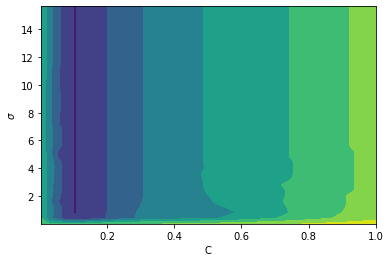

{'C': 0.13038461538461538, 'sigma': 1.6055325289357165}

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.4419e-01 -5.3403e+01  9e+02  1e+01  9e-16
 1: -9.3655e-01 -4.2541e+01  5e+01  1e-01  7e-16
 2: -9.1106e-01 -2.6574e+00  2e+00  2e-03  8e-16
 3: -9.1595e-01 -1.1935e+00  3e-01  3e-04  7e-16
 4: -9.3697e-01 -1.0808e+00  1e-01  2e-16  6e-16
 5: -9.4343e-01 -9.8065e-01  4e-02  4e-16  5e-16
 6: -9.4689e-01 -9.5923e-01  1e-02  6e-16  5e-16
 7: -9.4818e-01 -9.5095e-01  3e-03  5e-16  6e-16
 8: -9.4853e-01 -9.4958e-01  1e-03  2e-16  6e-16
 9: -9.4857e-01 -9.4954e-01  1e-03  3e-16  5e-16
10: -9.4880e-01 -9.4903e-01  2e-04  2e-16  5e-16
11: -9.4885e-01 -9.4893e-01  8e-05  2e-16  6e-16
12: -9.4887e-01 -9.4889e-01  1e-05  6e-16  5e-16
13: -9.4888e-01 -9.4888e-01  7e-07  5e-16  5e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.8076611

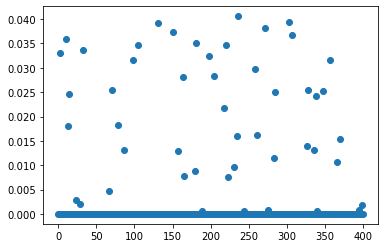

[[0.92175686]] 0.0575


In [88]:
svdd_test = SVDD('gaussian', C = 0.1, sigma = 1)
opt_params = svdd_test.optimise_parameters(X, y = labels, sigma_low = 1e-4, C_opt = True, N_iter = 40, plot_flag = True)

print(opt_params)
#set params
svdd_test.set_params(opt_params)

#Fit model
svdd_test.fit(X, labels)

plt.figure()
plt.scatter(np.arange(len(svdd_test.alphas)), svdd_test.alphas * labels)
plt.show()

print(svdd_test.square_radius, svdd_test.error)

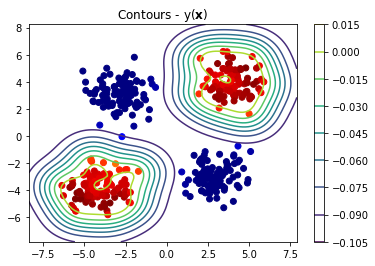

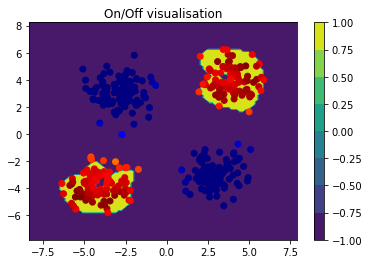

In [89]:
N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N_grid), np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

Z = svdd_test.predict(X_grid)

plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title(r"Contours - y($\mathbf{x}$)")

plt.show()

plt.figure()
plt.contourf(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title("On/Off visualisation")
plt.show()

In [47]:
N_CV = 50
cost = np.zeros(N_CV)

sigma_array = np.linspace(1e-4, 25, N_CV)

for cnt, sigma_cross in enumerate(sigma_array):
    svdd_test = SVDD('gaussian', C = 1, sigma = sigma_cross)
    svdd_test.fit(X, labels)
    cost[cnt] = svdd_test.cost



Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.9750e-01 -4.0199e+02  4e+02  2e-14  2e-16
 1: -9.9750e-01 -5.0075e+00  4e+00  1e-14  2e-16
 2: -9.9750e-01 -1.0376e+00  4e-02  1e-14  7e-17
 3: -9.9750e-01 -9.9790e-01  4e-04  1e-14  5e-17
 4: -9.9750e-01 -9.9750e-01  4e-06  1e-14  5e-17
 5: -9.9750e-01 -9.9750e-01  4e-08  1e-14  4e-17
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.0099500000038144e-08, 'relative gap': 4.0200000000037993e-08, 'primal objective': -0.997500000000006, 'dual objective': -0.9975000400994936, 'primal infeasibility': 1.2631388990325121e-14, 'dual infeasibility': 3.617620117518132e-17, 'primal slack': 0.0025000000000000144, 'dual slack': 1.0000000000009589e-10, 'iterations': 5}

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.8904e-01 -4.0284e+02  4e+02  1e-14  3e


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -8.3364e-01 -4.0473e+02  2e+03  1e+00  5e-16
 1: -8.1223e-01 -1.0817e+02  1e+02  2e-02  9e-16
 2: -7.7767e-01 -3.2499e+00  3e+00  2e-04  9e-16
 3: -7.8108e-01 -1.1244e+00  3e-01  2e-05  1e-15
 4: -8.0306e-01 -1.0896e+00  3e-01  1e-05  7e-16
 5: -8.1770e-01 -9.0054e-01  8e-02  2e-06  6e-16
 6: -8.3122e-01 -8.6347e-01  3e-02  1e-07  7e-16
 7: -8.3434e-01 -8.5324e-01  2e-02  3e-08  6e-16
 8: -8.3759e-01 -8.4332e-01  6e-03  7e-09  6e-16
 9: -8.3855e-01 -8.4116e-01  3e-03  8e-10  6e-16
10: -8.3936e-01 -8.3980e-01  4e-04  1e-10  6e-16
11: -8.3953e-01 -8.3954e-01  8e-06  9e-13  7e-16
12: -8.3953e-01 -8.3953e-01  8e-08  9e-15  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.360075563547614e-08, 'relative gap': 9.958009328236447e-08, 'primal objective': -0.8395328110250098, 'dual objec


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -6.5044e-01 -4.0493e+02  2e+03  1e+00  8e-16
 1: -6.2813e-01 -1.1113e+02  1e+02  3e-02  9e-16
 2: -5.0376e-01 -3.4702e+00  3e+00  4e-04  1e-15
 3: -5.1082e-01 -1.0240e+00  5e-01  6e-05  1e-15
 4: -5.4573e-01 -1.0239e+00  5e-01  4e-05  9e-16
 5: -5.8962e-01 -7.7743e-01  2e-01  1e-05  7e-16
 6: -6.2248e-01 -7.2230e-01  1e-01  3e-06  7e-16
 7: -6.4745e-01 -6.6031e-01  1e-02  1e-07  7e-16
 8: -6.5080e-01 -6.5682e-01  6e-03  5e-08  7e-16
 9: -6.5290e-01 -6.5449e-01  2e-03  1e-08  7e-16
10: -6.5358e-01 -6.5375e-01  2e-04  1e-15  7e-16
11: -6.5366e-01 -6.5367e-01  2e-06  2e-16  7e-16
12: -6.5367e-01 -6.5367e-01  2e-08  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.2135180778484805e-08, 'relative gap': 3.3863148123732175e-08, 'primal objective': -0.6536657695736179, 'dual obj

 2: -3.0099e-01 -3.4364e+00  3e+00  4e-04  1e-15
 3: -3.0508e-01 -7.6981e-01  5e-01  6e-05  1e-15
 4: -3.5011e-01 -7.8357e-01  4e-01  4e-05  9e-16
 5: -3.9128e-01 -5.7346e-01  2e-01  1e-05  7e-16
 6: -4.2150e-01 -5.4243e-01  1e-01  5e-06  7e-16
 7: -4.5227e-01 -4.7975e-01  3e-02  8e-07  7e-16
 8: -4.5760e-01 -4.7002e-01  1e-02  2e-07  7e-16
 9: -4.6273e-01 -4.6290e-01  2e-04  2e-09  8e-16
10: -4.6280e-01 -4.6280e-01  2e-06  2e-11  8e-16
11: -4.6280e-01 -4.6280e-01  2e-08  2e-13  9e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.64076211561771e-08, 'relative gap': 3.545263125367069e-08, 'primal objective': -0.46280404517163426, 'dual objective': -0.462804061571495, 'primal infeasibility': 1.855048458871261e-13, 'dual infeasibility': 9.437369559523785e-16, 'primal slack': 6.347851335976415e-11, 'dual slack': 1.9637548690031313e-11, 'iterations': 11}

Solving the so

 6: -2.9306e-01 -3.6858e-01  8e-02  6e-07  8e-16
 7: -3.1883e-01 -3.2201e-01  3e-03  2e-09  1e-15
 8: -3.2020e-01 -3.2026e-01  5e-05  2e-11  9e-16
 9: -3.2023e-01 -3.2023e-01  5e-07  2e-13  9e-16
10: -3.2023e-01 -3.2023e-01  5e-09  2e-15  1e-15
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.483777452901766e-09, 'relative gap': 1.712449593002941e-08, 'primal objective': -0.3202300070792419, 'dual objective': -0.3202300125629294, 'primal infeasibility': 2.4755968747282777e-15, 'dual infeasibility': 9.647808968275455e-16, 'primal slack': 2.1388766405155118e-11, 'dual slack': 3.6135583362264355e-12, 'iterations': 10}

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -4.2717e-01 -4.1577e+02  2e+03  1e+00  7e-16
 1: -2.7939e-01 -1.1646e+02  1e+02  3e-02  1e-15
 2: -1.7640e-01 -3.0638e+00  3e+00  3e-04  1e-15
 3: -1.7871e-01 -5.1079e-01 


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -3.0761e-01 -4.1477e+02  2e+03  1e+00  7e-16
 1: -1.6994e-01 -1.1461e+02  1e+02  2e-02  1e-15
 2: -1.1825e-01 -2.8213e+00  3e+00  2e-04  1e-15
 3: -1.1969e-01 -3.7228e-01  3e-01  2e-05  1e-15
 4: -1.7369e-01 -3.5927e-01  2e-01  1e-07  9e-16
 5: -1.8379e-01 -3.3680e-01  2e-01  8e-08  9e-16
 6: -2.0248e-01 -2.4807e-01  5e-02  2e-08  9e-16
 7: -2.0916e-01 -2.3331e-01  2e-02  6e-09  9e-16
 8: -2.1776e-01 -2.1833e-01  6e-04  6e-11  1e-15
 9: -2.1799e-01 -2.1800e-01  6e-06  6e-13  9e-16
10: -2.1799e-01 -2.1799e-01  6e-08  6e-15  1e-15
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 5.6339847044159984e-08, 'relative gap': 2.5844639357043945e-07, 'primal objective': -0.21799432472562086, 'dual objective': -0.21799438106530247, 'primal infeasibility': 5.9182410468896314e-15, 'dual infeasibilit

 6: -1.4941e-01 -1.8500e-01  4e-02  5e-16  1e-15
 7: -1.5766e-01 -1.6828e-01  1e-02  6e-16  1e-15
 8: -1.6180e-01 -1.6199e-01  2e-04  4e-16  1e-15
 9: -1.6188e-01 -1.6188e-01  2e-06  4e-16  1e-15
10: -1.6188e-01 -1.6188e-01  2e-08  6e-16  1e-15
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.865047837065835e-08, 'relative gap': 1.1521258520688726e-07, 'primal objective': -0.16187882892452837, 'dual objective': -0.16187884757500715, 'primal infeasibility': 5.627287671106729e-16, 'dual infeasibility': 1.0159240076495343e-15, 'primal slack': 1.4137296396297553e-10, 'dual slack': 2.0294338211803766e-11, 'iterations': 10}

Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -2.0024e-01 -4.1233e+02  2e+03  1e+00  9e-16
 1: -1.0454e-01 -1.1242e+02  1e+02  2e-02  9e-16
 2: -8.0157e-02 -2.6454e+00  3e+00  2e-04  9e-16
 3: -8.0992e-02 -2.7375e-

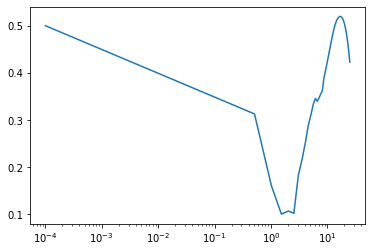


Solving the soft margin problem!
     pcost       dcost       gap    pres   dres
 0: -9.2123e-01 -4.0270e+03  9e+03  1e-01  8e-15
 1: -8.9359e-01 -8.2072e+01  1e+02  1e-03  2e-15
 2: -8.7462e-01 -8.3933e+00  8e+00  1e-05  4e-15
 3: -8.7537e-01 -1.1391e+00  3e-01  4e-07  5e-15
 4: -8.9492e-01 -1.0359e+00  1e-01  1e-07  2e-15
 5: -9.1657e-01 -9.7233e-01  6e-02  7e-09  6e-16
 6: -9.2360e-01 -9.3954e-01  2e-02  4e-10  6e-16
 7: -9.2543e-01 -9.3128e-01  6e-03  4e-16  7e-16
 8: -9.2611e-01 -9.2781e-01  2e-03  6e-16  5e-16
 9: -9.2625e-01 -9.2737e-01  1e-03  5e-16  6e-16
10: -9.2642e-01 -9.2683e-01  4e-04  2e-16  6e-16
11: -9.2651e-01 -9.2662e-01  1e-04  2e-15  7e-16
12: -9.2652e-01 -9.2660e-01  9e-05  1e-15  6e-16
13: -9.2655e-01 -9.2655e-01  8e-06  6e-16  7e-16
14: -9.2655e-01 -9.2655e-01  3e-07  2e-16  7e-16
Optimal solution found.
{'x': <400x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <800x1 matrix, tc='d'>, 'z': <800x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.62823371455368

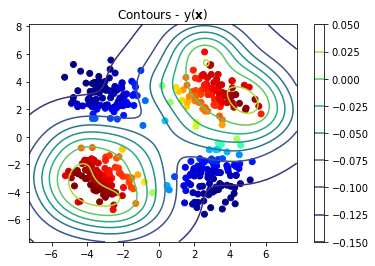

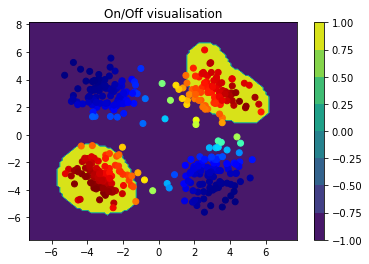

In [48]:
plt.figure()
plt.semilogx(sigma_array, cost)
plt.show()

svdd_test = SVDD('gaussian', C = 10, sigma = sigma_array[np.argmin(optimal_cost)])
svdd_test.fit(X, labels)

N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N_grid), np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

Z = svdd_test.predict(X_grid)

plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title(r"Contours - y($\mathbf{x}$)")

plt.show()

plt.figure()
plt.contourf(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c = svdd_test.predict(X), cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title("On/Off visualisation")
plt.show()